In [2]:
# load modules
%matplotlib inline
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
import pyemma.coordinates
from pyemma.coordinates import source
from pyemma.util.contexts import settings
from pyemma.coordinates import load

def f(x,f,s):
    
    figures_path ='figures_1'
    
    pdb=('mpro.pdb')
    traj=['mpro01.dcd','mpro02.dcd','mpro03.dcd','mpro04.dcd','mpro05.dcd','mpro06.dcd']
    torsions_feat = pyemma.coordinates.featurizer(pdb) 
    selstr=x
    torsions_feat.add_backbone_torsions(selstr, cossin=True, periodic=False)
    torsions_data=pyemma.coordinates.load(traj, features= torsions_feat)
    labels = ['backbone\ntorsions']
    
    score_phi_psi = pyemma.coordinates.vamp(torsions_data[:-1], dim=3).score(
            test_data=torsions_data[-1],
            score_method='VAMP2')
    s.append((score_phi_psi, f))
    
    #time-lagged independent component analysis (TICA)
    tica = pyemma.coordinates.tica(torsions_data, dim=3, lag=50)
    tica_output = tica.get_output()
    tica_concatenated = np.concatenate(tica_output)
    
    ##Clustering
    cluster = pyemma.coordinates.cluster_kmeans(
        tica_concatenated, k=100, max_iter=100, stride=10, fixed_seed=100)
    dtrajs_concatenated = np.concatenate(cluster.dtrajs)
    its = pyemma.msm.its(cluster.dtrajs, lags=[10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 450], nits=10, errors='bayes')

    nstates=3
    msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=50, dt_traj='1 ns', conf=0.95)
    #pyemma.plots.plot_cktest(msm.cktest(nstates));
    msm.pcca(nstates)
    #check the location of our discrete states by plotting them onto the density of our data in the first two TICA dimensions
    #The cluster centers are contained in the cluster object

    #We note that the states are well distributed in the low-dimensional TICA subspace
    def draw_panel(ax, i, j):
        _, _, misc = pyemma.plots.plot_state_map(
            *tica_concatenated[:, [i, j]].T,
            msm.metastable_assignments[dtrajs_concatenated],
            ax=ax)
        ax.set_xlabel('IC {}'.format(i + 1))
        ax.set_ylabel('IC {}'.format(j + 1))
        misc['cbar'].set_ticklabels(range(1, msm.nstates + 1))

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    try:
        draw_panel(axes[0, 0], 0, 2)
        draw_panel(axes[0, 1], 1, 2)
        draw_panel(axes[1, 0], 0, 1)
        axes[1, 1].set_axis_off()
        fig.tight_layout()
        fig.savefig(figures_path+os.path.sep+"states_{}".format(str(f))+".png")
    except:
        pass
    
    

def VAMP2(t):
    
    figures_path ='figures_1'
    
    if not os.path.exists(figures_path):
        os.mkdir(figures_path)
    
    scores=[]
    
    for threshold in t:
        pdb=('mpro.pdb')
        traj=['mpro01.dcd','mpro02.dcd','mpro03.dcd','mpro04.dcd','mpro05.dcd','mpro06.dcd']
        torsions_feat = pyemma.coordinates.featurizer(pdb) 
        selstr="resSeq 2 3 5 6 8 11 13 12 14 15 19 22 27 28 33 35 34 40 41 42 43 44 45 46 47 49 48 50 53 52 54 56 55 57 59 58 62 63 65 81 83 82 84 86 101 111 110 112 113 117 119 118 121 120 124 126 127 129 130 131 132 137 136 138 140 139 142 141 143 144 159 160 161 165 164 167 169 170 175 176 182 181 183 185 187 186 188 190 189 192 194 193 200 204 203 205 208 214 216 217 219 220 226 225 227 234 238 240 239 241 268 271 275 276 277 278 280 279 282 281 283 284 285 286 287 288 289 290 291 293 295 297 298 301 300 303 302 305 304 306"
        torsions_feat.add_backbone_torsions(selstr, cossin=True, periodic=False)
        torsions_data=pyemma.coordinates.load(traj, features= torsions_feat)
        labels = ['backbone\ntorsions']
        
        #time-lagged independent component analysis (TICA)
        tica = pyemma.coordinates.tica(torsions_data, dim=3, lag=50)
        tica_output = tica.get_output()
        tica_concatenated = np.concatenate(tica_output)
        
        C = tica.feature_TIC_correlation
        df = pd.DataFrame(C[:,:3], columns=['IC1','IC2','IC3'])
        p=[]
        for j in torsions_feat.describe():
            a = re.findall(r'(?<=\s)\d+(?=\))',j) #το έκανα αυτό γιατί παρατήρησα οτι κάποιες φορές οι θέσεις είναι ανακατεμένες
            p.append(int(a[0]))
        df['pos']=p
        DF3 = df[~(df['IC1']<=threshold) | ~(df['IC1']>=-threshold)]
        DF3 = DF3[~(DF3['IC2']<=threshold) | ~(DF3['IC2']>=-threshold)] 
        DF3 = DF3[~(DF3['IC3']<=threshold) | ~(DF3['IC3']>=-threshold)] 
        
        pos_IC1_2_3 = 'resSeq '
        for k in DF3['pos']:
            if str(k) not in pos_IC1_2_3:
                pos_IC1_2_3 += str(k)+' '
        f(pos_IC1_2_3,threshold,scores)
    print(scores)

estimating BayesianMSM:  33%|███▎      | 4/12 [00:00<00:04,  1.62it/s]

03-07-20 07:08:31 pyemma.msm.estimators.bayesian_msm.BayesianMSM[19] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:08:31 pyemma.msm.estimators.bayesian_msm.BayesianMSM[19] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:08:31 pyemma.msm.estimators.bayesian_msm.BayesianMSM[20] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  58%|█████▊    | 7/12 [00:01<00:02,  2.19it/s]

03-07-20 07:08:31 pyemma.msm.estimators.bayesian_msm.BayesianMSM[20] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:08:32 pyemma.msm.estimators.bayesian_msm.BayesianMSM[21] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  75%|███████▌  | 9/12 [00:01<00:01,  2.88it/s]

03-07-20 07:08:32 pyemma.msm.estimators.bayesian_msm.BayesianMSM[21] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:01<00:00,  7.72it/s]                        

03-07-20 07:08:32 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[16] WARNING  Estimation has failed at lagtimes: [150 200 250 300 350 450]. Details:
['Error at lag time 150: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 200: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 450: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:08:32 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[16] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1184it [00:00, 18285.79it/s]                                                                                              
estimating BayesianMSM:  25%|██▌       | 3/12 [00:01<00:05,  1.54it/s]

03-07-20 07:08:39 pyemma.msm.estimators.bayesian_msm.BayesianMSM[38] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  42%|████▏     | 5/12 [00:01<00:03,  2.11it/s]

03-07-20 07:08:39 pyemma.msm.estimators.bayesian_msm.BayesianMSM[38] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:08:39 pyemma.msm.estimators.bayesian_msm.BayesianMSM[39] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  58%|█████▊    | 7/12 [00:01<00:01,  2.76it/s]

03-07-20 07:08:39 pyemma.msm.estimators.bayesian_msm.BayesianMSM[39] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:08:39 pyemma.msm.estimators.bayesian_msm.BayesianMSM[40] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  75%|███████▌  | 9/12 [00:01<00:00,  3.49it/s]

03-07-20 07:08:39 pyemma.msm.estimators.bayesian_msm.BayesianMSM[40] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:01<00:00,  6.49it/s]                        

03-07-20 07:08:40 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[35] WARNING  Estimation has failed at lagtimes: [150 200 250 300 350 450]. Details:
['Error at lag time 150: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 200: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 450: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:08:40 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[35] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1184it [00:00, 12815.43it/s]                                                                                              
estimating BayesianMSM:  33%|███▎      | 4/12 [00:01<00:04,  1.97it/s]

03-07-20 07:08:49 pyemma.msm.estimators.bayesian_msm.BayesianMSM[57] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:08:49 pyemma.msm.estimators.bayesian_msm.BayesianMSM[57] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  50%|█████     | 6/12 [00:01<00:02,  2.64it/s]

03-07-20 07:08:49 pyemma.msm.estimators.bayesian_msm.BayesianMSM[58] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  58%|█████▊    | 7/12 [00:01<00:01,  3.17it/s]

03-07-20 07:08:50 pyemma.msm.estimators.bayesian_msm.BayesianMSM[58] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  67%|██████▋   | 8/12 [00:01<00:01,  3.65it/s]

03-07-20 07:08:50 pyemma.msm.estimators.bayesian_msm.BayesianMSM[59] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  83%|████████▎ | 10/12 [00:01<00:00,  4.67it/s]

03-07-20 07:08:50 pyemma.msm.estimators.bayesian_msm.BayesianMSM[59] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:01<00:00,  6.26it/s]                        

03-07-20 07:08:50 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[54] WARNING  Estimation has failed at lagtimes: [150 200 250 300 350 450]. Details:
['Error at lag time 150: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 200: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 450: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:08:51 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[54] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1184it [00:00, 13257.98it/s]                                                                                              
estimating BayesianMSM:  25%|██▌       | 3/12 [00:01<00:06,  1.44it/s]

03-07-20 07:08:59 pyemma.msm.estimators.bayesian_msm.BayesianMSM[76] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  42%|████▏     | 5/12 [00:01<00:03,  1.96it/s]

03-07-20 07:08:59 pyemma.msm.estimators.bayesian_msm.BayesianMSM[76] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:08:59 pyemma.msm.estimators.bayesian_msm.BayesianMSM[77] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  58%|█████▊    | 7/12 [00:01<00:01,  2.58it/s]

03-07-20 07:08:59 pyemma.msm.estimators.bayesian_msm.BayesianMSM[77] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  67%|██████▋   | 8/12 [00:01<00:01,  3.25it/s]

03-07-20 07:09:00 pyemma.msm.estimators.bayesian_msm.BayesianMSM[78] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  83%|████████▎ | 10/12 [00:01<00:00,  4.32it/s]

03-07-20 07:09:00 pyemma.msm.estimators.bayesian_msm.BayesianMSM[78] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:01<00:00,  6.47it/s]                        

03-07-20 07:09:00 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[73] WARNING  Estimation has failed at lagtimes: [150 200 250 300 350 450]. Details:
['Error at lag time 150: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 200: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 450: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:09:00 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[73] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1184it [00:00, 12052.83it/s]                                                                                              
estimating BayesianMSM:  25%|██▌       | 3/12 [00:01<00:06,  1.47it/s]

03-07-20 07:09:08 pyemma.msm.estimators.bayesian_msm.BayesianMSM[95] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  42%|████▏     | 5/12 [00:01<00:03,  2.00it/s]

03-07-20 07:09:08 pyemma.msm.estimators.bayesian_msm.BayesianMSM[95] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:09:08 pyemma.msm.estimators.bayesian_msm.BayesianMSM[96] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  58%|█████▊    | 7/12 [00:01<00:01,  2.60it/s]

03-07-20 07:09:09 pyemma.msm.estimators.bayesian_msm.BayesianMSM[96] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  67%|██████▋   | 8/12 [00:01<00:01,  3.34it/s]

03-07-20 07:09:09 pyemma.msm.estimators.bayesian_msm.BayesianMSM[97] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  75%|███████▌  | 9/12 [00:01<00:00,  3.86it/s]

03-07-20 07:09:09 pyemma.msm.estimators.bayesian_msm.BayesianMSM[97] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:01<00:00,  6.12it/s]                        

03-07-20 07:09:09 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[92] WARNING  Estimation has failed at lagtimes: [150 200 250 300 350 450]. Details:
['Error at lag time 150: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 200: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 450: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:09:10 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[92] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1184it [00:00, 11241.50it/s]                                                                                              
estimating BayesianMSM:  25%|██▌       | 3/12 [00:01<00:06,  1.36it/s]

03-07-20 07:09:18 pyemma.msm.estimators.bayesian_msm.BayesianMSM[114] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  42%|████▏     | 5/12 [00:01<00:03,  1.81it/s]

03-07-20 07:09:18 pyemma.msm.estimators.bayesian_msm.BayesianMSM[115] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  58%|█████▊    | 7/12 [00:01<00:01,  2.60it/s]

03-07-20 07:09:18 pyemma.msm.estimators.bayesian_msm.BayesianMSM[116] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  67%|██████▋   | 8/12 [00:01<00:01,  3.32it/s]

03-07-20 07:09:18 pyemma.msm.estimators.bayesian_msm.BayesianMSM[115] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]                        

03-07-20 07:09:19 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[111] WARNING  Estimation has failed at lagtimes: [200 250 300 350]. Details:
['Error at lag time 200: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:09:19 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[111] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1168it [00:00, 11914.62it/s]                                                                                               
estimating BayesianMSM:  25%|██▌       | 3/12 [00:01<00:04,  1.83it/s]

03-07-20 07:09:28 pyemma.msm.estimators.bayesian_msm.BayesianMSM[133] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  42%|████▏     | 5/12 [00:01<00:02,  2.38it/s]

03-07-20 07:09:28 pyemma.msm.estimators.bayesian_msm.BayesianMSM[134] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  50%|█████     | 6/12 [00:01<00:02,  2.54it/s]

03-07-20 07:09:28 pyemma.msm.estimators.bayesian_msm.BayesianMSM[135] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  67%|██████▋   | 8/12 [00:02<00:01,  3.24it/s]

03-07-20 07:09:28 pyemma.msm.estimators.bayesian_msm.BayesianMSM[134] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:02<00:00,  4.81it/s]                        

03-07-20 07:09:29 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[130] WARNING  Estimation has failed at lagtimes: [200 250 300 350]. Details:
['Error at lag time 200: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:09:29 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[130] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1200it [00:00, 11167.59it/s]                                                                                                             
estimating BayesianMSM:  50%|█████     | 6/12 [00:02<00:02,  2.84it/s]

03-07-20 07:09:38 pyemma.msm.estimators.bayesian_msm.BayesianMSM[153] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  67%|██████▋   | 8/12 [00:02<00:01,  3.77it/s]

03-07-20 07:09:38 pyemma.msm.estimators.bayesian_msm.BayesianMSM[153] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:09:38 pyemma.msm.estimators.bayesian_msm.BayesianMSM[153] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:02<00:00,  4.66it/s]                        

03-07-20 07:09:38 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[149] WARNING  Estimation has failed at lagtimes: [250 300 350]. Details:
['Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:09:39 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[149] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1200it [00:00, 10741.52it/s]                                                                                                             
estimating BayesianMSM:  25%|██▌       | 3/12 [00:01<00:07,  1.27it/s]

03-07-20 07:09:47 pyemma.msm.estimators.bayesian_msm.BayesianMSM[171] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  42%|████▏     | 5/12 [00:01<00:04,  1.73it/s]

03-07-20 07:09:47 pyemma.msm.estimators.bayesian_msm.BayesianMSM[171] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:09:47 pyemma.msm.estimators.bayesian_msm.BayesianMSM[172] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  58%|█████▊    | 7/12 [00:01<00:02,  2.33it/s]

03-07-20 07:09:47 pyemma.msm.estimators.bayesian_msm.BayesianMSM[172] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:09:48 pyemma.msm.estimators.bayesian_msm.BayesianMSM[173] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  75%|███████▌  | 9/12 [00:01<00:01,  2.91it/s]

03-07-20 07:09:48 pyemma.msm.estimators.bayesian_msm.BayesianMSM[173] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:02<00:00,  5.62it/s]                        

03-07-20 07:09:48 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[168] WARNING  Estimation has failed at lagtimes: [150 200 250 300 350 450]. Details:
['Error at lag time 150: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 200: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 450: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:09:49 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[168] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1200it [00:00, 11190.53it/s]                                                                                               
estimating BayesianMSM:  33%|███▎      | 4/12 [00:01<00:04,  1.94it/s]

03-07-20 07:09:56 pyemma.msm.estimators.bayesian_msm.BayesianMSM[190] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  42%|████▏     | 5/12 [00:01<00:02,  2.47it/s]

03-07-20 07:09:56 pyemma.msm.estimators.bayesian_msm.BayesianMSM[191] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  50%|█████     | 6/12 [00:01<00:02,  2.69it/s]

03-07-20 07:09:57 pyemma.msm.estimators.bayesian_msm.BayesianMSM[192] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  75%|███████▌  | 9/12 [00:02<00:00,  3.96it/s]

03-07-20 07:09:57 pyemma.msm.estimators.bayesian_msm.BayesianMSM[193] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:09:57 pyemma.msm.estimators.bayesian_msm.BayesianMSM[191] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:02<00:00,  5.60it/s]                        

03-07-20 07:09:57 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[187] WARNING  Estimation has failed at lagtimes: [200 250 300 350 450]. Details:
['Error at lag time 200: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 450: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:09:58 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[187] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1184it [00:00, 11169.84it/s]                                                                                                             
estimating BayesianMSM:  33%|███▎      | 4/12 [00:01<00:04,  1.86it/s]

03-07-20 07:10:06 pyemma.msm.estimators.bayesian_msm.BayesianMSM[209] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  42%|████▏     | 5/12 [00:01<00:02,  2.46it/s]

03-07-20 07:10:06 pyemma.msm.estimators.bayesian_msm.BayesianMSM[209] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:10:06 pyemma.msm.estimators.bayesian_msm.BayesianMSM[210] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  58%|█████▊    | 7/12 [00:01<00:01,  3.15it/s]

03-07-20 07:10:06 pyemma.msm.estimators.bayesian_msm.BayesianMSM[210] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:10:06 pyemma.msm.estimators.bayesian_msm.BayesianMSM[211] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  75%|███████▌  | 9/12 [00:01<00:00,  3.86it/s]

03-07-20 07:10:06 pyemma.msm.estimators.bayesian_msm.BayesianMSM[211] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:02<00:00,  5.54it/s]                        

03-07-20 07:10:07 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[206] WARNING  Estimation has failed at lagtimes: [150 200 250 300 350 450]. Details:
['Error at lag time 150: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 200: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 450: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:10:07 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[206] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1264it [00:00, 11669.21it/s]                                                                                                             
estimating BayesianMSM:  25%|██▌       | 3/12 [00:01<00:06,  1.30it/s]

03-07-20 07:10:15 pyemma.msm.estimators.bayesian_msm.BayesianMSM[228] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  42%|████▏     | 5/12 [00:01<00:04,  1.72it/s]

03-07-20 07:10:15 pyemma.msm.estimators.bayesian_msm.BayesianMSM[229] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  67%|██████▋   | 8/12 [00:02<00:01,  2.63it/s]

03-07-20 07:10:16 pyemma.msm.estimators.bayesian_msm.BayesianMSM[230] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:10:16 pyemma.msm.estimators.bayesian_msm.BayesianMSM[229] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:10:16 pyemma.msm.estimators.bayesian_msm.BayesianMSM[229] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:02<00:00,  5.43it/s]                        

03-07-20 07:10:16 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[225] WARNING  Estimation has failed at lagtimes: [200 250 300 350 450]. Details:
['Error at lag time 200: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 450: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:10:16 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[225] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1232it [00:00, 11253.92it/s]                                                                                                            
estimating BayesianMSM:  33%|███▎      | 4/12 [00:01<00:03,  2.39it/s]

03-07-20 07:10:24 pyemma.msm.estimators.bayesian_msm.BayesianMSM[247] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  42%|████▏     | 5/12 [00:01<00:02,  2.80it/s]

03-07-20 07:10:24 pyemma.msm.estimators.bayesian_msm.BayesianMSM[248] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  67%|██████▋   | 8/12 [00:02<00:01,  3.44it/s]

03-07-20 07:10:25 pyemma.msm.estimators.bayesian_msm.BayesianMSM[249] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:10:25 pyemma.msm.estimators.bayesian_msm.BayesianMSM[248] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:10:25 pyemma.msm.estimators.bayesian_msm.BayesianMSM[248] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:02<00:00,  5.03it/s]                        

03-07-20 07:10:25 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[244] WARNING  Estimation has failed at lagtimes: [200 250 300 350 450]. Details:
['Error at lag time 200: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 450: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:10:26 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[244] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1168it [00:00, 10516.44it/s]                                                                                                           
estimating BayesianMSM:  50%|█████     | 6/12 [00:02<00:03,  1.91it/s]

03-07-20 07:10:34 pyemma.msm.estimators.bayesian_msm.BayesianMSM[267] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  67%|██████▋   | 8/12 [00:02<00:01,  2.61it/s]

03-07-20 07:10:34 pyemma.msm.estimators.bayesian_msm.BayesianMSM[267] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:10:34 pyemma.msm.estimators.bayesian_msm.BayesianMSM[267] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:02<00:00,  4.22it/s]                        

03-07-20 07:10:34 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[263] WARNING  Estimation has failed at lagtimes: [250 300 350]. Details:
['Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:10:35 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[263] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1296it [00:00, 10975.13it/s]                                                                                                           
estimating BayesianMSM:  58%|█████▊    | 7/12 [00:02<00:02,  2.18it/s]

03-07-20 07:10:43 pyemma.msm.estimators.bayesian_msm.BayesianMSM[286] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


estimating BayesianMSM:  75%|███████▌  | 9/12 [00:02<00:01,  2.92it/s]

03-07-20 07:10:43 pyemma.msm.estimators.bayesian_msm.BayesianMSM[286] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
03-07-20 07:10:43 pyemma.msm.estimators.bayesian_msm.BayesianMSM[286] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:02<00:00,  4.26it/s]                        

03-07-20 07:10:44 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[282] WARNING  Estimation has failed at lagtimes: [250 300 350]. Details:
['Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration',
 'Error at lag time 350: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:10:44 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[282] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1264it [00:00, 10716.52it/s]                                                                                                           
estimating BayesianMSM:  58%|█████▊    | 7/12 [00:02<00:02,  2.26it/s]

03-07-20 07:10:52 pyemma.msm.estimators.bayesian_msm.BayesianMSM[305] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:02<00:00,  4.15it/s]                        

03-07-20 07:10:53 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[301] WARNING  Estimation has failed at lagtimes: [250]. Details:
['Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:10:54 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[301] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1248it [00:00, 10864.88it/s]                                                                                                           
100%|██████████| 12/12 [00:03<00:00,  3.94it/s]                        
1248it [00:00, 10391.05it/s]                                                                                                           
estimating BayesianMSM:  42%|████▏     | 5/12 [00:02<00:03,  1.96it/s]

03-07-20 07:11:11 pyemma.msm.estimators.bayesian_msm.BayesianMSM[343] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:02<00:00,  4.03it/s]                        

03-07-20 07:11:12 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[339] WARNING  Estimation has failed at lagtimes: [250]. Details:
['Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:11:13 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[339] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1248it [00:00, 10240.42it/s]                                                                                                           
estimating BayesianMSM:  58%|█████▊    | 7/12 [00:02<00:02,  1.98it/s]

03-07-20 07:11:20 pyemma.msm.estimators.bayesian_msm.BayesianMSM[362] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:03<00:00,  3.97it/s]                        

03-07-20 07:11:21 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[358] WARNING  Estimation has failed at lagtimes: [300]. Details:
['Error at lag time 300: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:11:22 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[358] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1264it [00:00, 10748.28it/s]                                                                                                           
estimating BayesianMSM:  50%|█████     | 6/12 [00:02<00:03,  1.93it/s]

03-07-20 07:11:29 pyemma.msm.estimators.bayesian_msm.BayesianMSM[381] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


100%|██████████| 12/12 [00:02<00:00,  4.04it/s]                        

03-07-20 07:11:30 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[377] WARNING  Estimation has failed at lagtimes: [250]. Details:
['Error at lag time 250: Stationary distribution contains entries smaller than '
 '1e-15 during iteration']


03-07-20 07:11:31 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[377] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


1296it [00:00, 10587.55it/s]                                                                                                           
100%|██████████| 12/12 [00:03<00:00,  3.67it/s]                        
1296it [00:00, 10305.45it/s]                                                                                                           
100%|██████████| 100/100 [00:00<00:00, 383.02it/s]                                                                   
/home/debian-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 12/12 [00:03<00:00,  3.69it/s]                        
1296it [00:00, 10064.24it/s]                                                                                      

[(1.541874409598567, 0.0), (1.541874409598567, 0.005), (1.541874409598567, 0.01), (1.541874409598567, 0.015), (1.541874409598567, 0.02), (1.5558371347027031, 0.025), (1.562258774467426, 0.03), (1.575943745719648, 0.035), (1.5761157296750428, 0.04), (1.573831120816397, 0.045), (1.5458725447740642, 0.05), (1.5308844844191147, 0.055), (1.5154887628625442, 0.06), (1.600064079323222, 0.065), (1.5988087047764445, 0.07), (1.5876261053452871, 0.075), (1.5877575460507185, 0.08), (1.5675188891659388, 0.085), (1.5651077794948147, 0.09), (1.5830708083035756, 0.095), (1.6558049371720522, 0.1), (1.6465737752680423, 0.105), (1.677708984297957, 0.11), (1.6935175045200612, 0.115), (1.6983460729301583, 0.12), (1.6981973046518983, 0.125), (1.5194670189412103, 0.13), (1.508092589913359, 0.135), (1.506615231394719, 0.14), (1.4838529352470016, 0.145), (1.4736672833624844, 0.15), (1.3162596797485673, 0.155), (1.3190680594558537, 0.16), (1.3190680594558537, 0.165), (1.3198043523326732, 0.17), (1.3096474478954

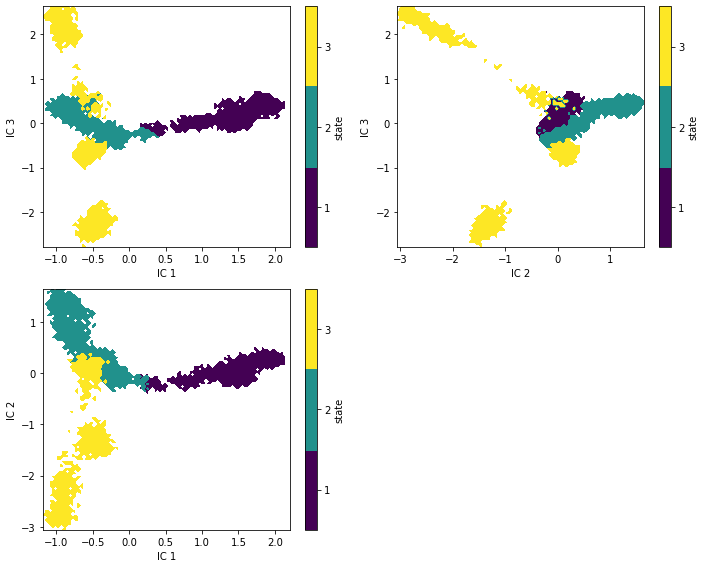

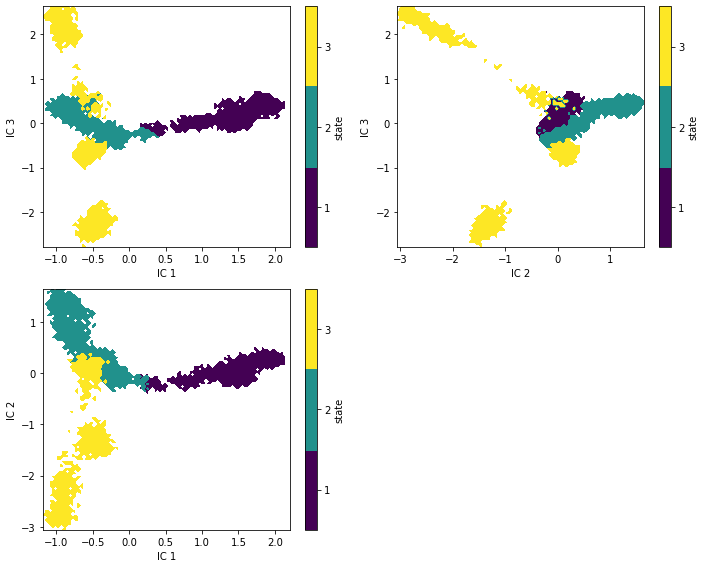

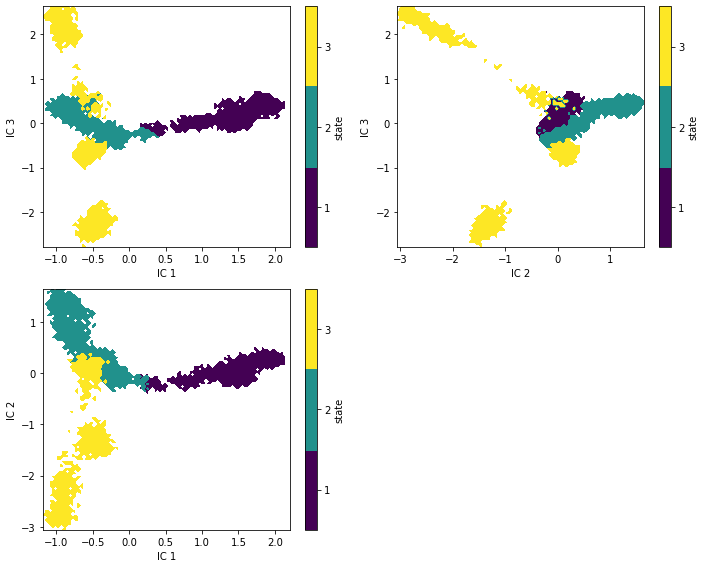

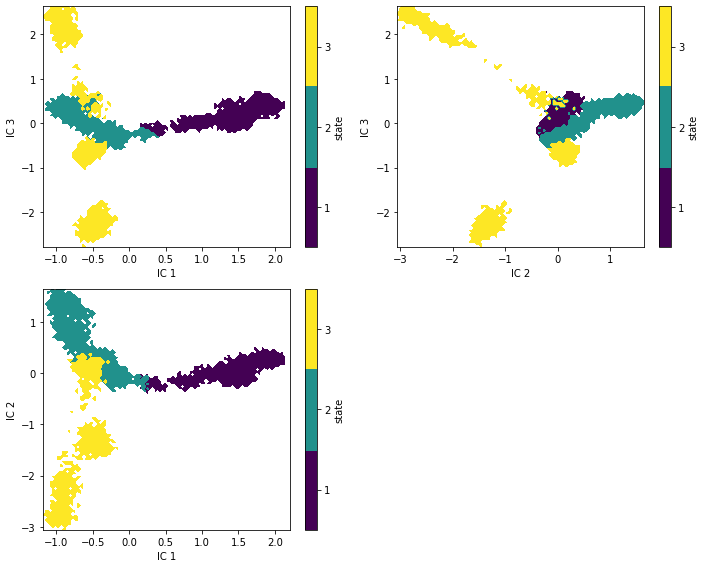

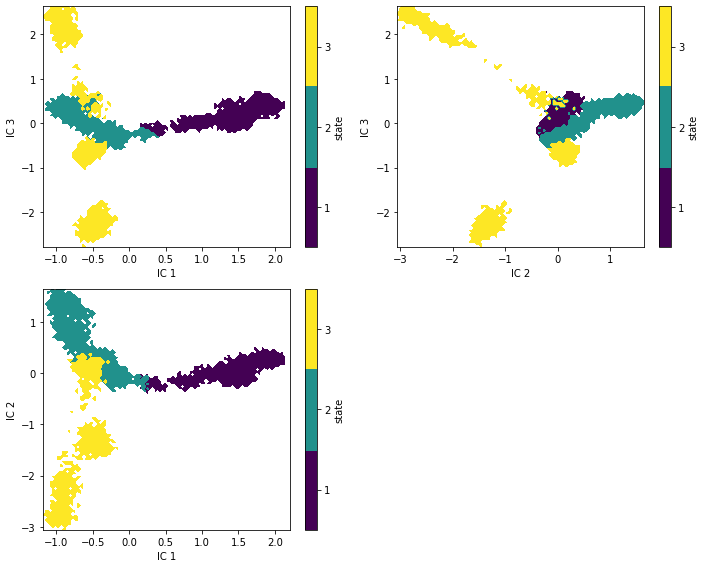

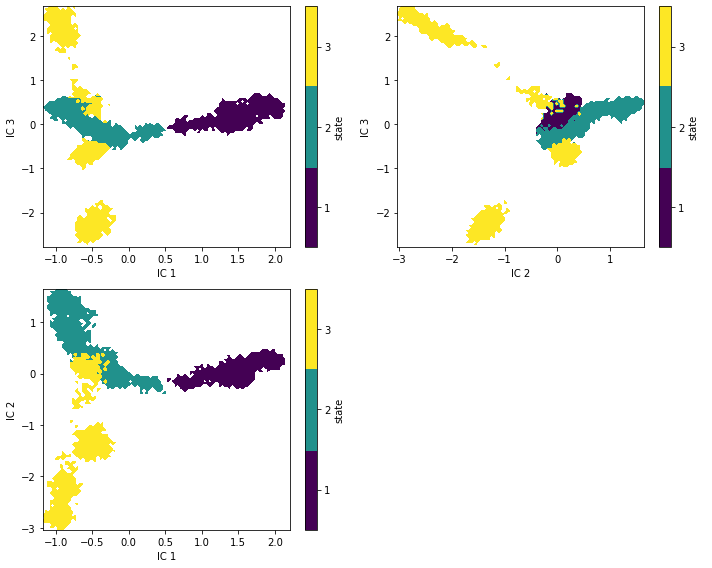

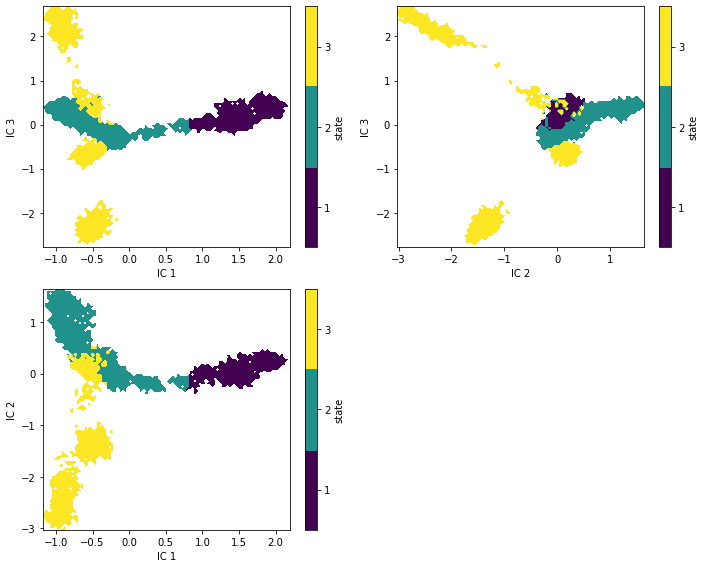

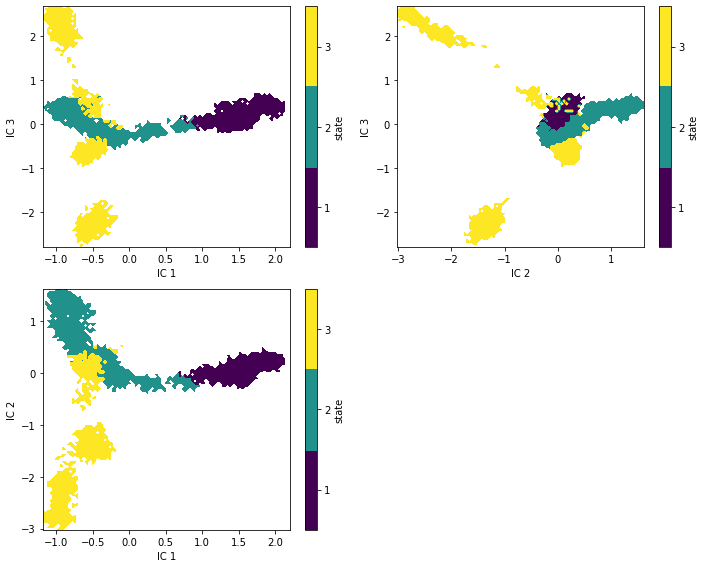

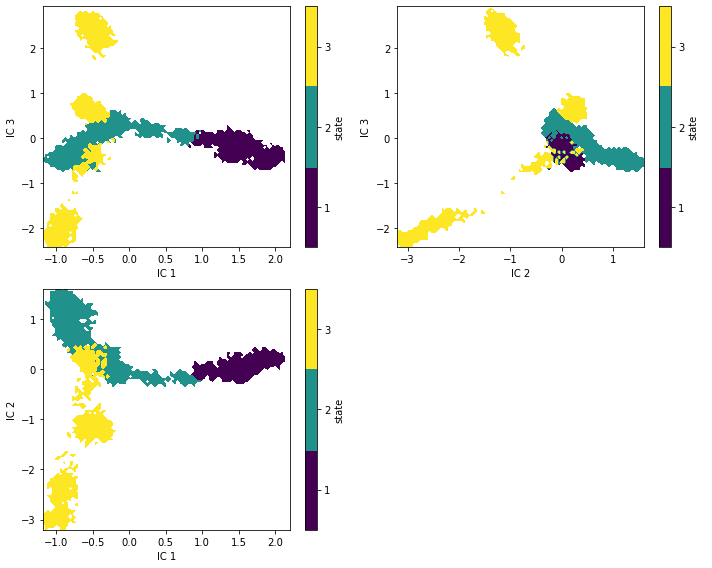

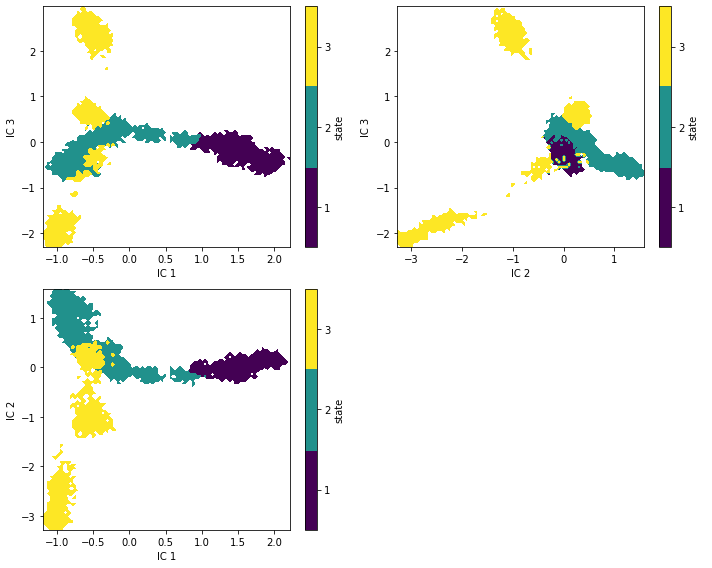

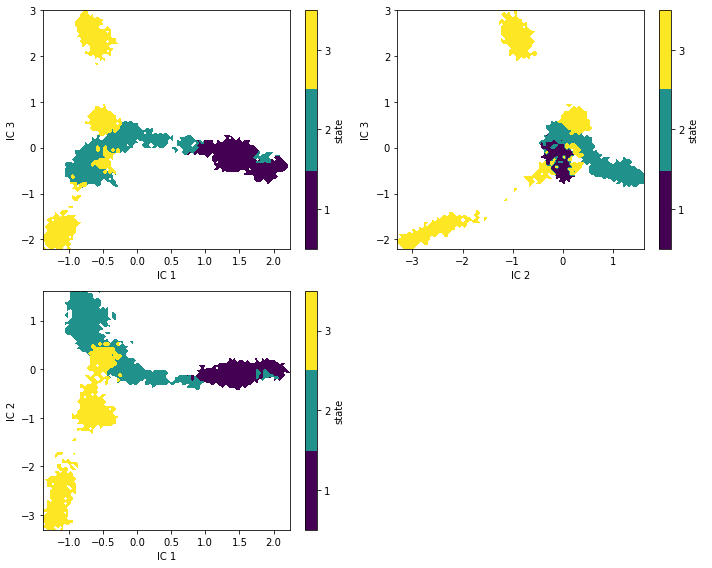

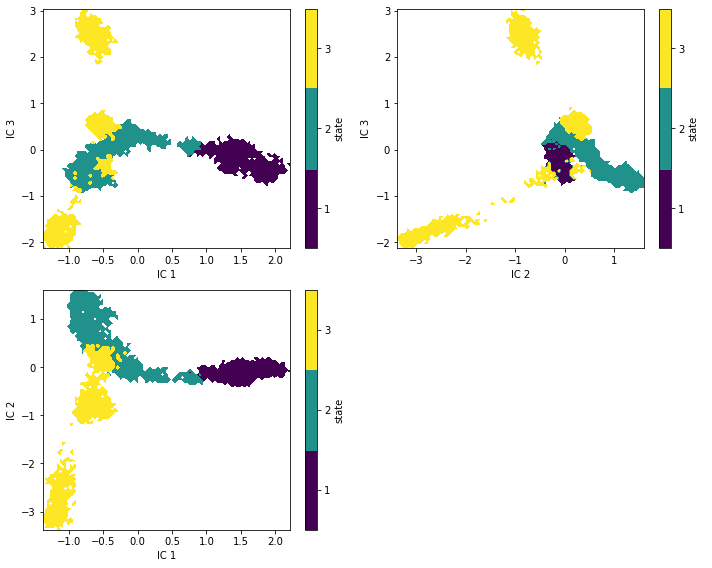

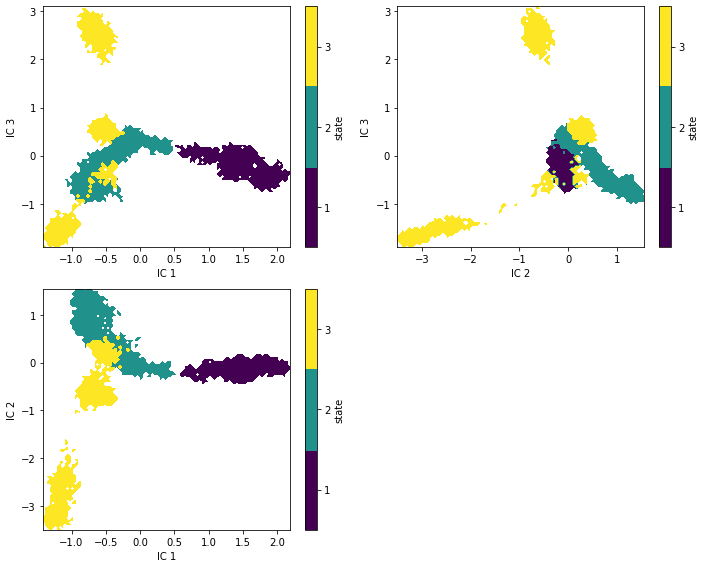

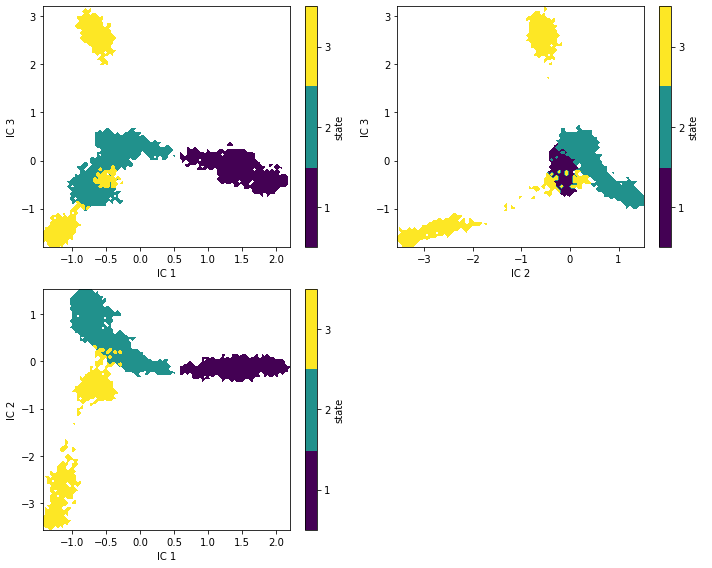

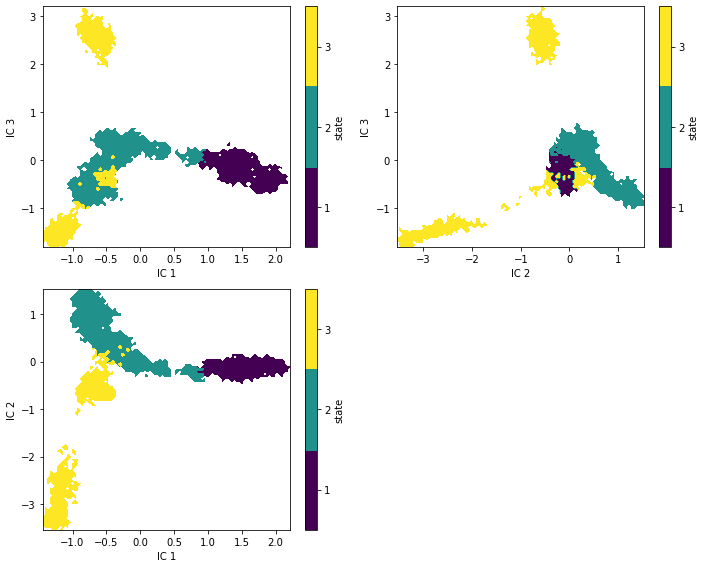

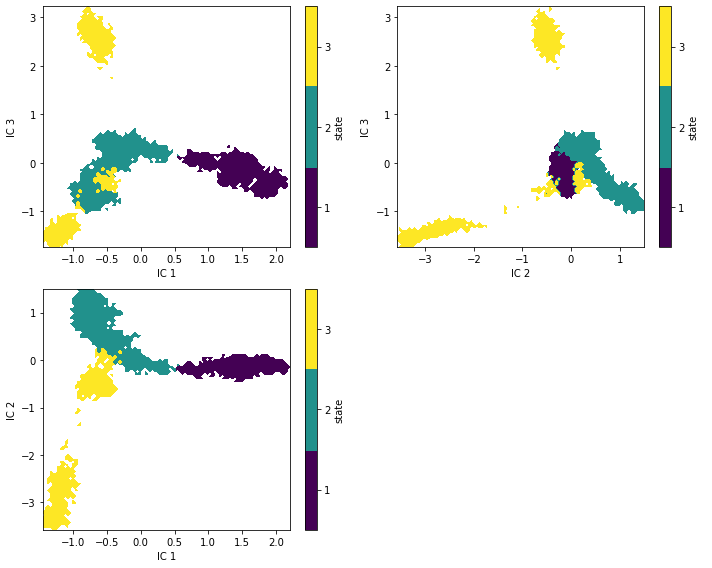

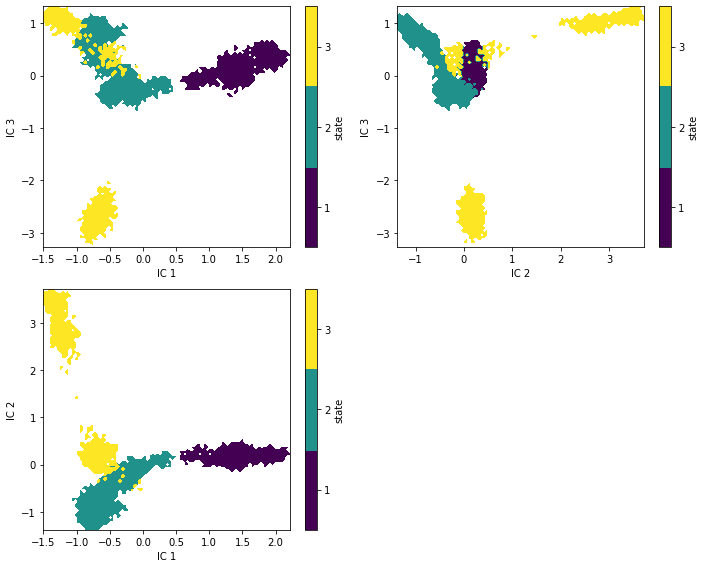

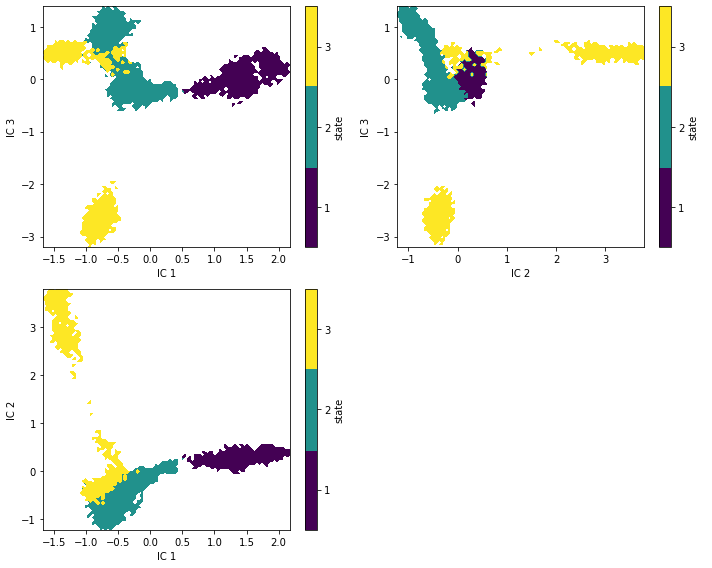

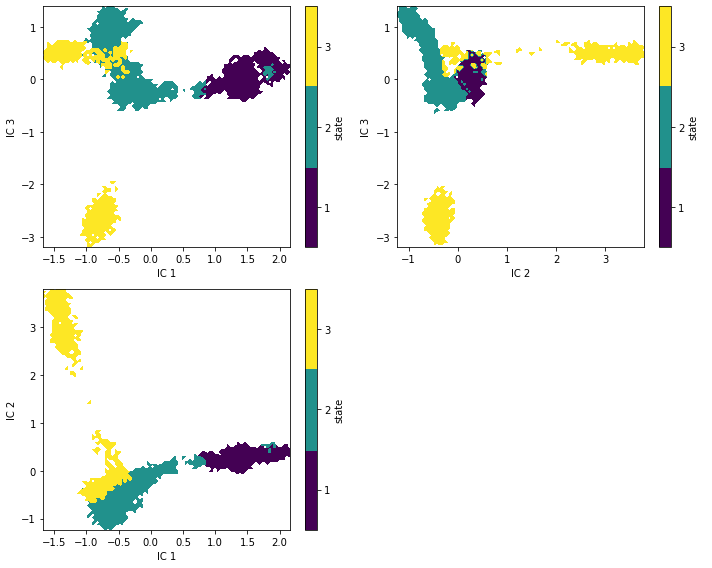

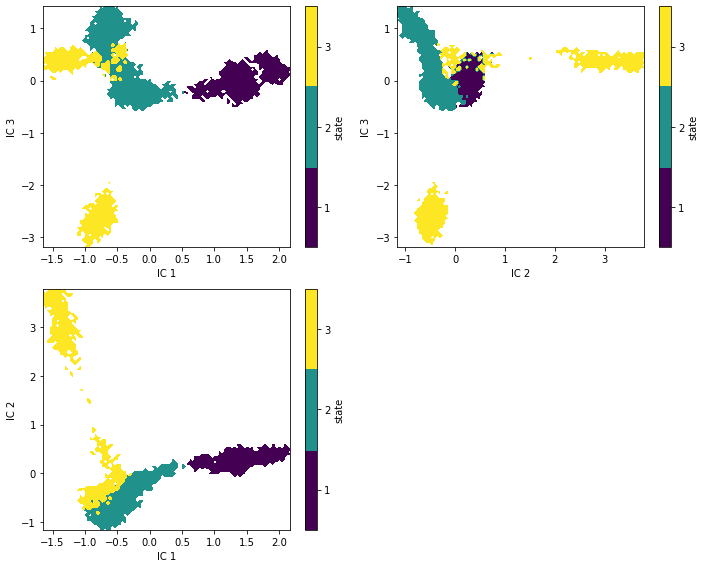

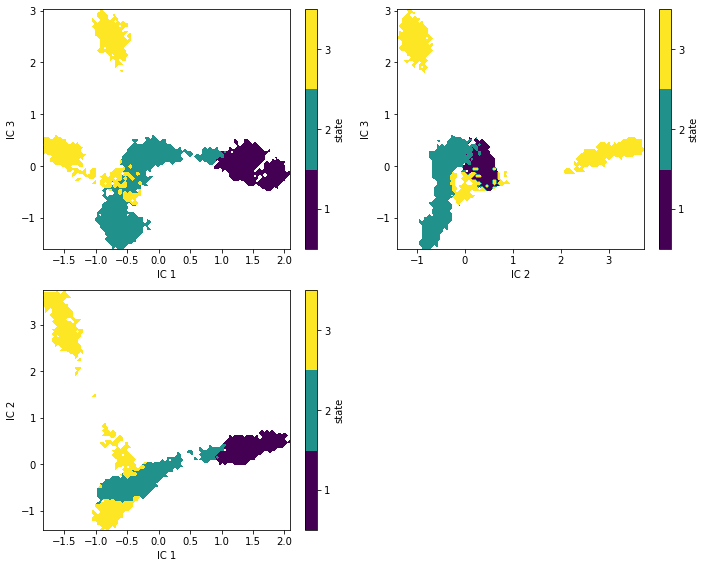

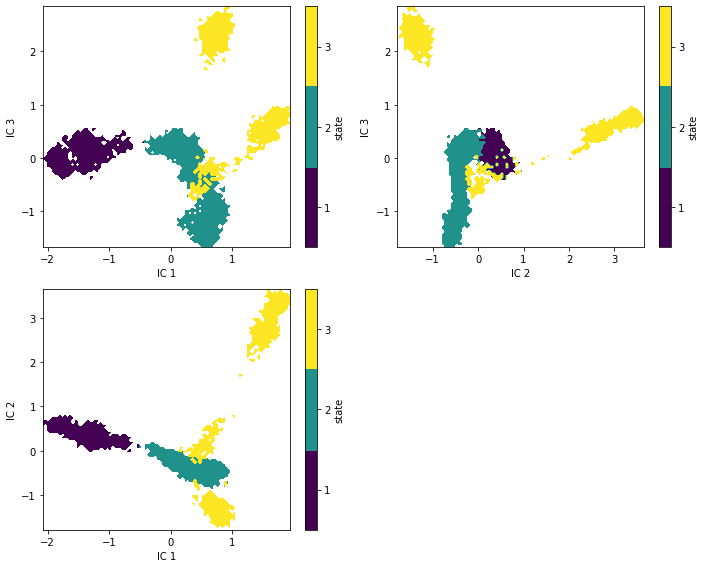

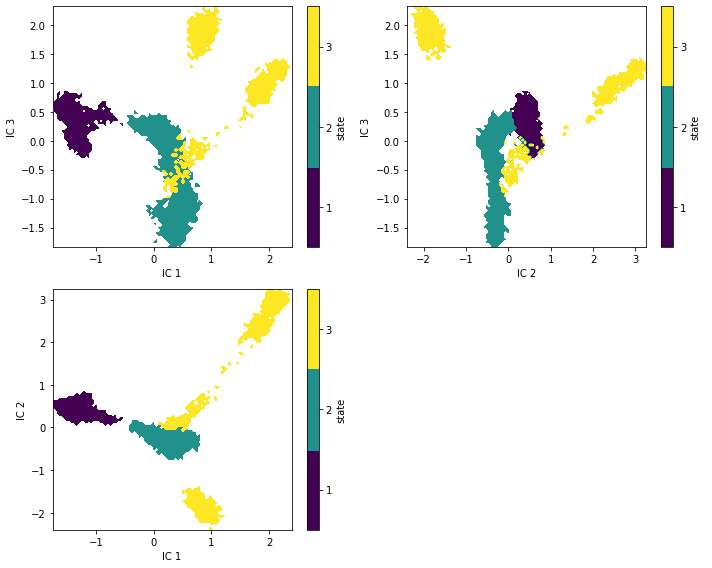

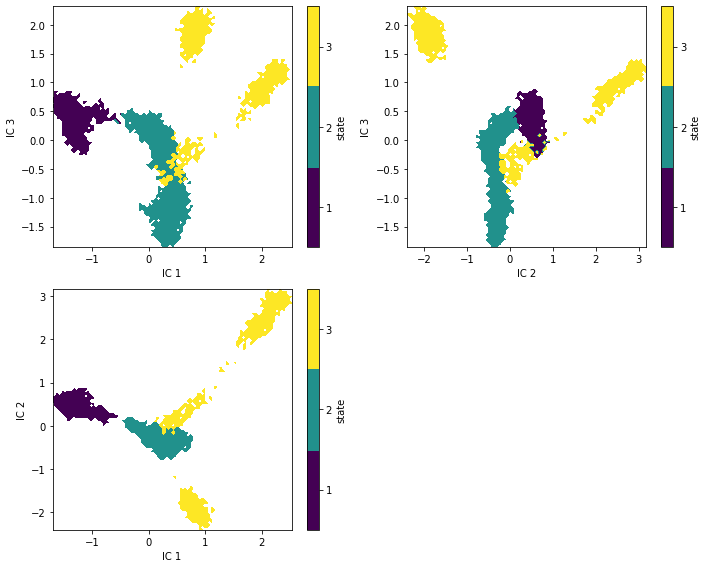

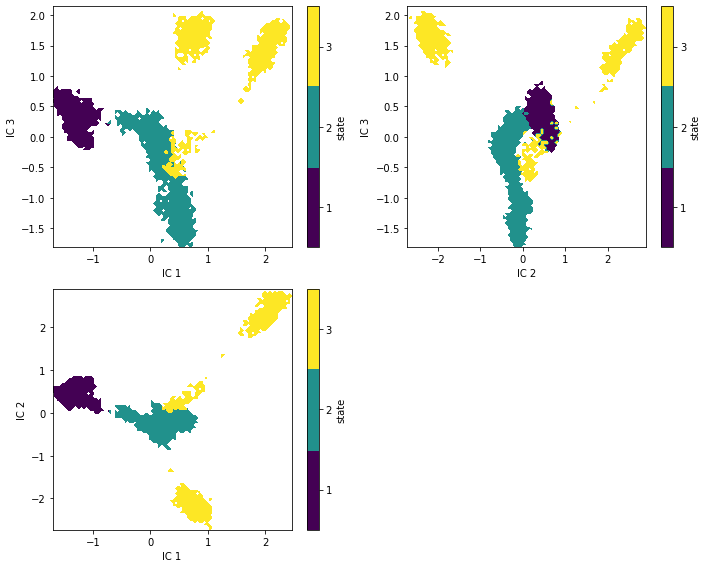

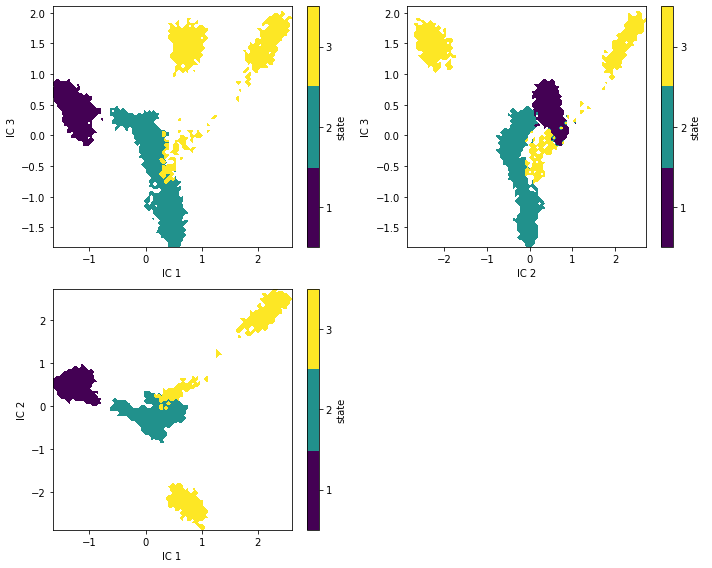

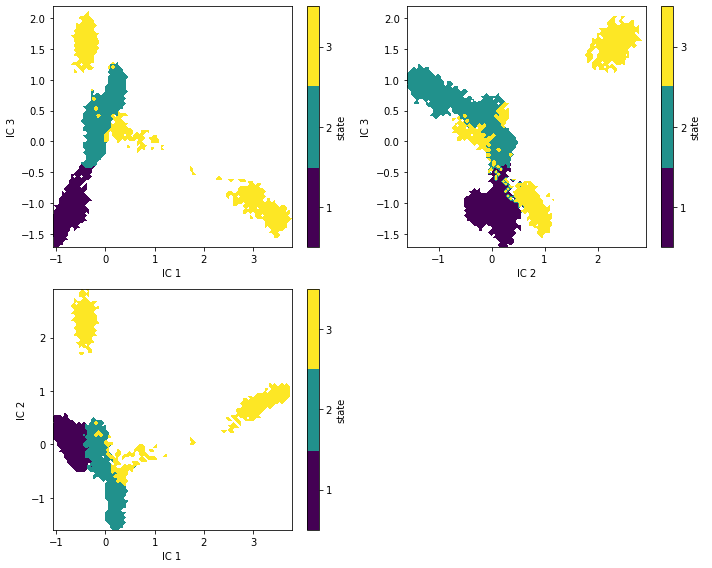

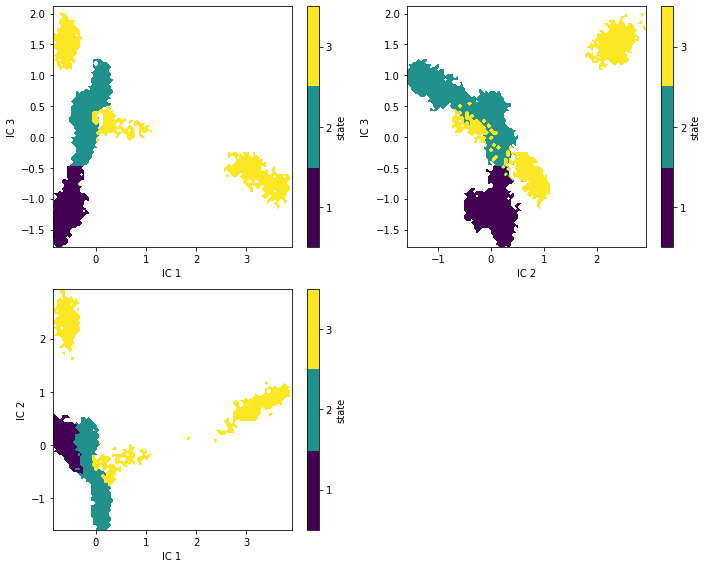

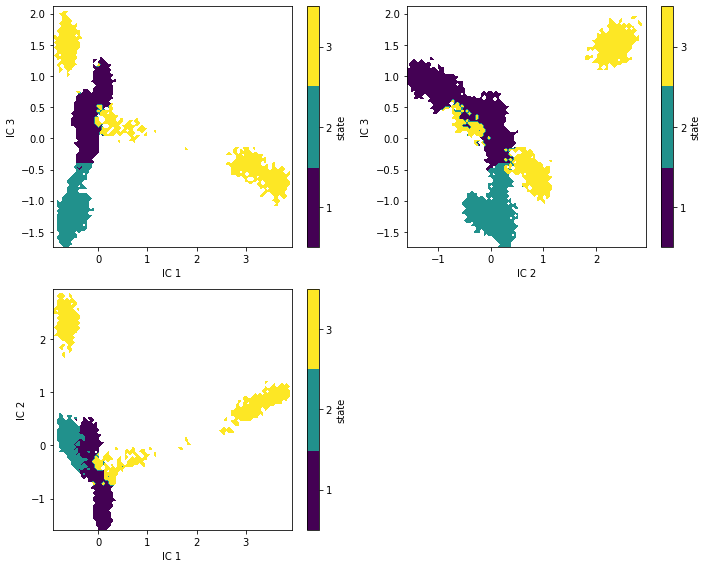

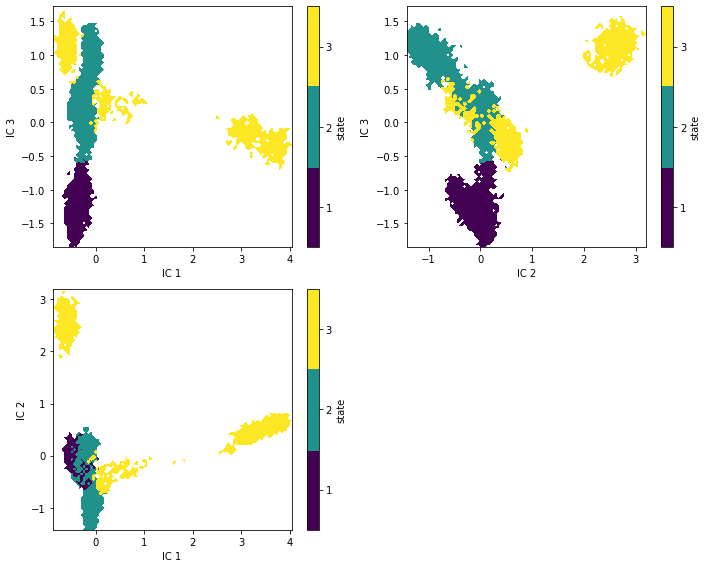

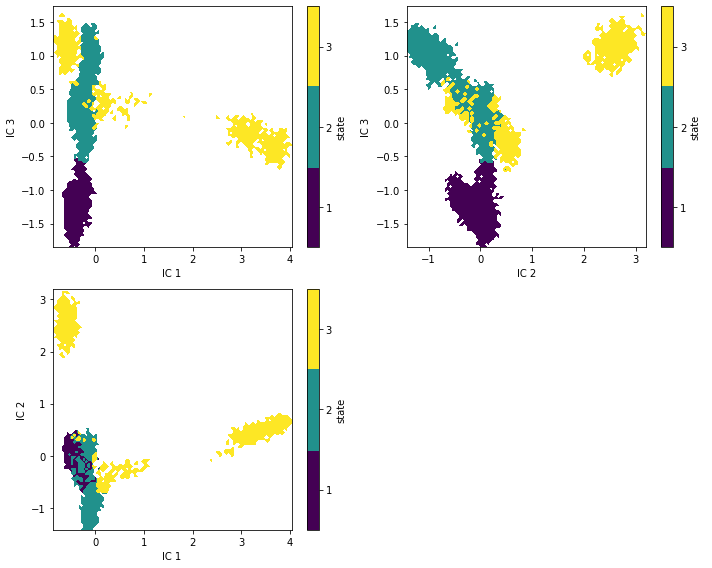

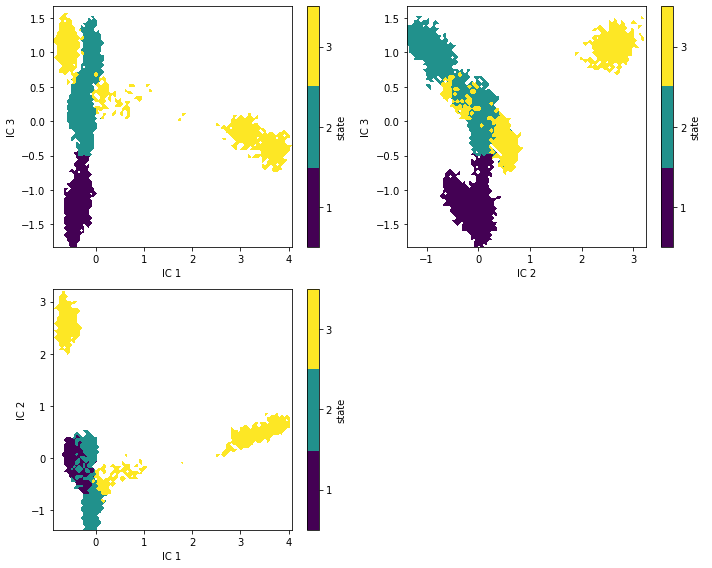

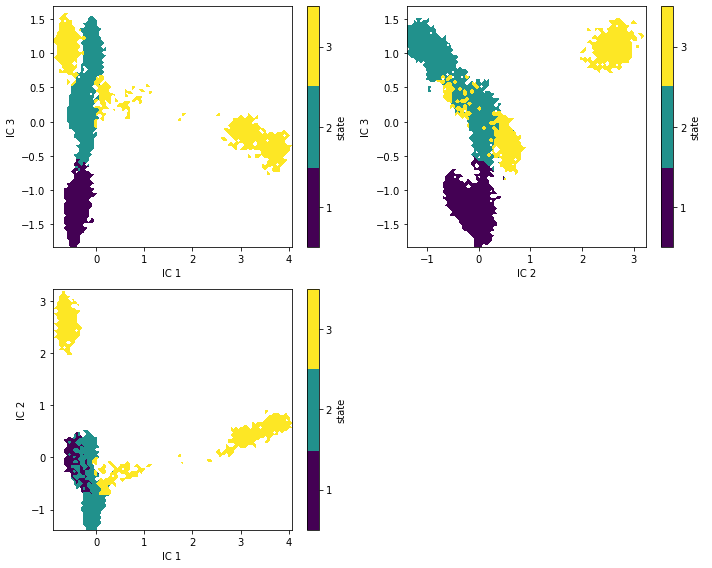

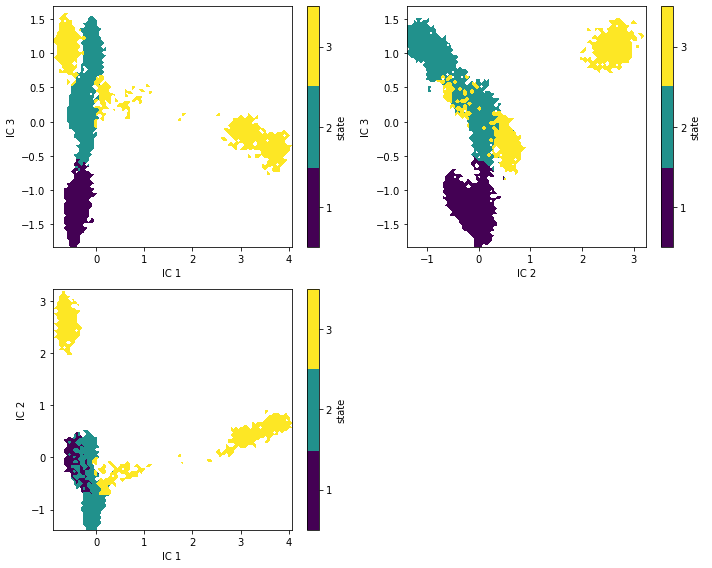

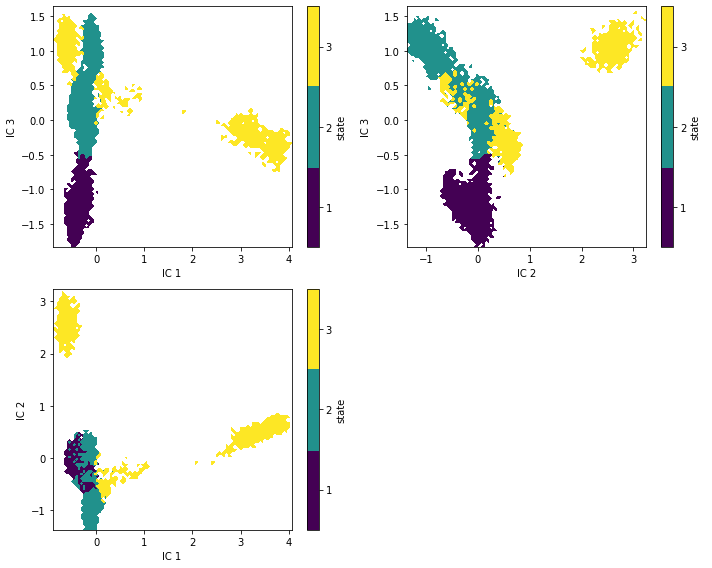

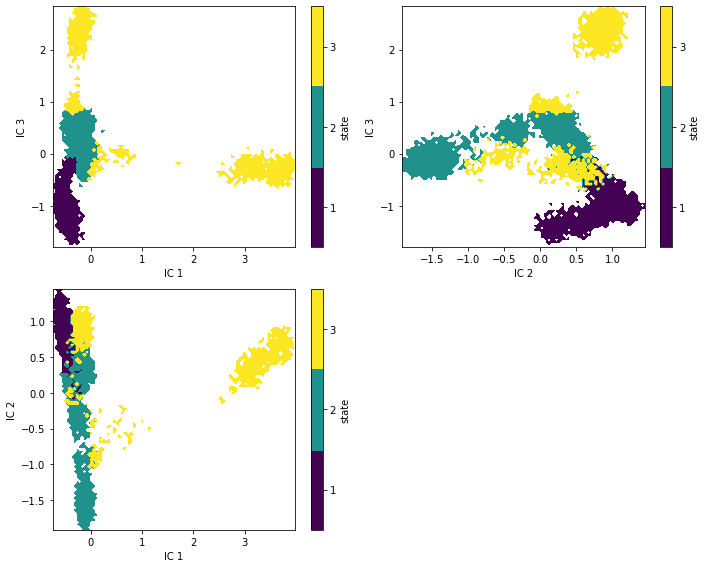

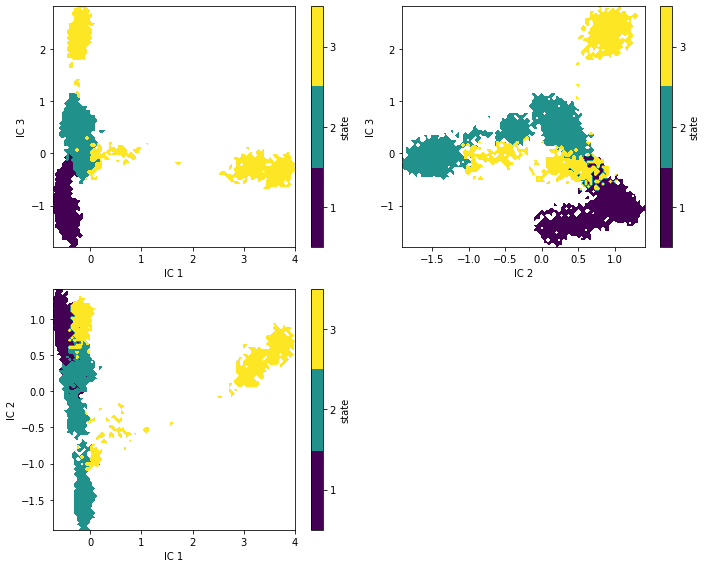

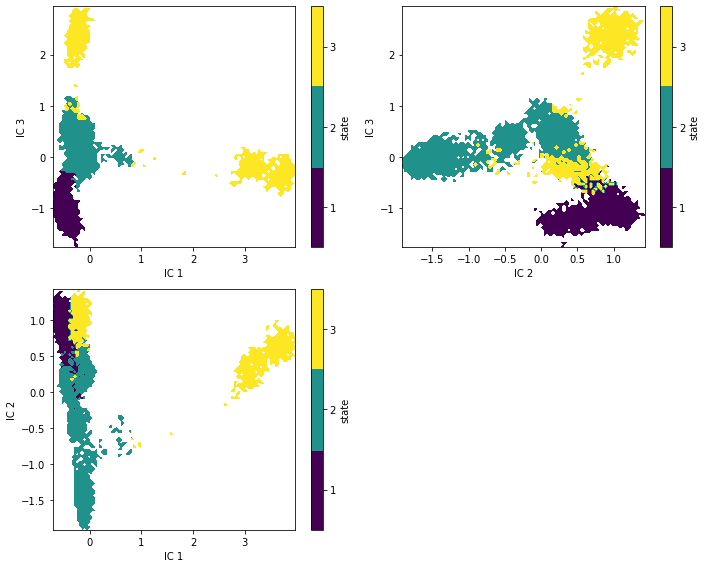

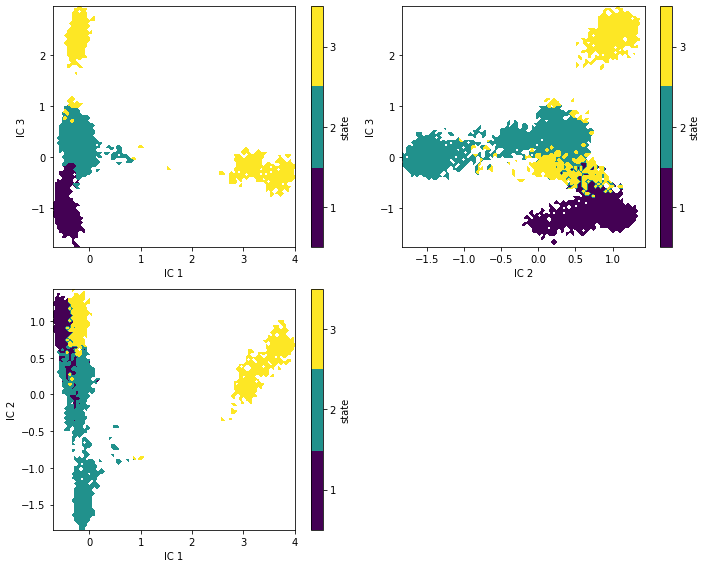

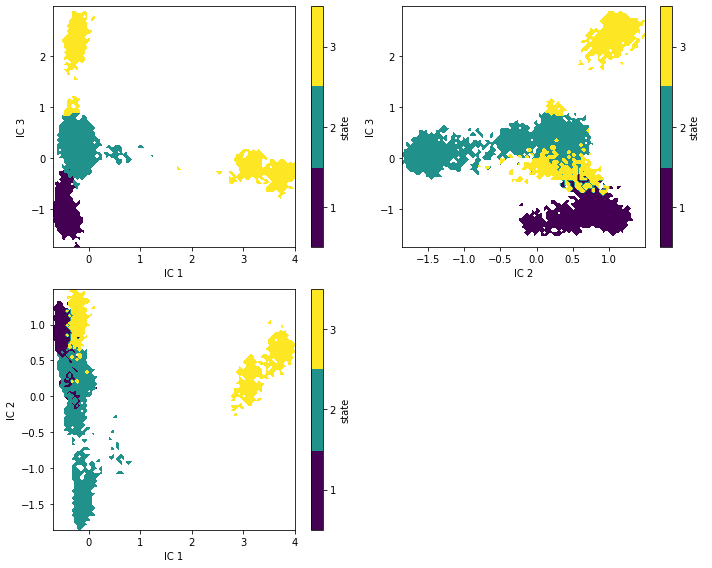

In [3]:
VAMP2(np.arange(0, 0.2, 0.005))

In [4]:
# load modules
%matplotlib inline
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
import pyemma.coordinates
from pyemma.coordinates import source
from pyemma.util.contexts import settings
from pyemma.coordinates import load

def f(x,f,s):
    
    figures_path ='figures_2'
    
    pdb=('mpro.pdb')
    traj=['mpro01.dcd','mpro02.dcd','mpro03.dcd','mpro04.dcd','mpro05.dcd','mpro06.dcd']
    torsions_feat = pyemma.coordinates.featurizer(pdb) 
    selstr=x
    torsions_feat.add_backbone_torsions(selstr, cossin=True, periodic=False)
    torsions_data=pyemma.coordinates.load(traj, features= torsions_feat)
    labels = ['backbone\ntorsions']
    
    score_phi_psi = pyemma.coordinates.vamp(torsions_data[:-1], dim=3).score(
            test_data=torsions_data[-1],
            score_method='VAMP2')
    s.append((score_phi_psi, f))
    
    #time-lagged independent component analysis (TICA)
    tica = pyemma.coordinates.tica(torsions_data, dim=3, lag=50)
    tica_output = tica.get_output()
    tica_concatenated = np.concatenate(tica_output)
    
    ##Clustering
    cluster = pyemma.coordinates.cluster_kmeans(
        tica_concatenated, k=100, max_iter=100, stride=10, fixed_seed=100)
    dtrajs_concatenated = np.concatenate(cluster.dtrajs)
    its = pyemma.msm.its(cluster.dtrajs, lags=[10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 450], nits=10, errors='bayes')

    nstates=3
    msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=50, dt_traj='1 ns', conf=0.95)
    #pyemma.plots.plot_cktest(msm.cktest(nstates));
    msm.pcca(nstates)
    #check the location of our discrete states by plotting them onto the density of our data in the first two TICA dimensions
    #The cluster centers are contained in the cluster object

    #We note that the states are well distributed in the low-dimensional TICA subspace
    def draw_panel(ax, i, j):
        _, _, misc = pyemma.plots.plot_state_map(
            *tica_concatenated[:, [i, j]].T,
            msm.metastable_assignments[dtrajs_concatenated],
            ax=ax)
        ax.set_xlabel('IC {}'.format(i + 1))
        ax.set_ylabel('IC {}'.format(j + 1))
        misc['cbar'].set_ticklabels(range(1, msm.nstates + 1))

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    try:
        draw_panel(axes[0, 0], 0, 2)
        draw_panel(axes[0, 1], 1, 2)
        draw_panel(axes[1, 0], 0, 1)
        axes[1, 1].set_axis_off()
        fig.tight_layout()
        fig.savefig(figures_path+os.path.sep+"states_{}".format(str(f))+".png")
    except:
        pass
    
    

def VAMP2(t):
    
    figures_path ='figures_2'
    
    if not os.path.exists(figures_path):
        os.mkdir(figures_path)
    
    scores=[]
    
    for threshold in t:
        pdb=('mpro.pdb')
        traj=['mpro01.dcd','mpro02.dcd','mpro03.dcd','mpro04.dcd','mpro05.dcd','mpro06.dcd']
        torsions_feat = pyemma.coordinates.featurizer(pdb) 
        selstr="resSeq 6 13 42 43 44 45 47 48 53 58 62 63 82 83 84 86 110 111 112 113 117 118 119 126 127 137 138 139 140 141 142 143 144 159 161 165 169 175 182 185 188 193 194 203 204 214 238 239 240 276 280 282 283 284 285 286 287 288 289 290 291 297 298 302 303 304 305"
        torsions_feat.add_backbone_torsions(selstr, cossin=True, periodic=False)
        torsions_data=pyemma.coordinates.load(traj, features= torsions_feat)
        labels = ['backbone\ntorsions']
        
        #time-lagged independent component analysis (TICA)
        tica = pyemma.coordinates.tica(torsions_data, dim=3, lag=50)
        tica_output = tica.get_output()
        tica_concatenated = np.concatenate(tica_output)
        
        C = tica.feature_TIC_correlation
        df = pd.DataFrame(C[:,:3], columns=['IC1','IC2','IC3'])
        p=[]
        for j in torsions_feat.describe():
            a = re.findall(r'(?<=\s)\d+(?=\))',j) #το έκανα αυτό γιατί παρατήρησα οτι κάποιες φορές οι θέσεις είναι ανακατεμένες
            p.append(int(a[0]))
        df['pos']=p
        DF3 = df[~(df['IC1']<=threshold) | ~(df['IC1']>=-threshold)]
        DF3 = DF3[~(DF3['IC2']<=threshold) | ~(DF3['IC2']>=-threshold)] 
        DF3 = DF3[~(DF3['IC3']<=threshold) | ~(DF3['IC3']>=-threshold)] 
        
        pos_IC1_2_3 = 'resSeq '
        for k in DF3['pos']:
            if str(k) not in pos_IC1_2_3:
                pos_IC1_2_3 += str(k)+' '
        f(pos_IC1_2_3,threshold,scores)
    print(scores)

100%|██████████| 12/12 [00:04<00:00,  2.79it/s]                        
1376it [00:00, 5626.00it/s]                                                                                                          
100%|██████████| 12/12 [00:04<00:00,  2.71it/s]                        
1376it [00:00, 6105.17it/s]                                                                                                          
100%|██████████| 12/12 [00:04<00:00,  2.82it/s]                        
1376it [00:00, 5855.78it/s]                                                                                                          
100%|██████████| 12/12 [00:04<00:00,  2.82it/s]                        
1376it [00:00, 5841.37it/s]                                                                                                          
100%|██████████| 12/12 [00:04<00:00,  2.93it/s]                        
1376it [00:00, 6398.64it/s]                                                                             

[(1.6983460729301583, 0.0), (1.6983460729301583, 0.005), (1.6983460729301583, 0.01), (1.6983460729301583, 0.015), (1.6983460729301583, 0.02), (1.6983460729301583, 0.025), (1.6983460729301583, 0.03), (1.6983460729301583, 0.035), (1.6983460729301583, 0.04), (1.7010234981643715, 0.045), (1.7105686855091973, 0.05), (1.711399911719834, 0.055), (1.7141645323376515, 0.06), (1.7178489724768526, 0.065), (1.7080452112392508, 0.07), (1.7048902084497923, 0.075), (1.7042352049378129, 0.08), (1.7042352049378129, 0.085), (1.6635842611368377, 0.09), (1.686007608673446, 0.095), (1.686007608673446, 0.1), (1.6826834412442198, 0.105), (1.6961476088305445, 0.11), (1.6882828726149173, 0.115), (1.6909395987712466, 0.12), (1.710547526544754, 0.125), (1.710547526544754, 0.13), (1.7190294927704146, 0.135), (1.7190294927704146, 0.14), (1.7539953908698926, 0.145), (1.7464291434703019, 0.15), (1.7464291434703019, 0.155), (1.7464291434703019, 0.16), (1.7491326269751784, 0.165), (1.7491326269751784, 0.17), (1.799527

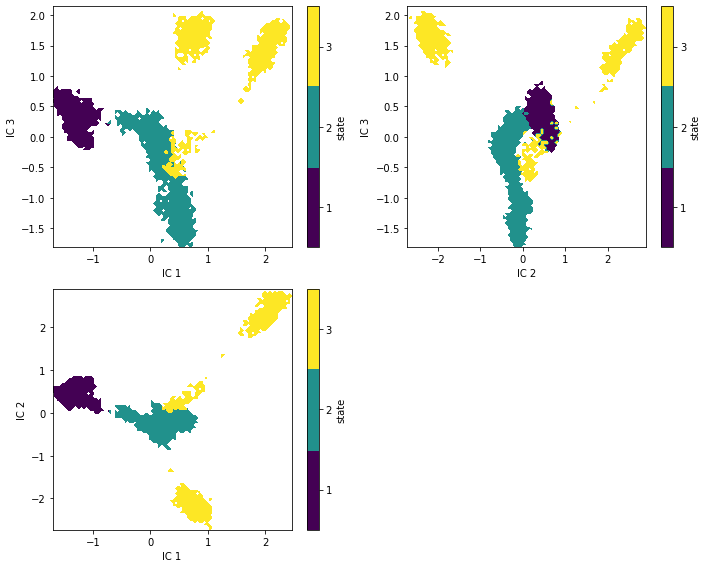

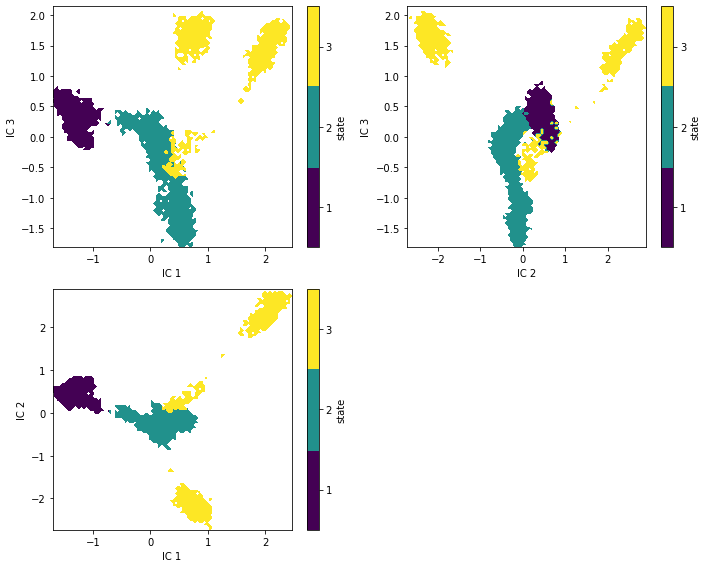

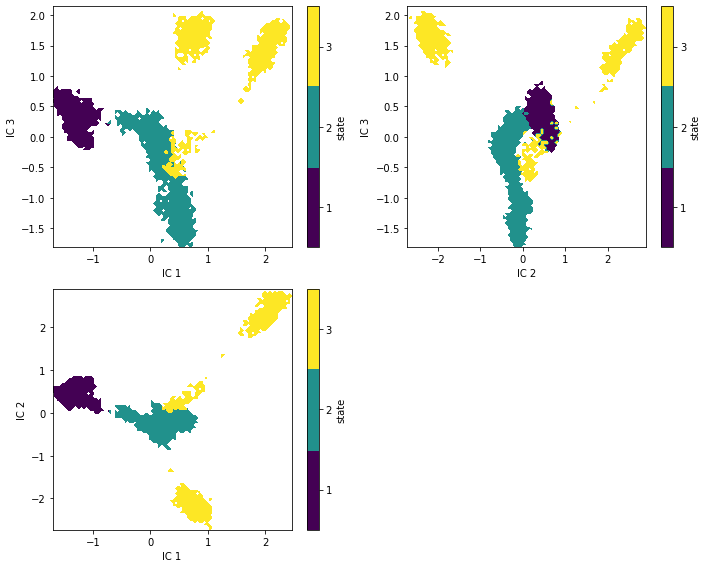

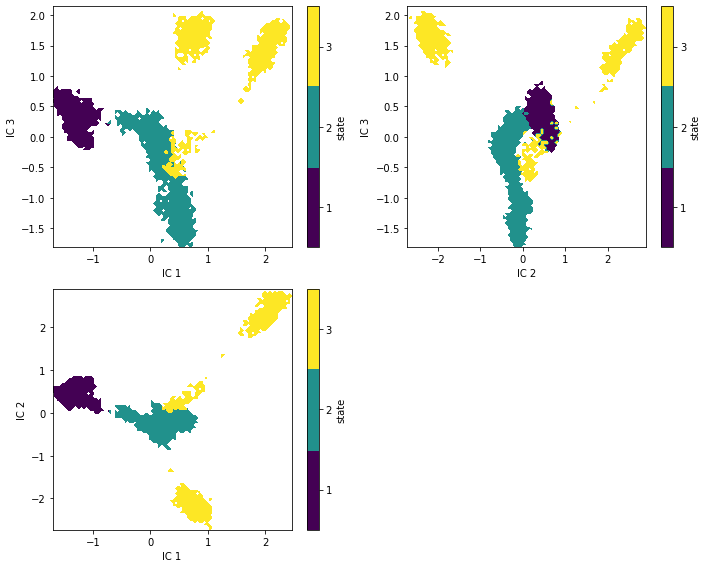

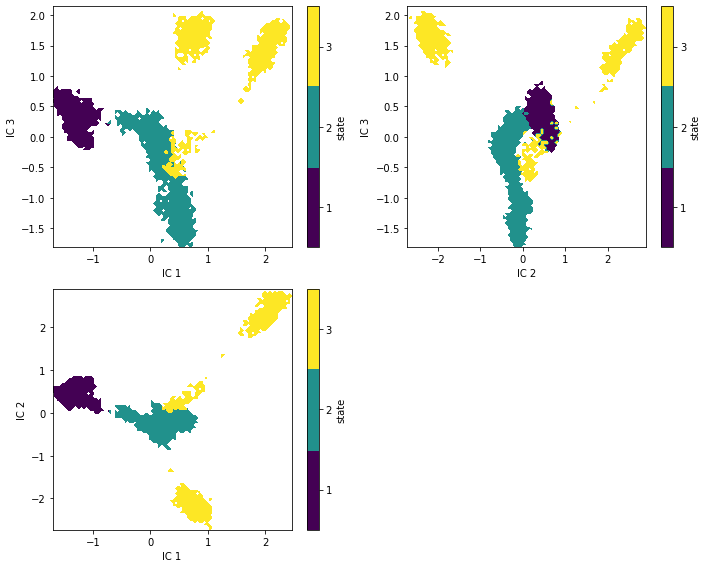

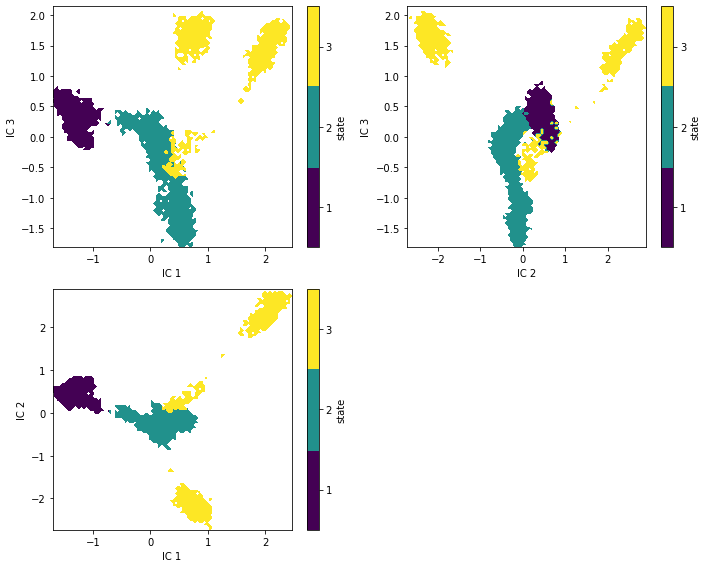

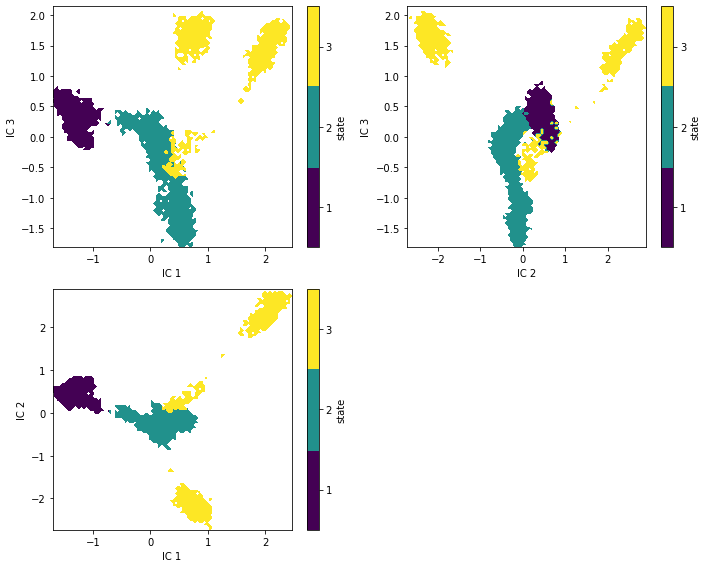

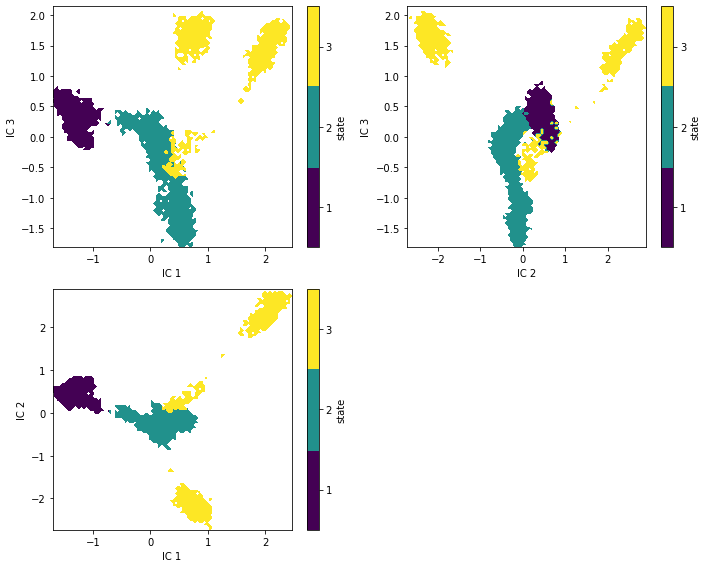

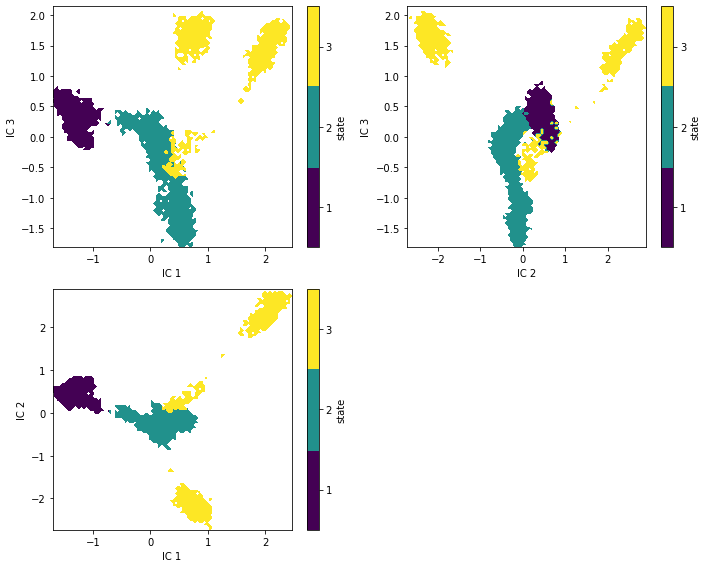

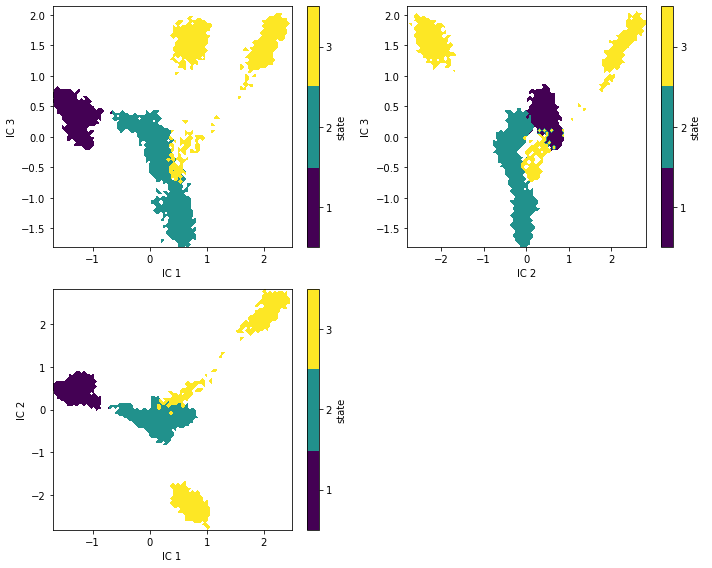

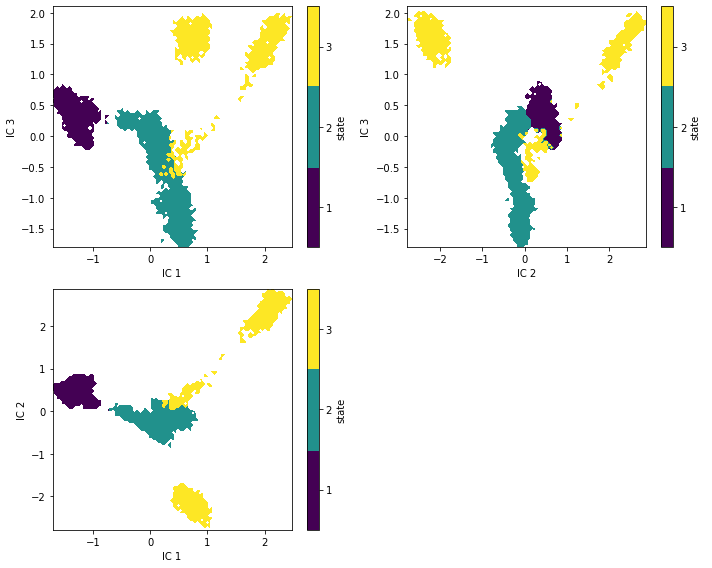

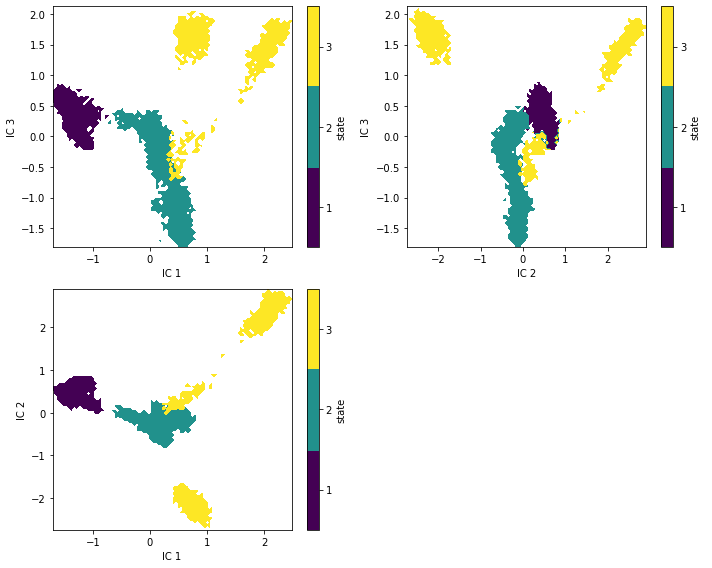

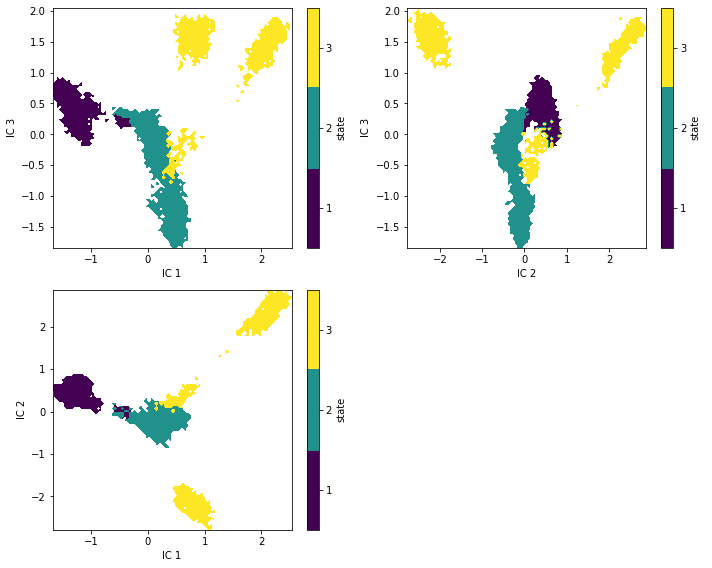

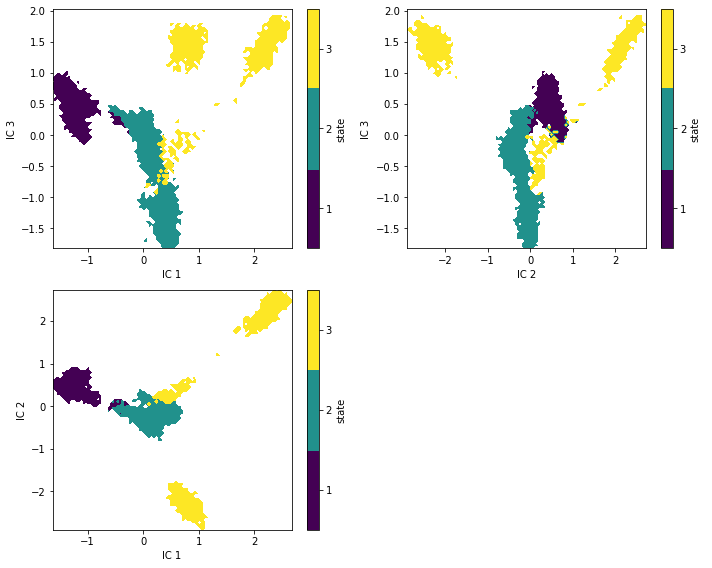

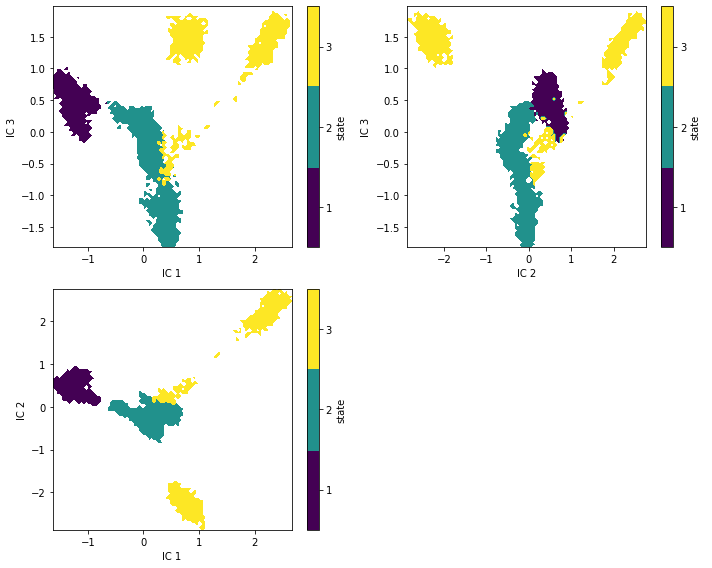

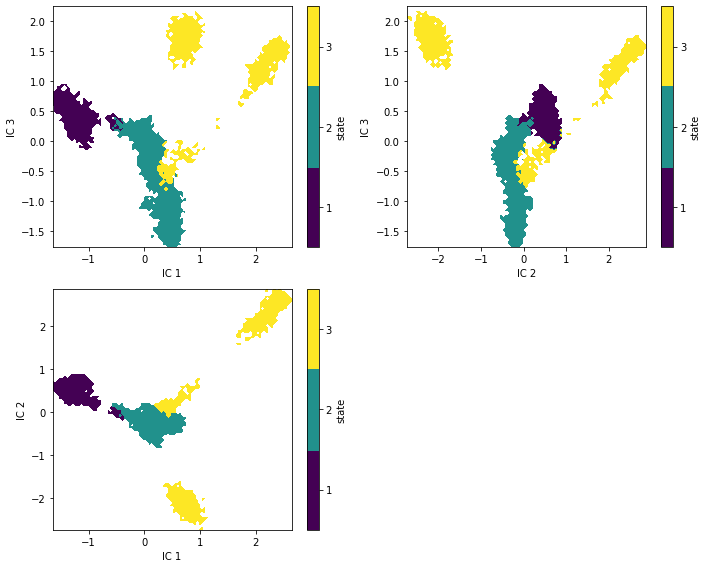

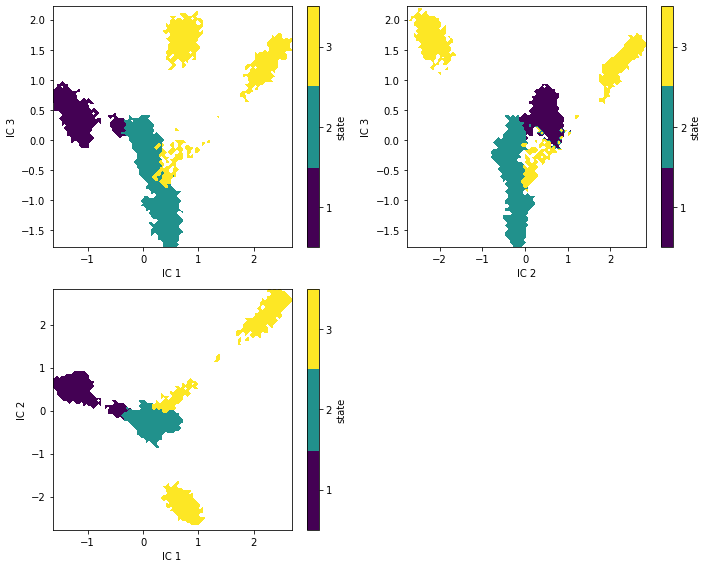

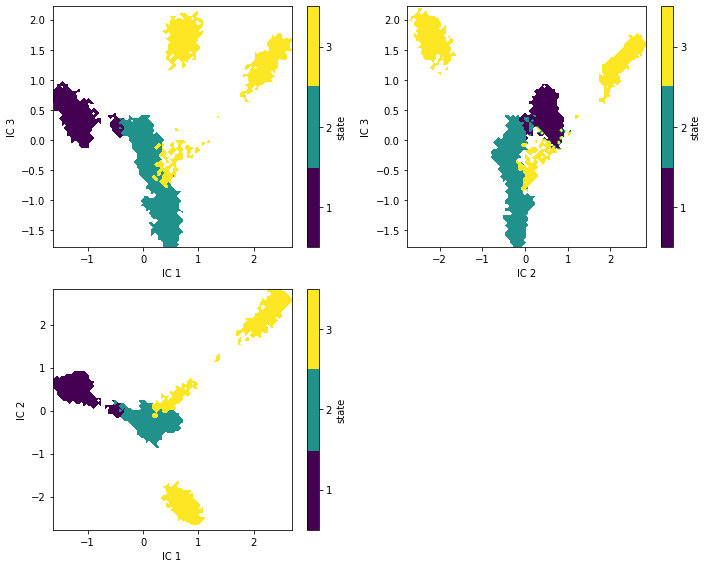

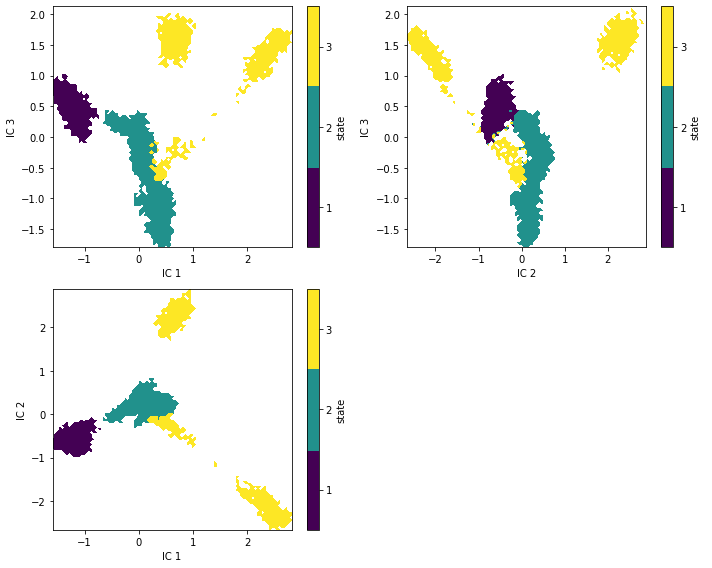

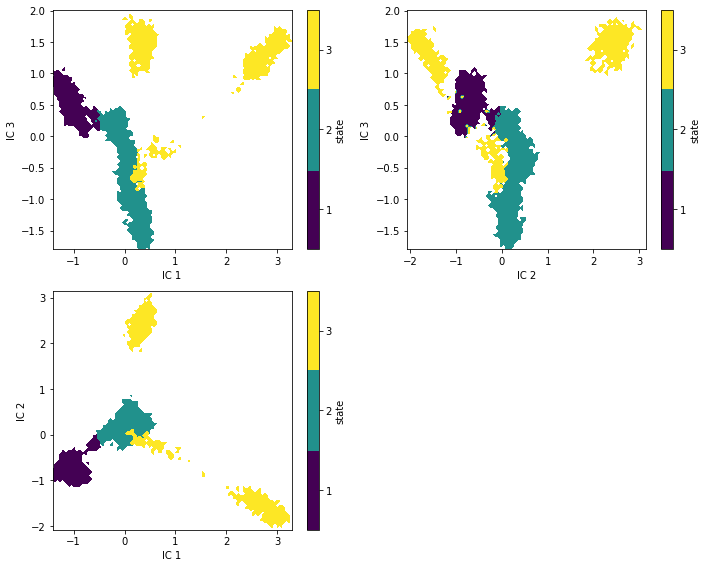

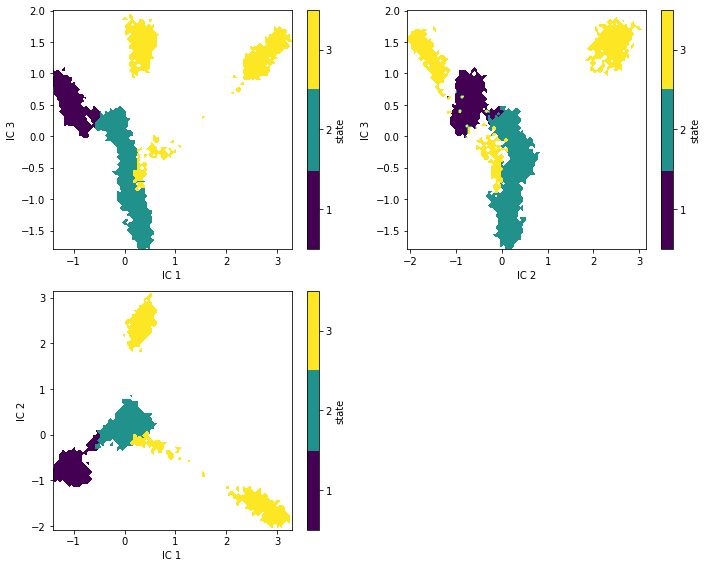

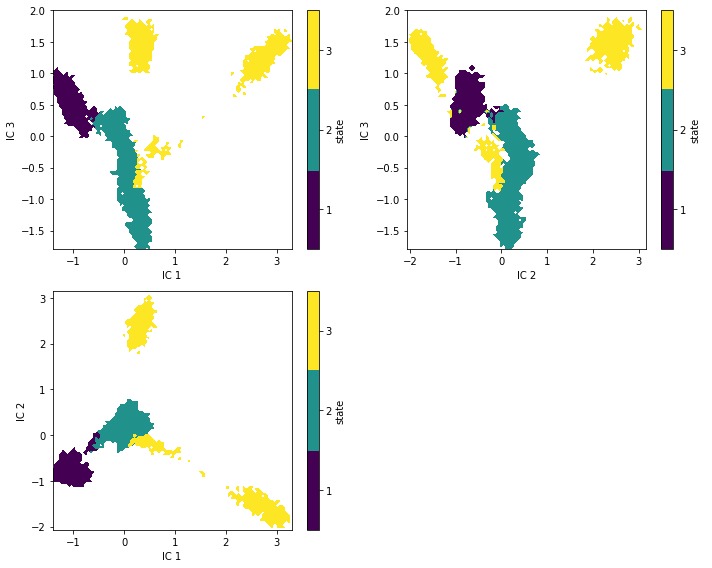

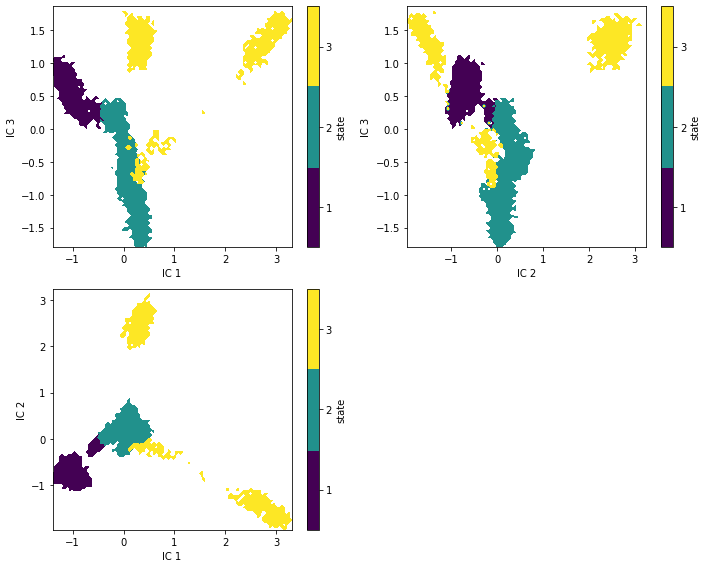

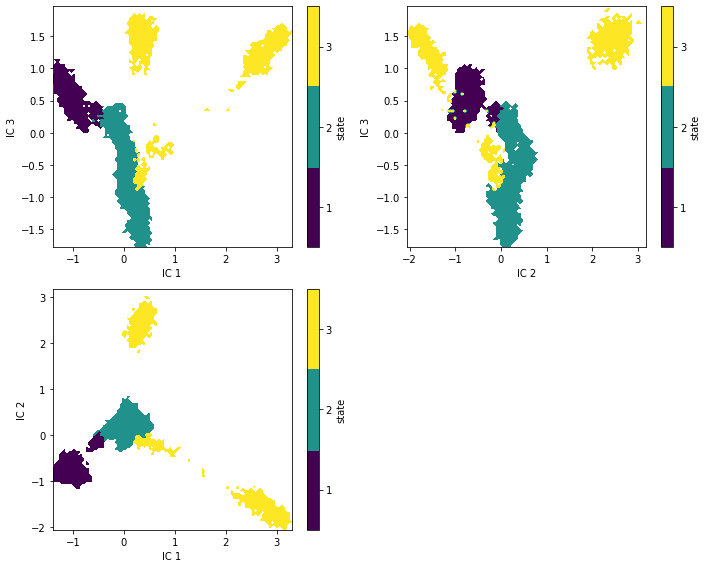

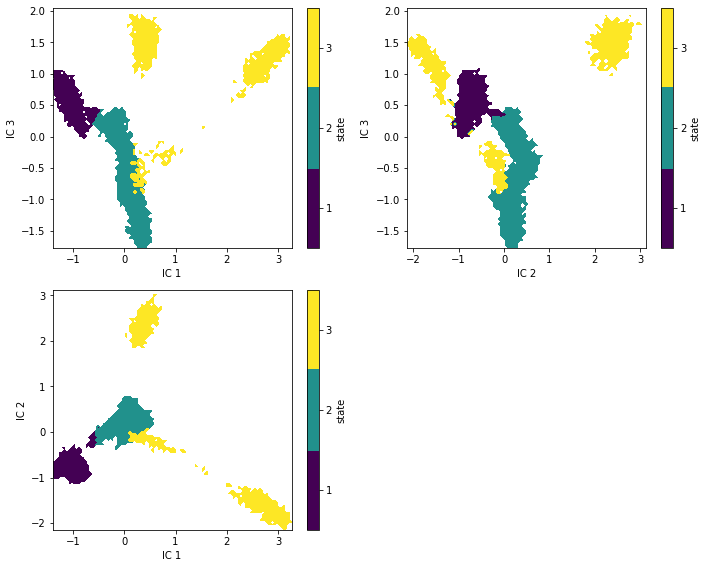

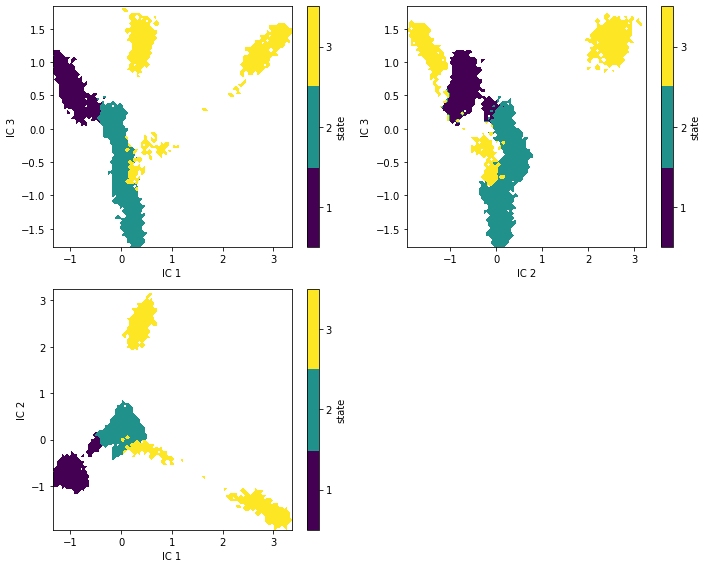

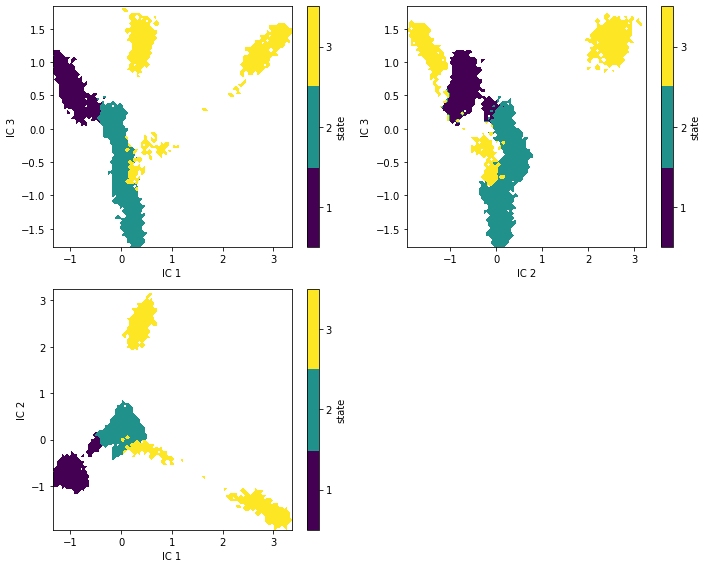

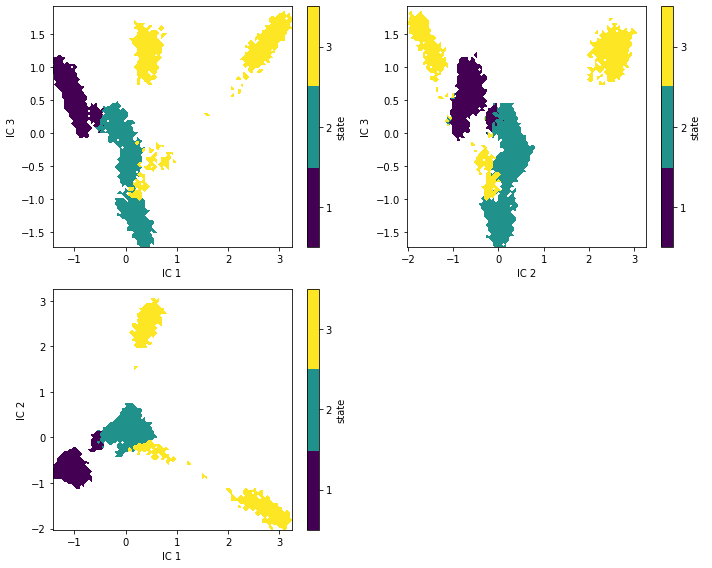

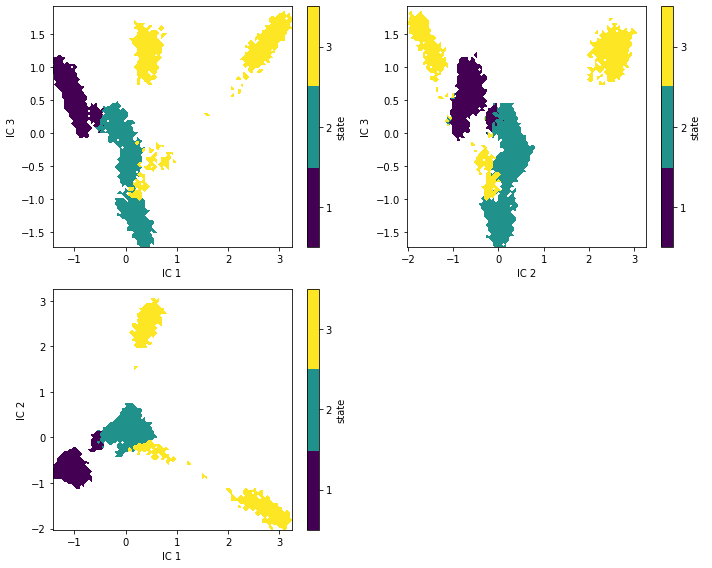

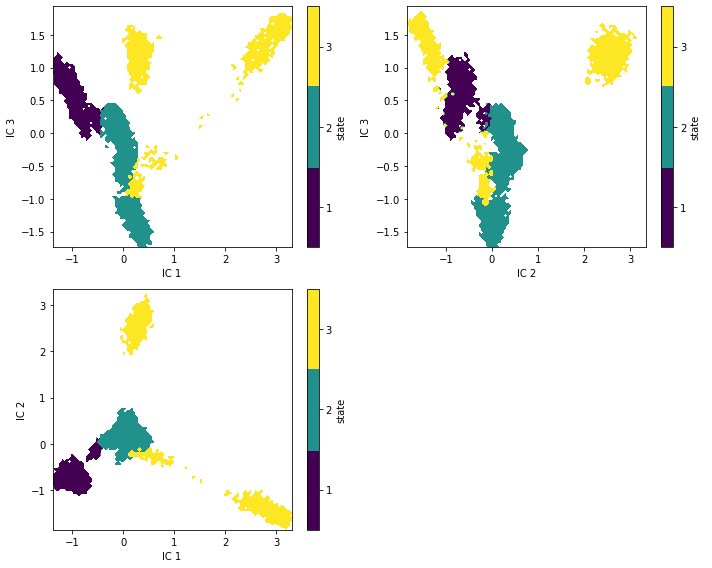

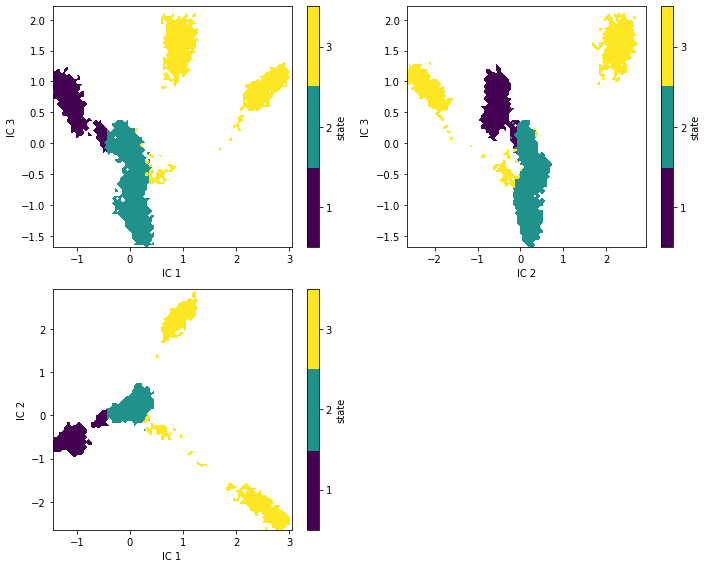

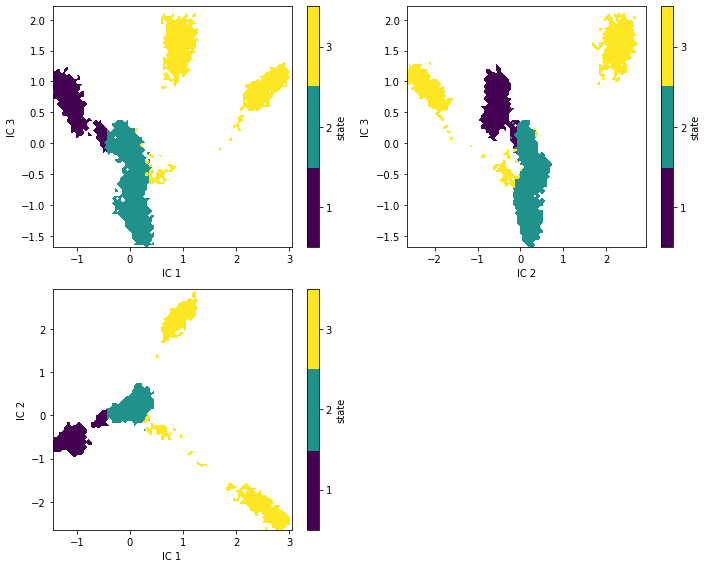

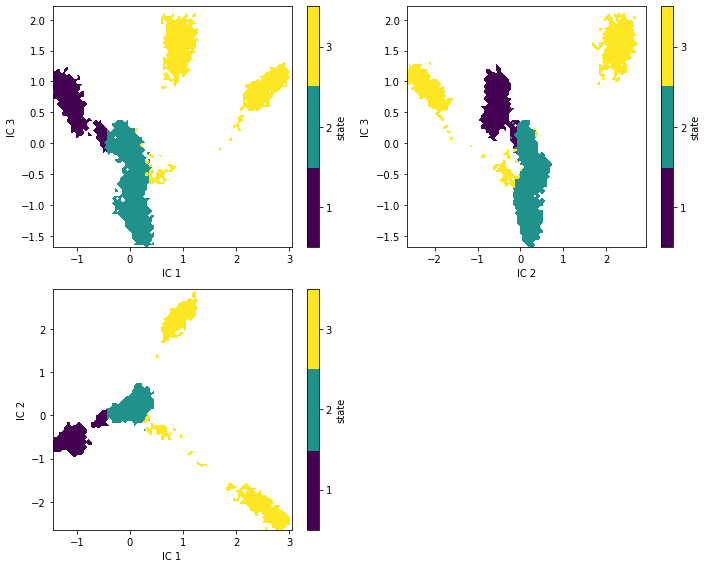

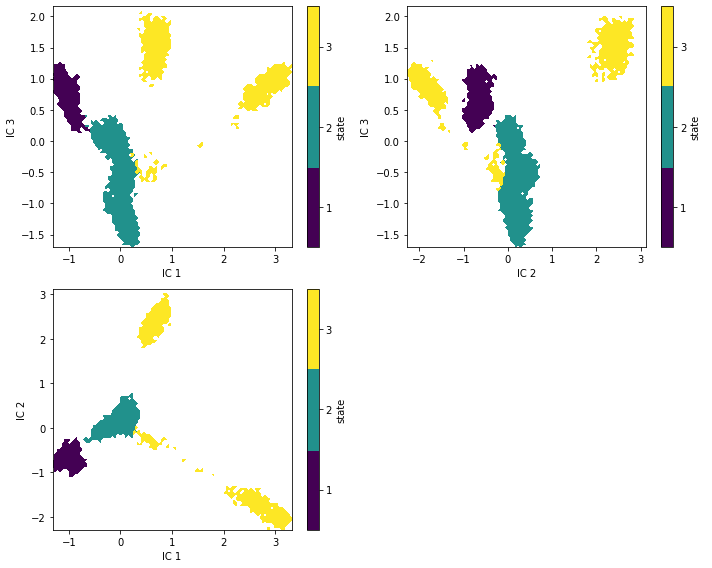

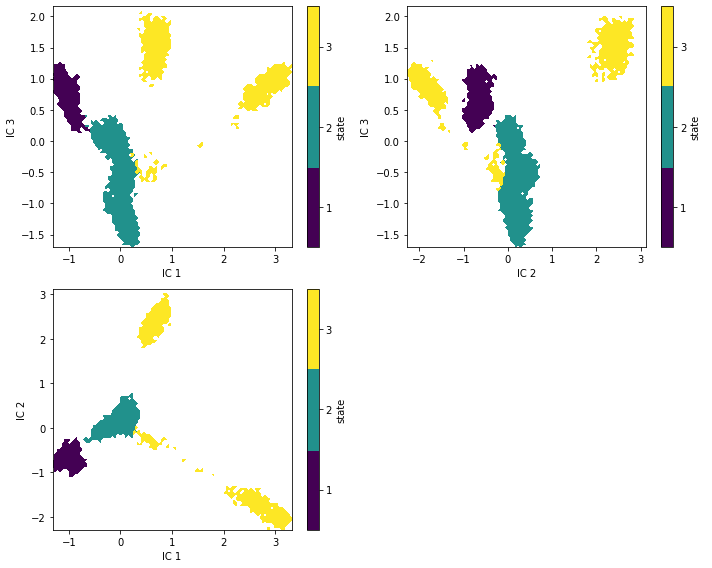

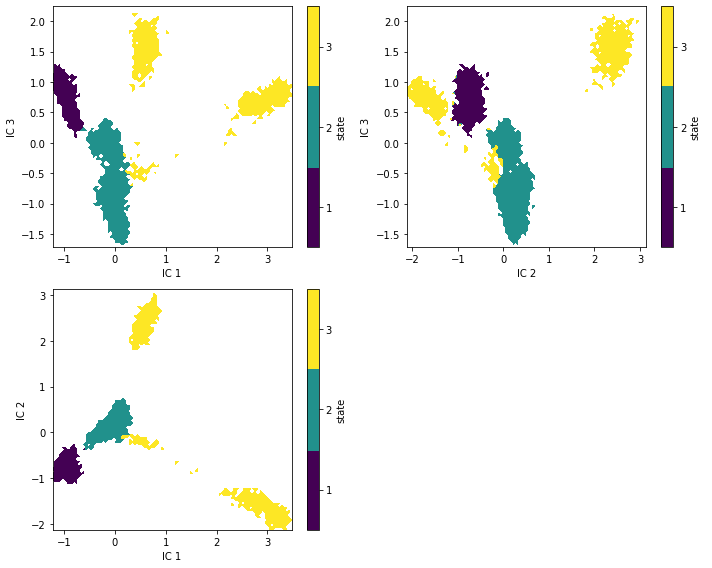

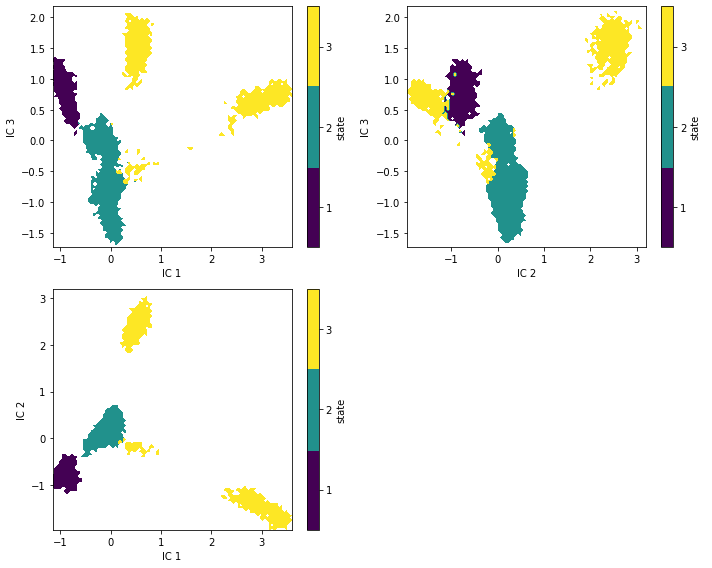

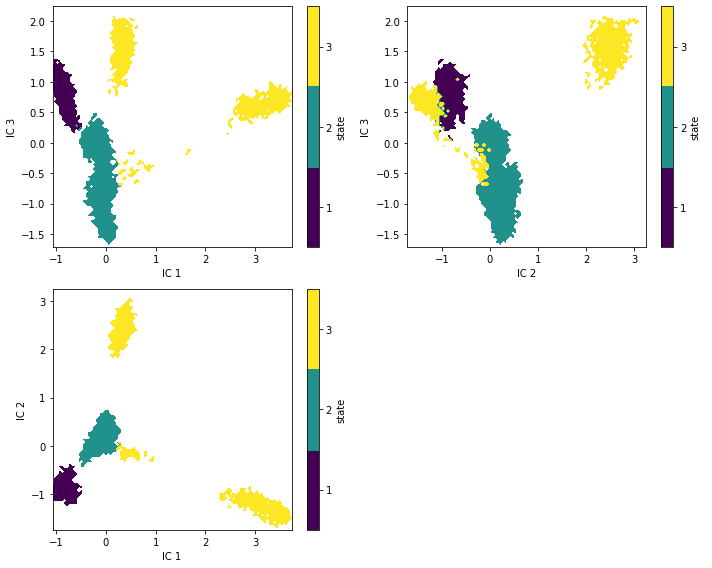

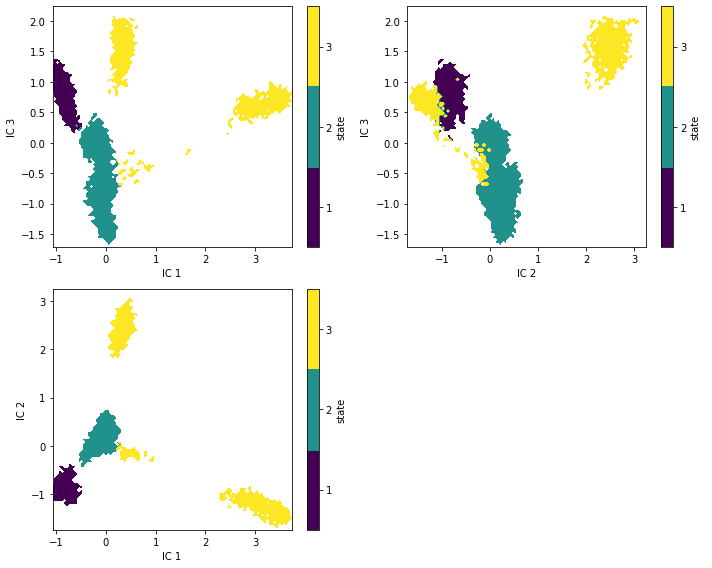

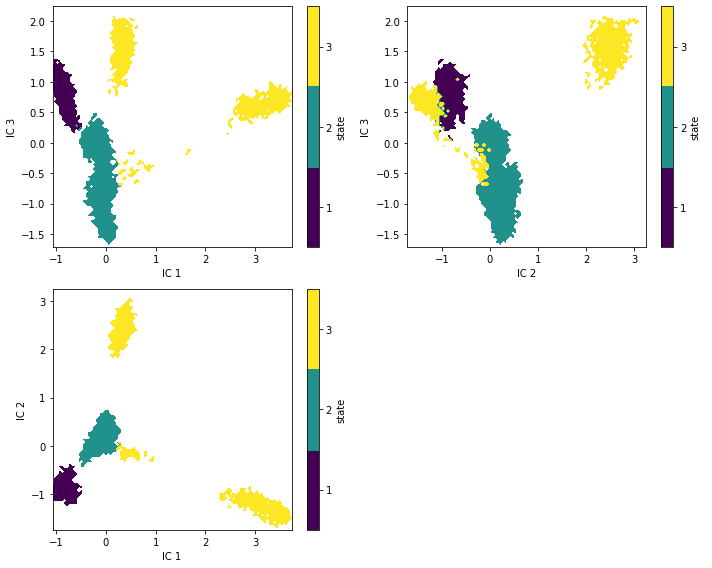

In [5]:
VAMP2(np.arange(0, 0.2, 0.005))

In [6]:
# load modules
%matplotlib inline
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
import pyemma.coordinates
from pyemma.coordinates import source
from pyemma.util.contexts import settings
from pyemma.coordinates import load

def f(x,f,s):
    
    figures_path ='figures_3'
    
    pdb=('mpro.pdb')
    traj=['mpro01.dcd','mpro02.dcd','mpro03.dcd','mpro04.dcd','mpro05.dcd','mpro06.dcd']
    torsions_feat = pyemma.coordinates.featurizer(pdb) 
    selstr=x
    torsions_feat.add_backbone_torsions(selstr, cossin=True, periodic=False)
    torsions_data=pyemma.coordinates.load(traj, features= torsions_feat)
    labels = ['backbone\ntorsions']
    
    score_phi_psi = pyemma.coordinates.vamp(torsions_data[:-1], dim=3).score(
            test_data=torsions_data[-1],
            score_method='VAMP2')
    s.append((score_phi_psi, f))
    
    #time-lagged independent component analysis (TICA)
    tica = pyemma.coordinates.tica(torsions_data, dim=3, lag=50)
    tica_output = tica.get_output()
    tica_concatenated = np.concatenate(tica_output)
    
    ##Clustering
    cluster = pyemma.coordinates.cluster_kmeans(
        tica_concatenated, k=100, max_iter=100, stride=10, fixed_seed=100)
    dtrajs_concatenated = np.concatenate(cluster.dtrajs)
    its = pyemma.msm.its(cluster.dtrajs, lags=[10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 450], nits=10, errors='bayes')

    nstates=3
    msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=50, dt_traj='1 ns', conf=0.95)
    #pyemma.plots.plot_cktest(msm.cktest(nstates));
    msm.pcca(nstates)
    #check the location of our discrete states by plotting them onto the density of our data in the first two TICA dimensions
    #The cluster centers are contained in the cluster object

    #We note that the states are well distributed in the low-dimensional TICA subspace
    def draw_panel(ax, i, j):
        _, _, misc = pyemma.plots.plot_state_map(
            *tica_concatenated[:, [i, j]].T,
            msm.metastable_assignments[dtrajs_concatenated],
            ax=ax)
        ax.set_xlabel('IC {}'.format(i + 1))
        ax.set_ylabel('IC {}'.format(j + 1))
        misc['cbar'].set_ticklabels(range(1, msm.nstates + 1))

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    try:
        draw_panel(axes[0, 0], 0, 2)
        draw_panel(axes[0, 1], 1, 2)
        draw_panel(axes[1, 0], 0, 1)
        axes[1, 1].set_axis_off()
        fig.tight_layout()
        fig.savefig(figures_path+os.path.sep+"states_{}".format(str(f))+".png")
    except:
        pass
    
    

def VAMP2(t):
    
    figures_path ='figures_3'
    
    if not os.path.exists(figures_path):
        os.mkdir(figures_path)
    
    scores=[]
    
    for threshold in t:
        pdb=('mpro.pdb')
        traj=['mpro01.dcd','mpro02.dcd','mpro03.dcd','mpro04.dcd','mpro05.dcd','mpro06.dcd']
        torsions_feat = pyemma.coordinates.featurizer(pdb) 
        selstr="resSeq 43 44 47 48 53 62 82 83 84 111 112 118 127 137 138 139 141 144 159 182 193 238 239 240 280 286 287 288 289 290 291 297 304 "
        torsions_feat.add_backbone_torsions(selstr, cossin=True, periodic=False)
        torsions_data=pyemma.coordinates.load(traj, features= torsions_feat)
        labels = ['backbone\ntorsions']
        
        #time-lagged independent component analysis (TICA)
        tica = pyemma.coordinates.tica(torsions_data, dim=3, lag=50)
        tica_output = tica.get_output()
        tica_concatenated = np.concatenate(tica_output)
        
        C = tica.feature_TIC_correlation
        df = pd.DataFrame(C[:,:3], columns=['IC1','IC2','IC3'])
        p=[]
        for j in torsions_feat.describe():
            a = re.findall(r'(?<=\s)\d+(?=\))',j) #το έκανα αυτό γιατί παρατήρησα οτι κάποιες φορές οι θέσεις είναι ανακατεμένες
            p.append(int(a[0]))
        df['pos']=p
        DF3 = df[~(df['IC1']<=threshold) | ~(df['IC1']>=-threshold)]
        DF3 = DF3[~(DF3['IC2']<=threshold) | ~(DF3['IC2']>=-threshold)] 
        DF3 = DF3[~(DF3['IC3']<=threshold) | ~(DF3['IC3']>=-threshold)] 
        
        pos_IC1_2_3 = 'resSeq '
        for k in DF3['pos']:
            if str(k) not in pos_IC1_2_3:
                pos_IC1_2_3 += str(k)+' '
        f(pos_IC1_2_3,threshold,scores)
    print(scores)

100%|██████████| 12/12 [00:04<00:00,  2.92it/s]                        
1792it [00:00, 7977.80it/s]                                                                                                            
100%|██████████| 12/12 [00:03<00:00,  3.28it/s]                       
1744it [00:00, 7855.12it/s]                                                                                                            
100%|██████████| 12/12 [00:03<00:00,  3.11it/s]                       
1744it [00:00, 7488.56it/s]                                                                                                            
100%|██████████| 12/12 [00:04<00:00,  2.66it/s]                        
1792it [00:00, 7853.01it/s]                                                                                                            
100%|██████████| 12/12 [00:04<00:00,  2.55it/s]                        
1792it [00:00, 7219.57it/s]                                                                       

[(1.8036596142805537, 0.0), (1.8036596142805537, 0.005), (1.8036596142805537, 0.01), (1.8036596142805537, 0.015), (1.8036596142805537, 0.02), (1.8036596142805537, 0.025), (1.8036596142805537, 0.03), (1.8036596142805537, 0.035), (1.8036596142805537, 0.04), (1.8106286168129664, 0.045), (1.8106286168129664, 0.05), (1.8106286168129664, 0.055), (1.8106286168129664, 0.06), (1.8106286168129664, 0.065), (1.7746143193366262, 0.07), (1.7746143193366262, 0.075), (1.7710370987323507, 0.08), (1.7710370987323507, 0.085), (1.7702974596189298, 0.09), (1.7702974596189298, 0.095), (1.78465537073141, 0.1), (1.78465537073141, 0.105), (1.7773208384509918, 0.11), (1.7773208384509918, 0.115), (1.7773208384509918, 0.12), (1.8488008830295044, 0.125), (1.8488008830295044, 0.13), (1.8053324773388308, 0.135), (1.8053324773388308, 0.14), (1.8297608261132081, 0.145), (1.8297608261132081, 0.15), (1.8297608261132081, 0.155), (1.8297608261132081, 0.16), (1.5734788332438518, 0.165), (1.5683195102181955, 0.17), (1.57805

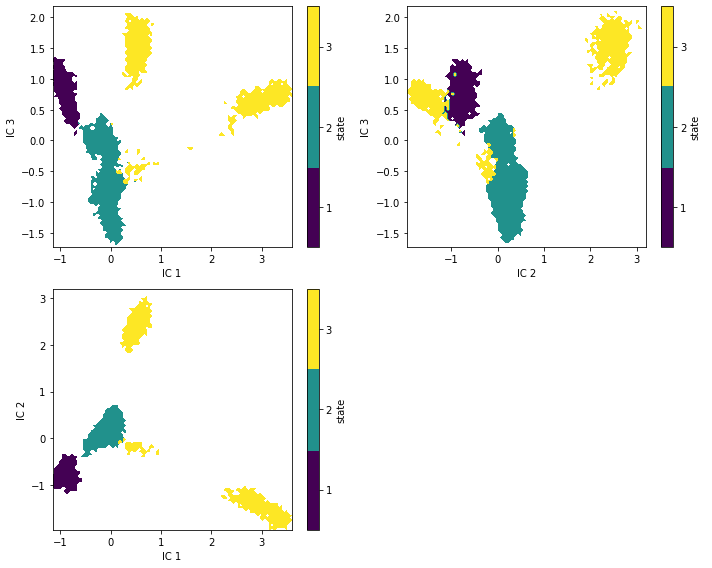

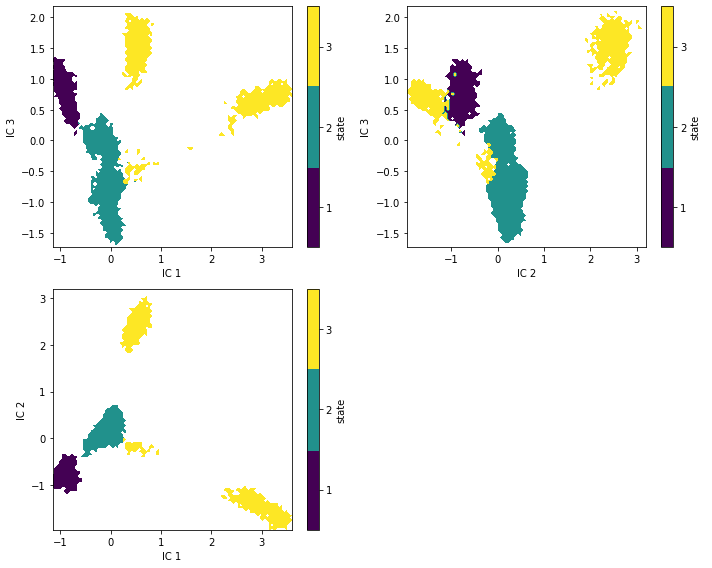

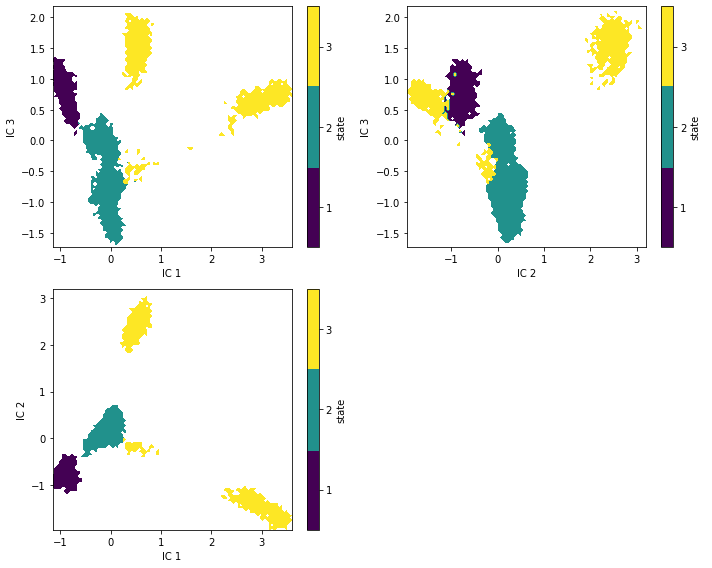

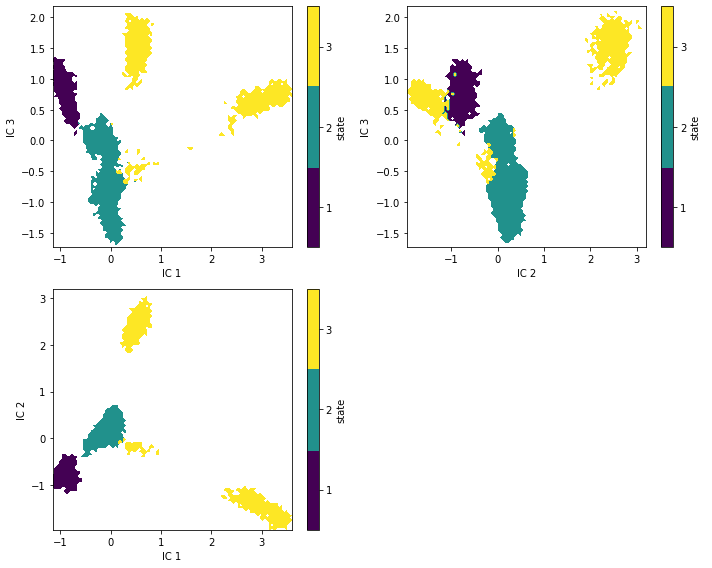

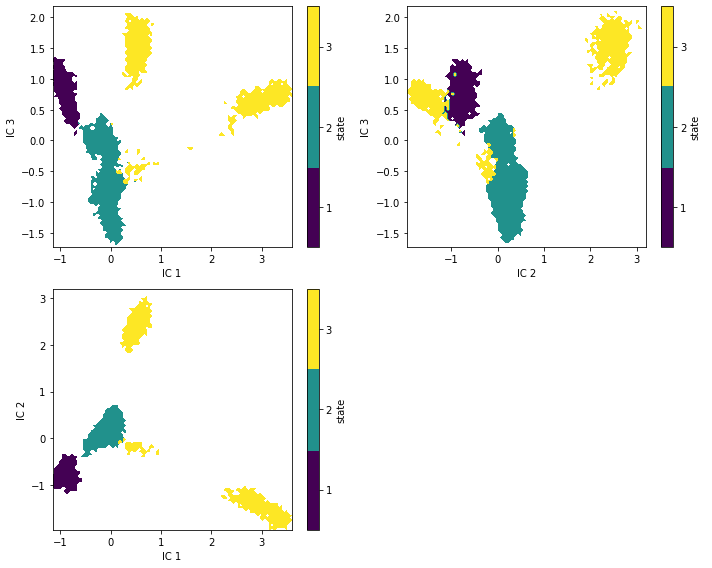

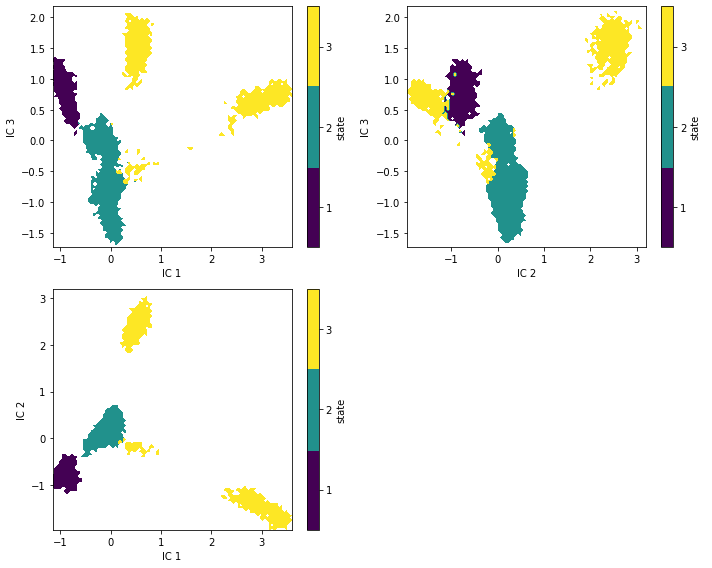

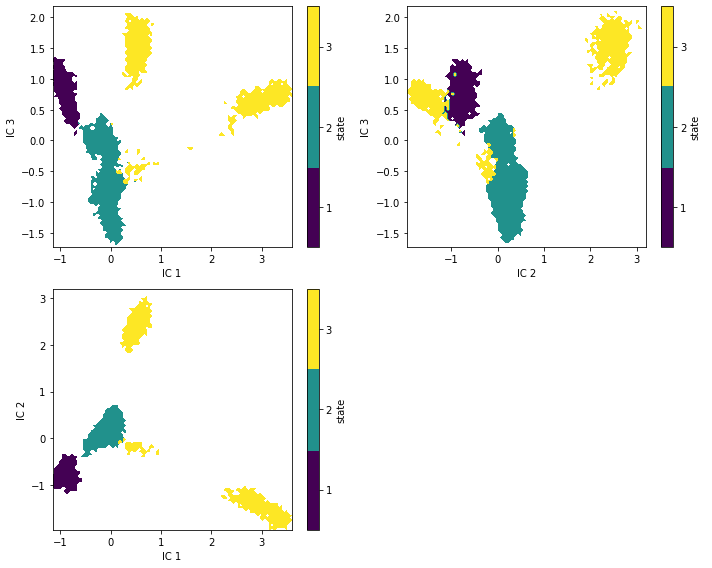

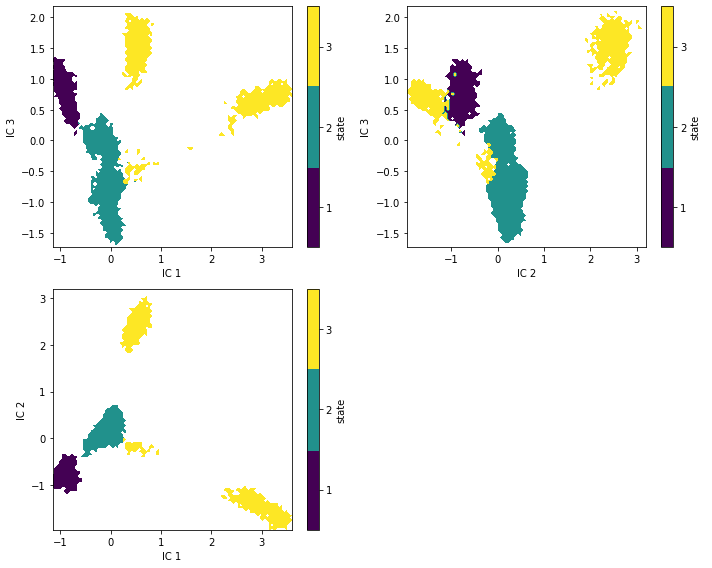

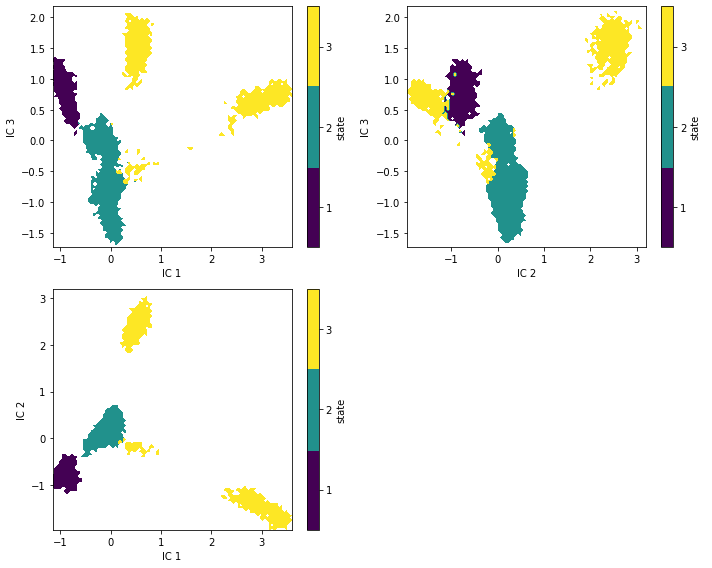

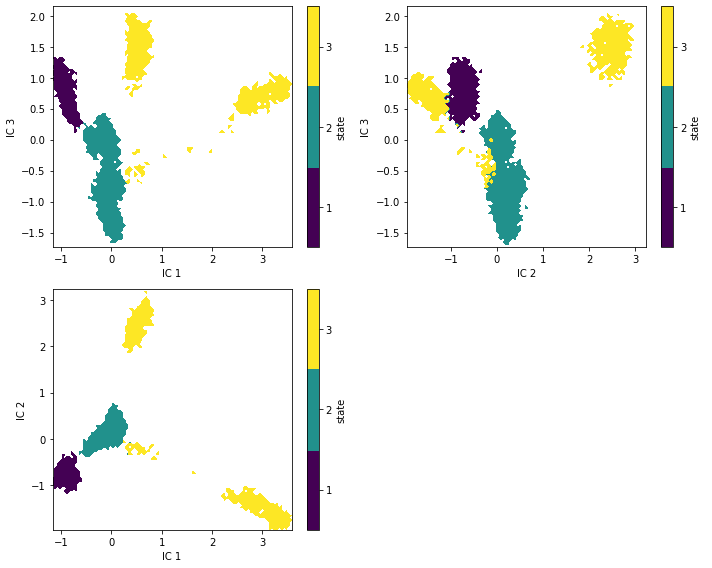

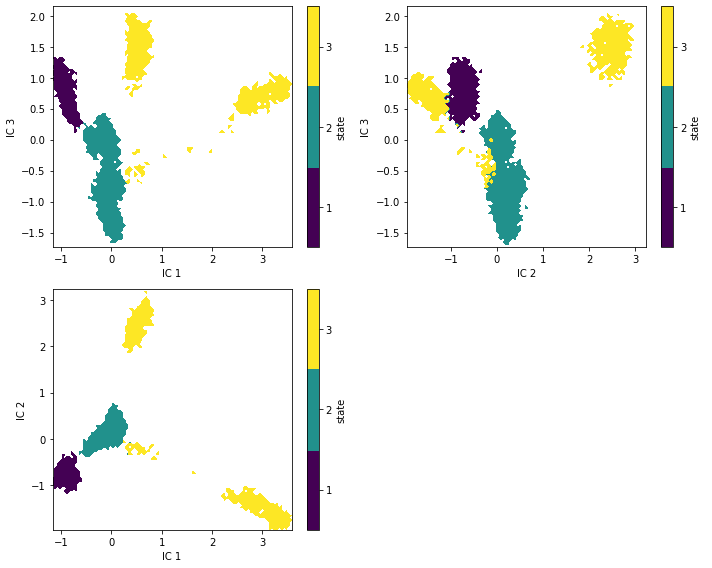

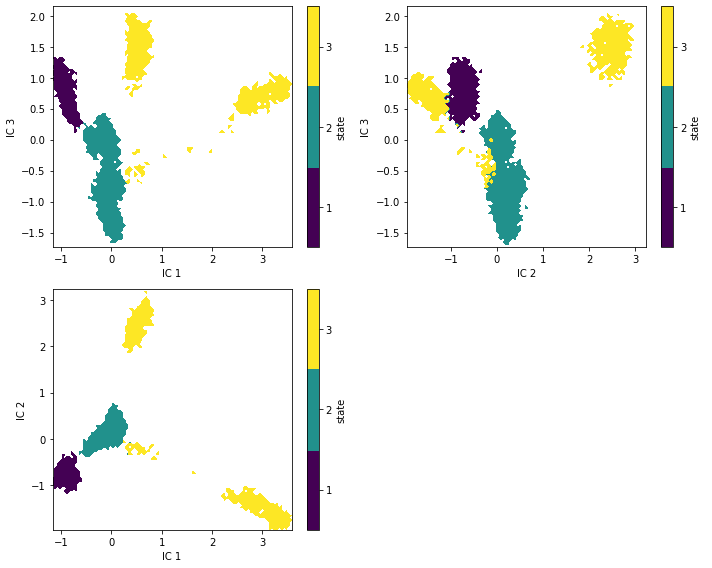

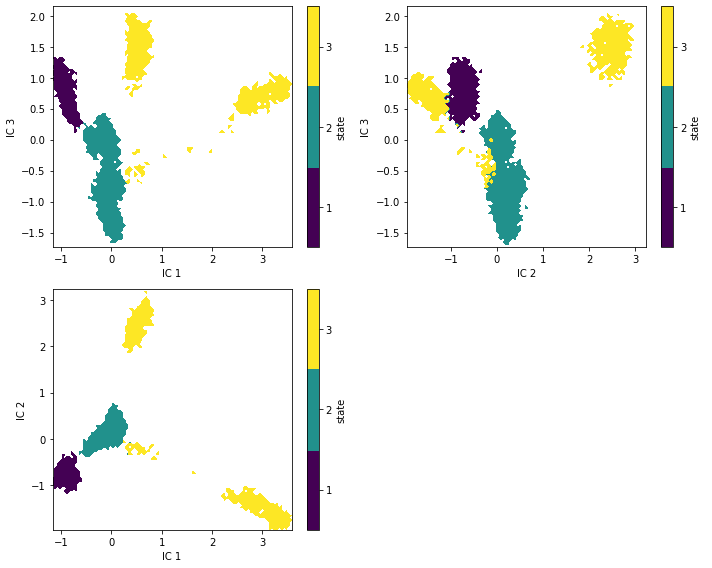

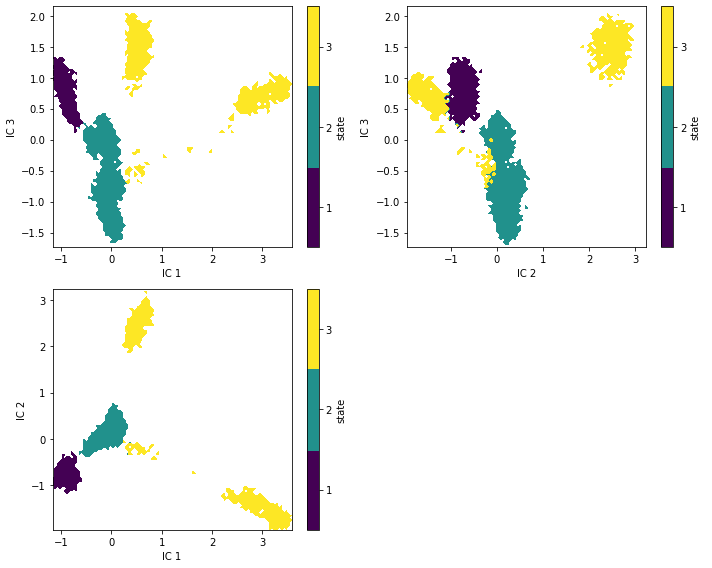

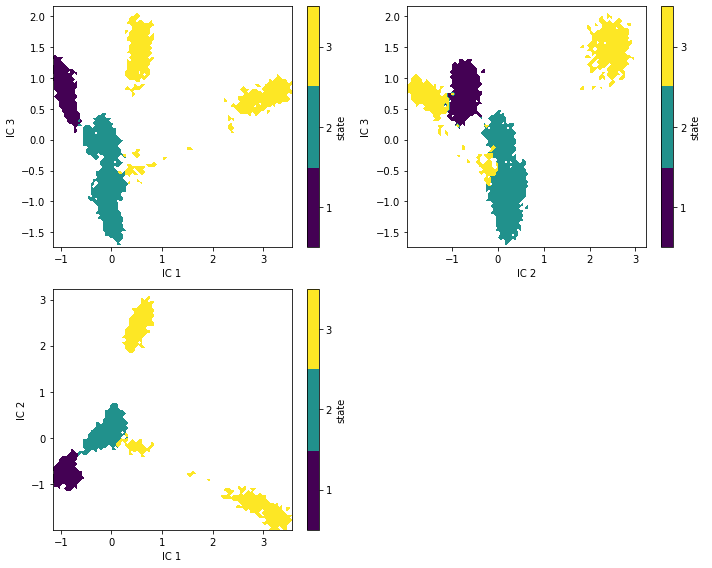

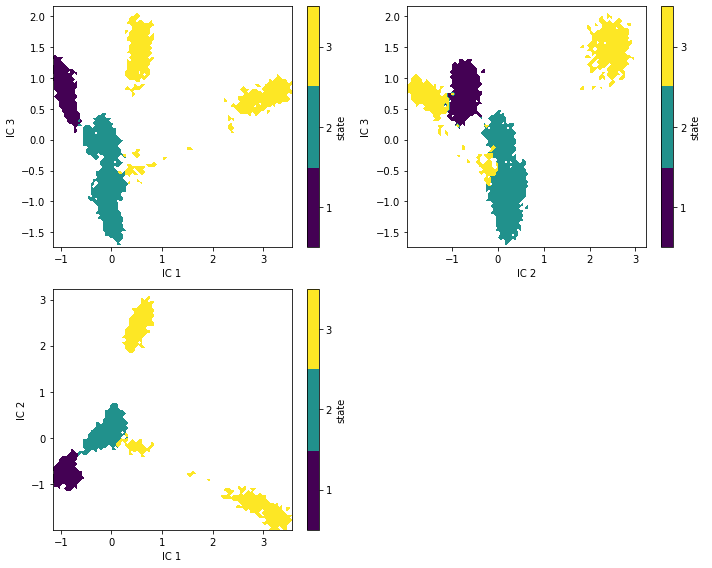

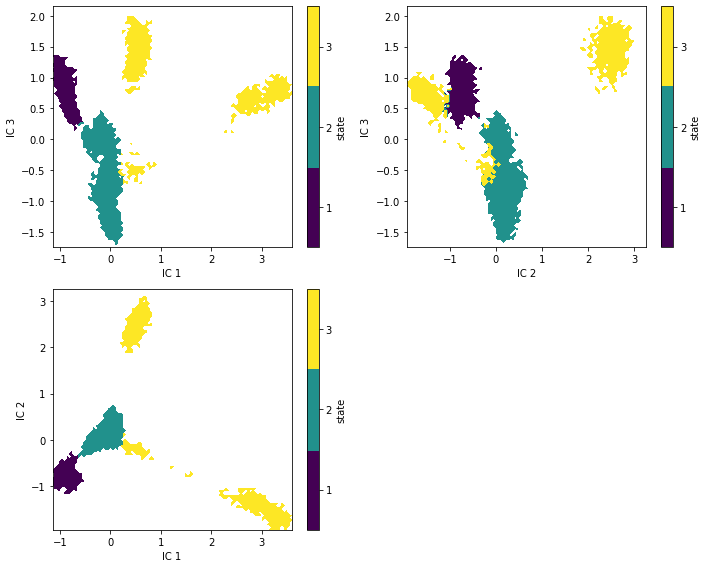

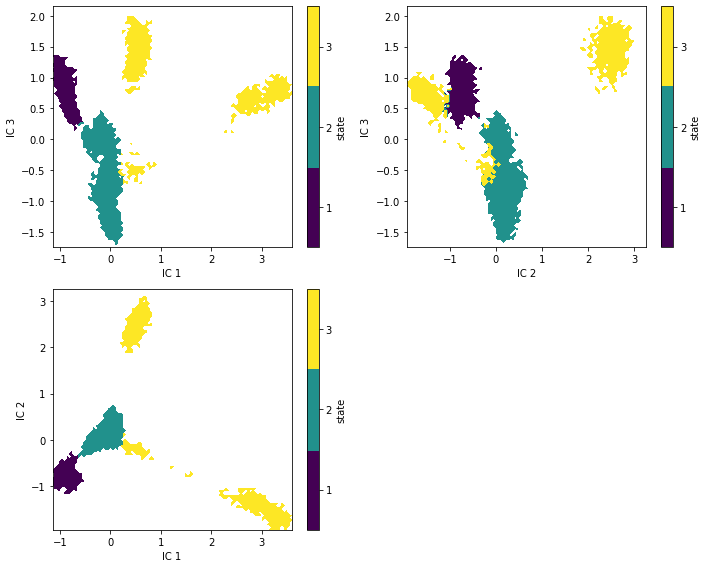

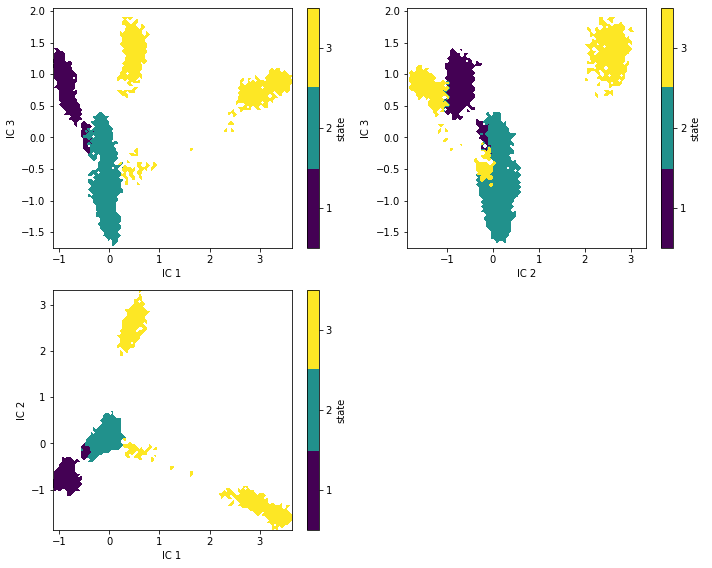

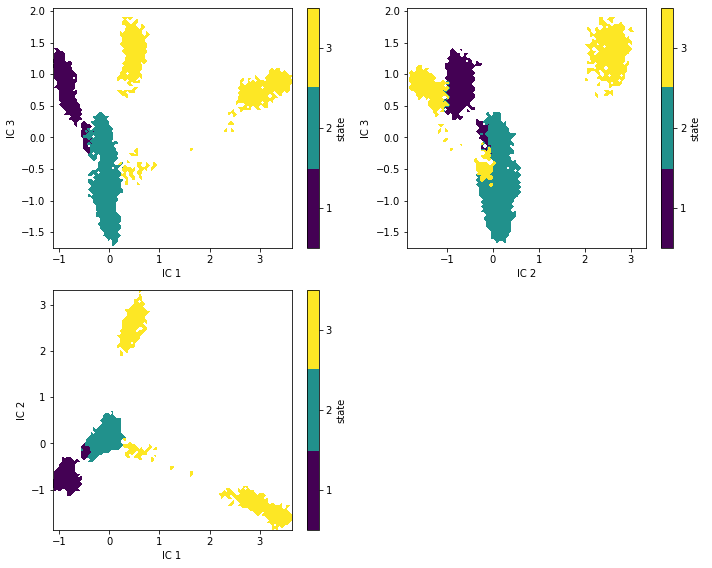

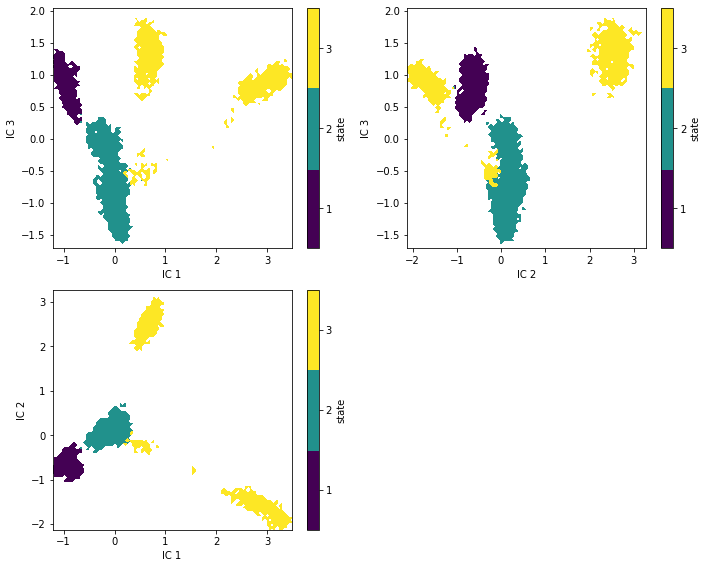

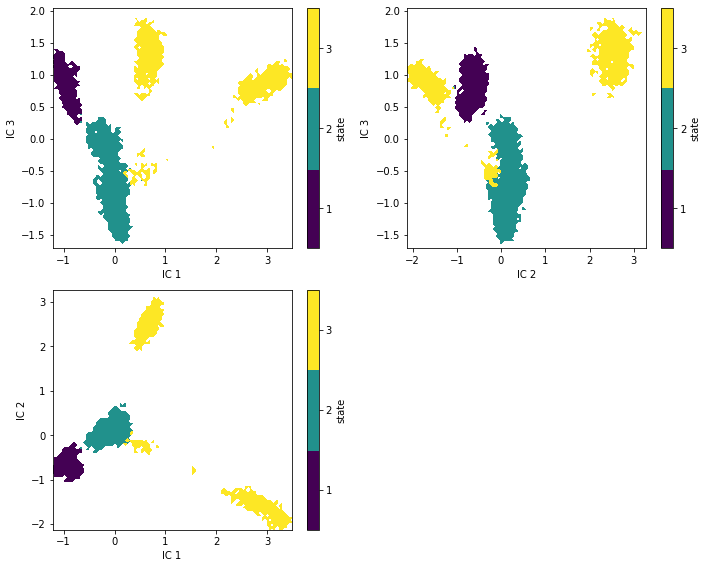

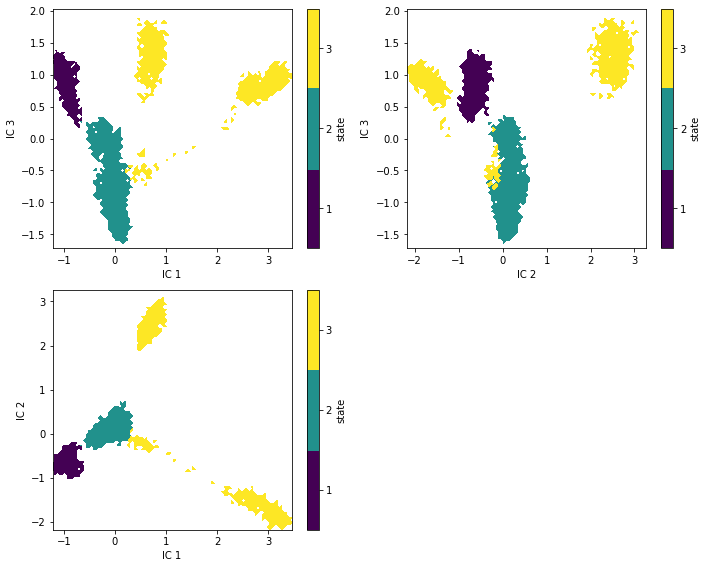

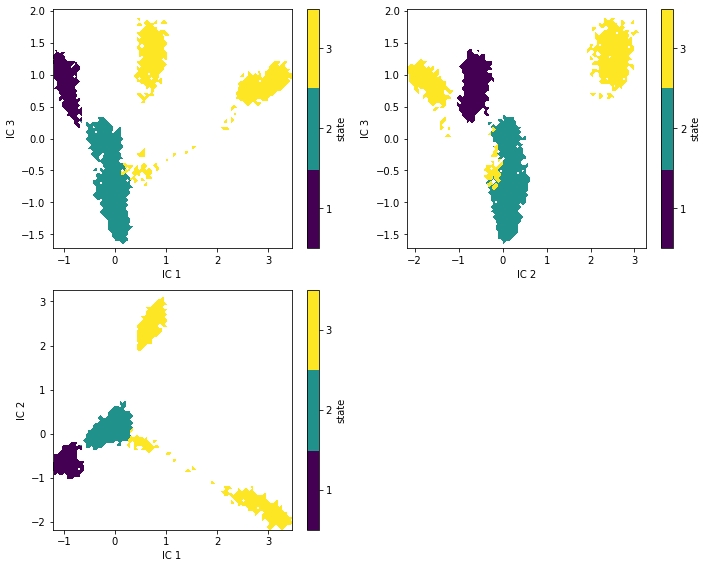

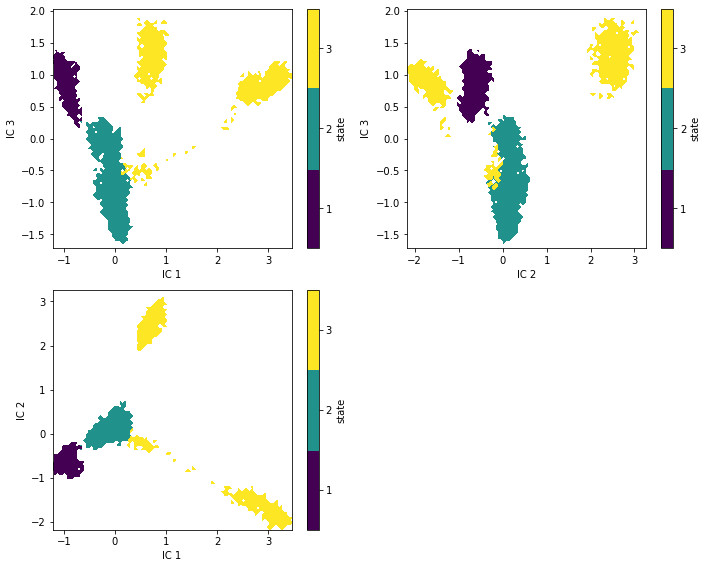

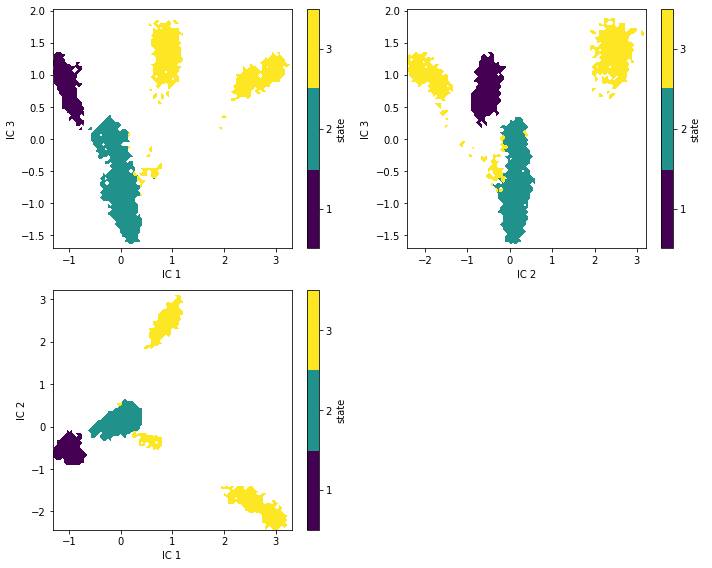

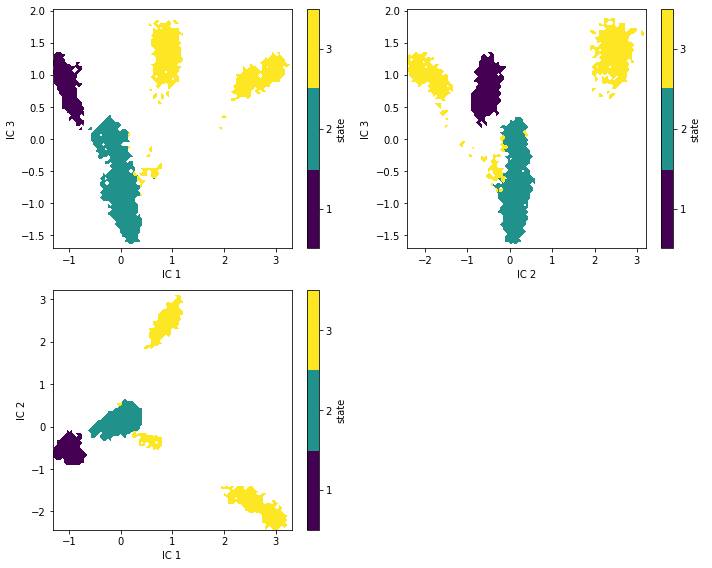

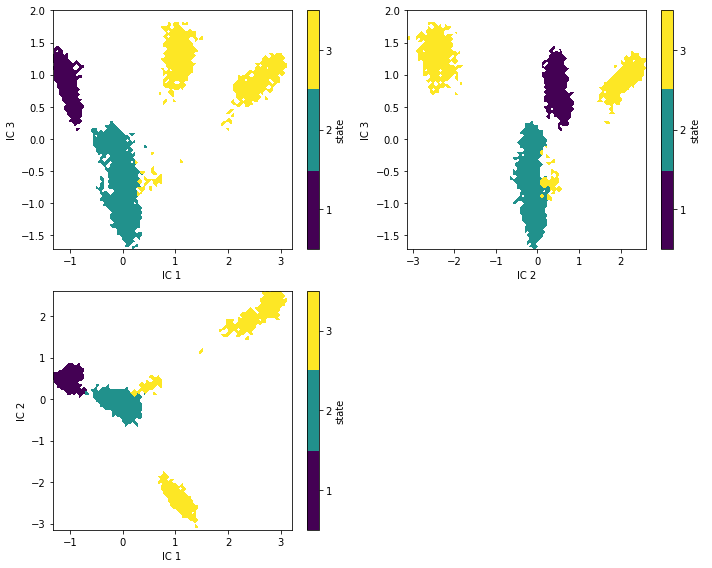

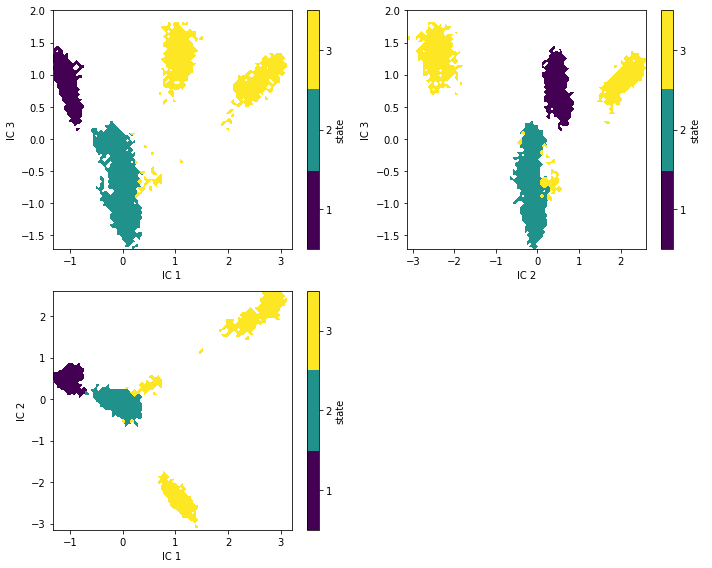

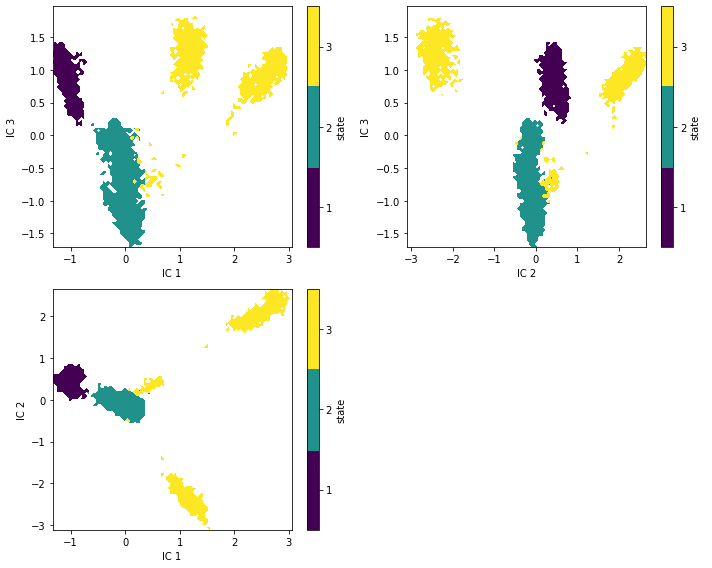

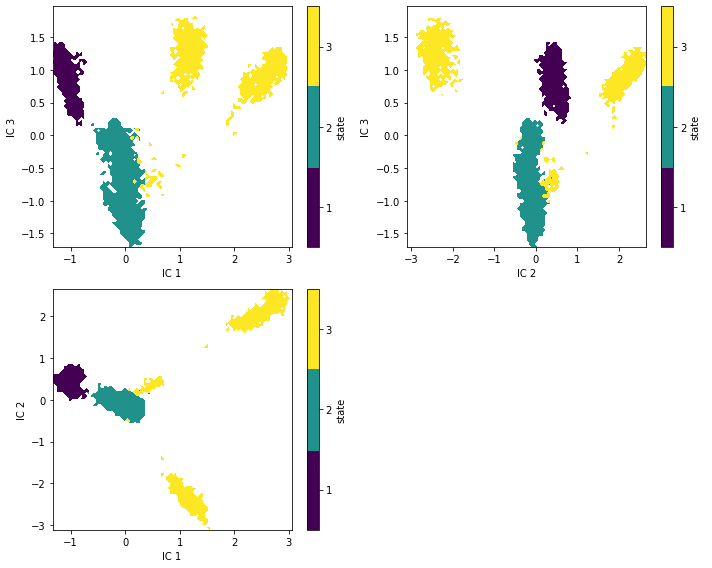

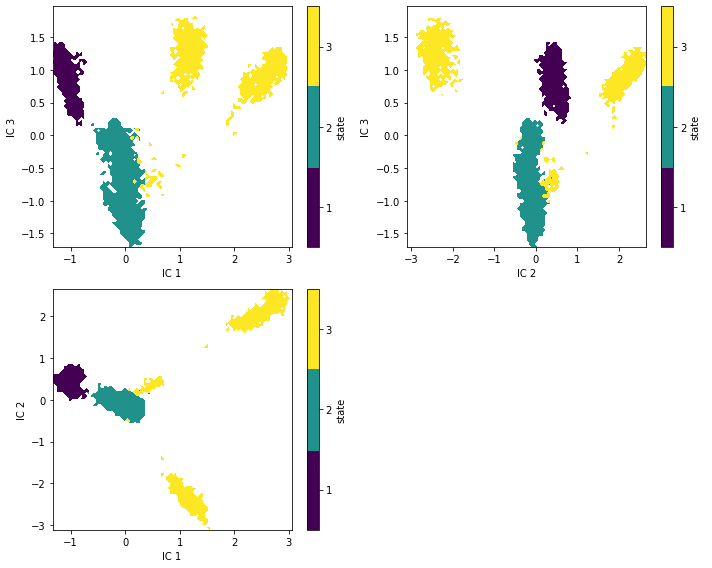

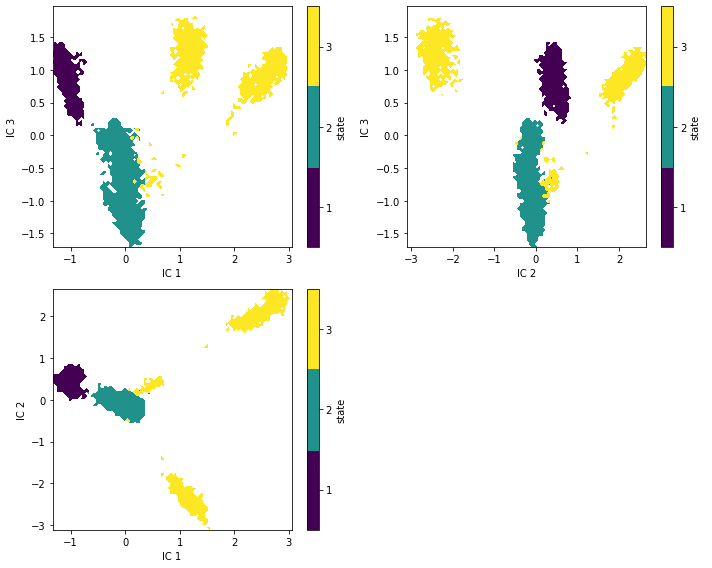

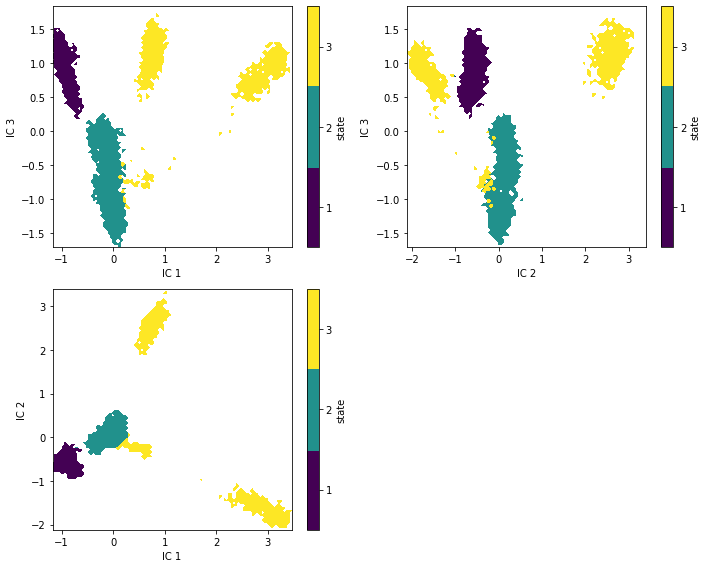

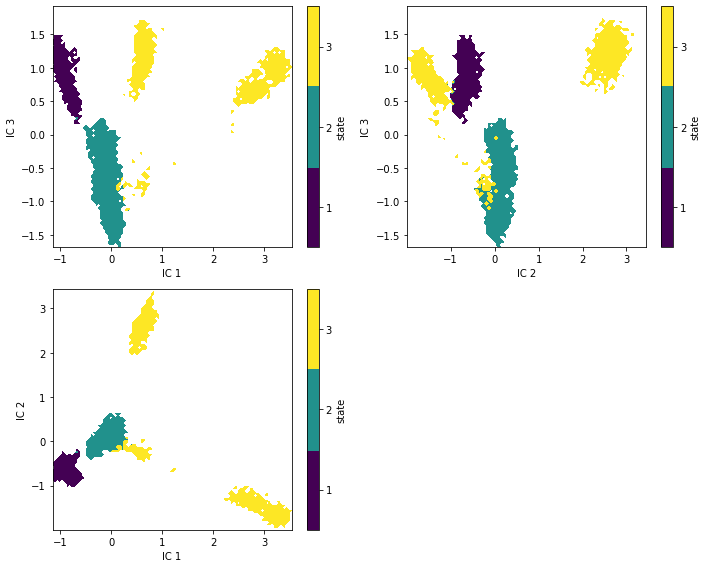

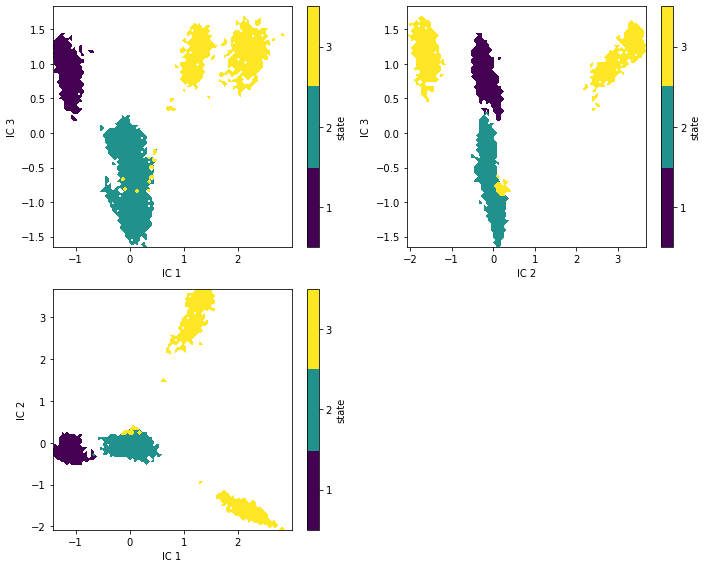

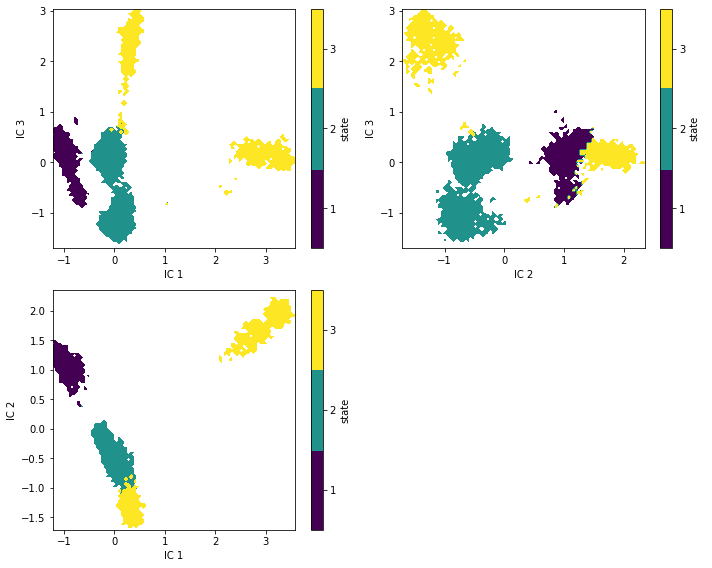

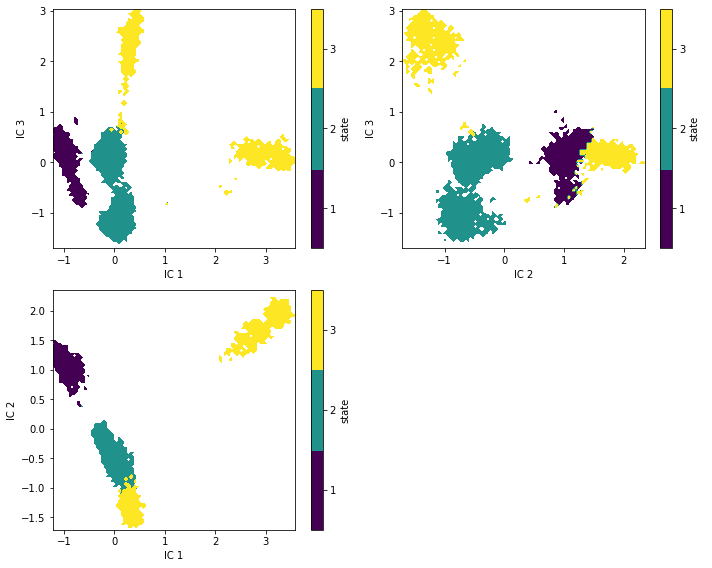

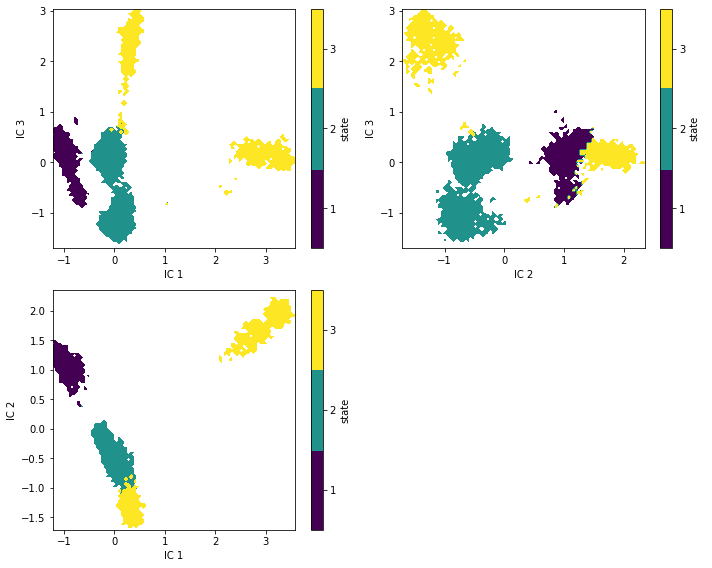

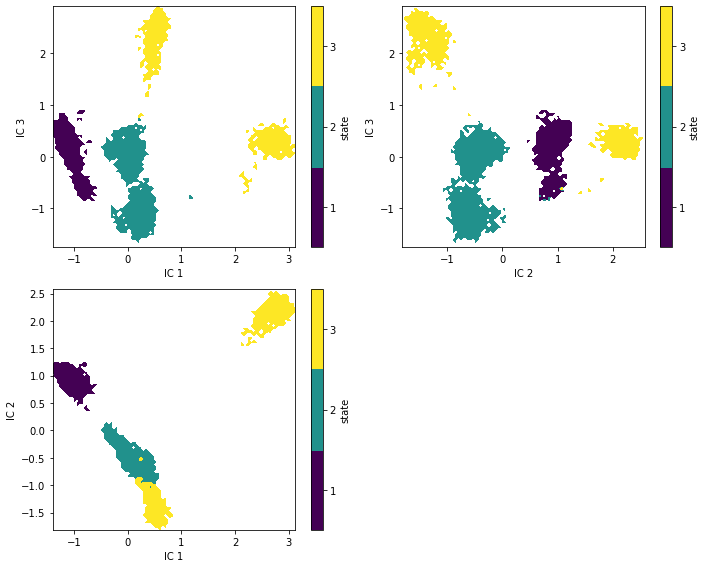

In [7]:
VAMP2(np.arange(0, 0.2, 0.005))

In [9]:
# load modules
%matplotlib inline
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
import pyemma.coordinates
from pyemma.coordinates import source
from pyemma.util.contexts import settings
from pyemma.coordinates import load

def f(x,f,s):
    
    figures_path ='figures_4'
    
    pdb=('mpro.pdb')
    traj=['mpro01.dcd','mpro02.dcd','mpro03.dcd','mpro04.dcd','mpro05.dcd','mpro06.dcd']
    torsions_feat = pyemma.coordinates.featurizer(pdb) 
    selstr=x
    torsions_feat.add_backbone_torsions(selstr, cossin=True, periodic=False)
    torsions_data=pyemma.coordinates.load(traj, features= torsions_feat)
    labels = ['backbone\ntorsions']
    
    score_phi_psi = pyemma.coordinates.vamp(torsions_data[:-1], dim=3).score(
            test_data=torsions_data[-1],
            score_method='VAMP2')
    s.append((score_phi_psi, f))
    
    #time-lagged independent component analysis (TICA)
    tica = pyemma.coordinates.tica(torsions_data, dim=3, lag=50)
    tica_output = tica.get_output()
    tica_concatenated = np.concatenate(tica_output)
    
    ##Clustering
    cluster = pyemma.coordinates.cluster_kmeans(
        tica_concatenated, k=100, max_iter=100, stride=10, fixed_seed=100)
    dtrajs_concatenated = np.concatenate(cluster.dtrajs)
    its = pyemma.msm.its(cluster.dtrajs, lags=[10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 450], nits=10, errors='bayes')

    nstates=3
    msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=50, dt_traj='1 ns', conf=0.95)
    #pyemma.plots.plot_cktest(msm.cktest(nstates));
    msm.pcca(nstates)
    #check the location of our discrete states by plotting them onto the density of our data in the first two TICA dimensions
    #The cluster centers are contained in the cluster object

    #We note that the states are well distributed in the low-dimensional TICA subspace
    def draw_panel(ax, i, j):
        _, _, misc = pyemma.plots.plot_state_map(
            *tica_concatenated[:, [i, j]].T,
            msm.metastable_assignments[dtrajs_concatenated],
            ax=ax)
        ax.set_xlabel('IC {}'.format(i + 1))
        ax.set_ylabel('IC {}'.format(j + 1))
        misc['cbar'].set_ticklabels(range(1, msm.nstates + 1))

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    try:
        draw_panel(axes[0, 0], 0, 2)
        draw_panel(axes[0, 1], 1, 2)
        draw_panel(axes[1, 0], 0, 1)
        axes[1, 1].set_axis_off()
        fig.tight_layout()
        fig.savefig(figures_path+os.path.sep+"states_{}".format(str(f))+".png")
    except:
        pass
    
    

def VAMP2(t):
    
    figures_path ='figures_4'
    
    if not os.path.exists(figures_path):
        os.mkdir(figures_path)
    
    scores=[]
    
    for threshold in t:
        pdb=('mpro.pdb')
        traj=['mpro01.dcd','mpro02.dcd','mpro03.dcd','mpro04.dcd','mpro05.dcd','mpro06.dcd']
        torsions_feat = pyemma.coordinates.featurizer(pdb) 
        selstr="resSeq 44 47 48 53 62 82 83 84 111 112 118 127 137 138 139 141 144 159 182 193 238 239 240 280 286 287 288 289 290 291 297 304 "
        torsions_feat.add_backbone_torsions(selstr, cossin=True, periodic=False)
        torsions_data=pyemma.coordinates.load(traj, features= torsions_feat)
        labels = ['backbone\ntorsions']
        
        #time-lagged independent component analysis (TICA)
        tica = pyemma.coordinates.tica(torsions_data, dim=3, lag=50)
        tica_output = tica.get_output()
        tica_concatenated = np.concatenate(tica_output)
        
        C = tica.feature_TIC_correlation
        df = pd.DataFrame(C[:,:3], columns=['IC1','IC2','IC3'])
        p=[]
        for j in torsions_feat.describe():
            a = re.findall(r'(?<=\s)\d+(?=\))',j) #το έκανα αυτό γιατί παρατήρησα οτι κάποιες φορές οι θέσεις είναι ανακατεμένες
            p.append(int(a[0]))
        df['pos']=p
        DF3 = df[~(df['IC1']<=threshold) | ~(df['IC1']>=-threshold)]
        DF3 = DF3[~(DF3['IC2']<=threshold) | ~(DF3['IC2']>=-threshold)] 
        DF3 = DF3[~(DF3['IC3']<=threshold) | ~(DF3['IC3']>=-threshold)] 
        
        pos_IC1_2_3 = 'resSeq '
        for k in DF3['pos']:
            if str(k) not in pos_IC1_2_3:
                pos_IC1_2_3 += str(k)+' '
        f(pos_IC1_2_3,threshold,scores)
    print(scores)

100%|██████████| 12/12 [00:04<00:00,  2.56it/s]                        
1776it [00:00, 7198.08it/s]                                                                                                            
100%|██████████| 12/12 [00:04<00:00,  2.60it/s]                        
1776it [00:00, 5026.89it/s]                                                                                                            
100%|██████████| 12/12 [00:04<00:00,  2.70it/s]                        
1776it [00:00, 7679.71it/s]                                                                                                            
100%|██████████| 12/12 [00:04<00:00,  2.74it/s]                        
1808it [00:00, 7774.43it/s]                                                                                                            
100%|██████████| 12/12 [00:04<00:00,  2.83it/s]                       
1808it [00:00, 7362.77it/s]                                                                      

[(1.8106286168129664, 0.0), (1.8106286168129664, 0.005), (1.8106286168129664, 0.01), (1.8106286168129664, 0.015), (1.8106286168129664, 0.02), (1.8106286168129664, 0.025), (1.8106286168129664, 0.03), (1.8106286168129664, 0.035), (1.8106286168129664, 0.04), (1.8106286168129664, 0.045), (1.8106286168129664, 0.05), (1.8106286168129664, 0.055), (1.8106286168129664, 0.06), (1.8106286168129664, 0.065), (1.7746143193366262, 0.07), (1.7746143193366262, 0.075), (1.7746143193366262, 0.08), (1.7710370987323507, 0.085), (1.7702974596189298, 0.09), (1.7702974596189298, 0.095), (1.7702974596189298, 0.1), (1.7702974596189298, 0.105), (1.7773208384509918, 0.11), (1.7773208384509918, 0.115), (1.7826722239721178, 0.12), (1.7826722239721178, 0.125), (1.8488008830295044, 0.13), (1.8488008830295044, 0.135), (1.8053324773388308, 0.14), (1.8297608261132081, 0.145), (1.8297608261132081, 0.15), (1.7777666087360284, 0.155), (1.7777666087360284, 0.16), (1.7777666087360284, 0.165), (1.768844846766862, 0.17), (1.57

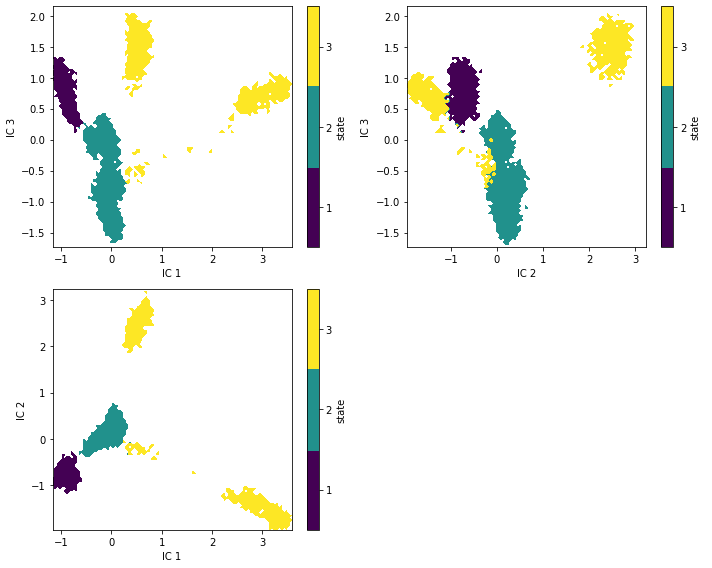

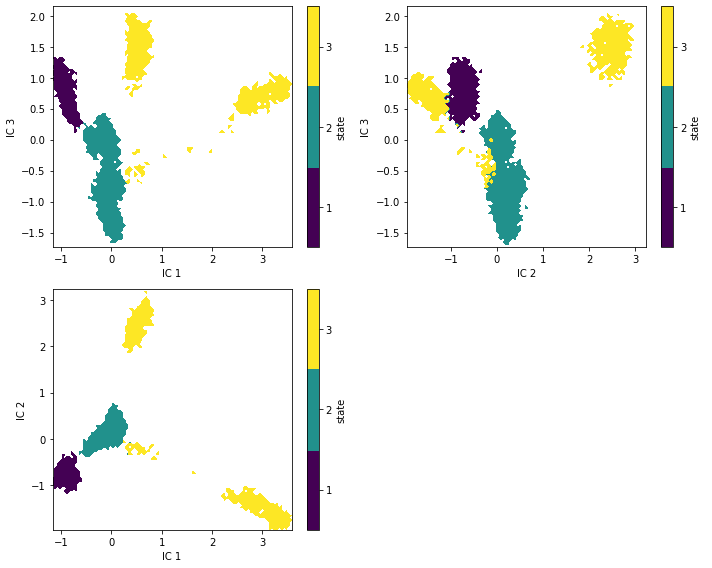

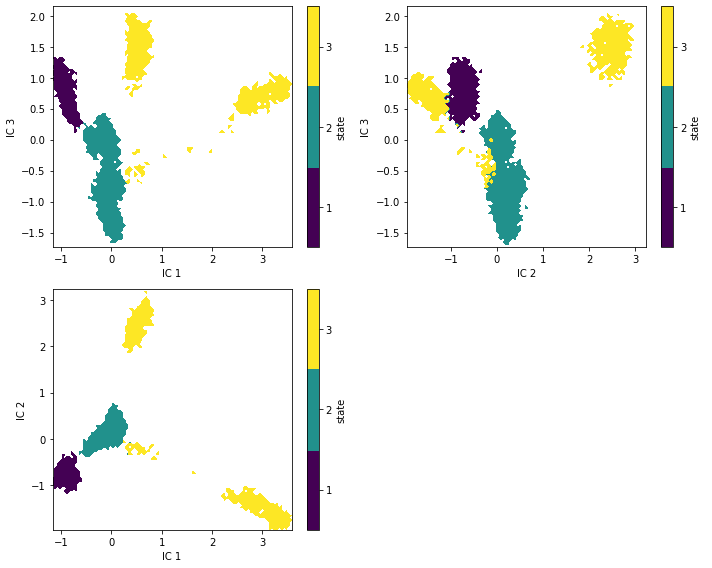

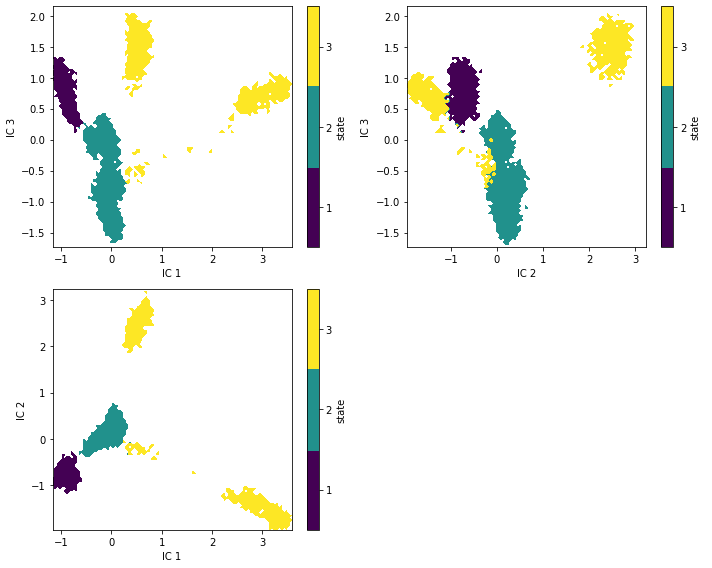

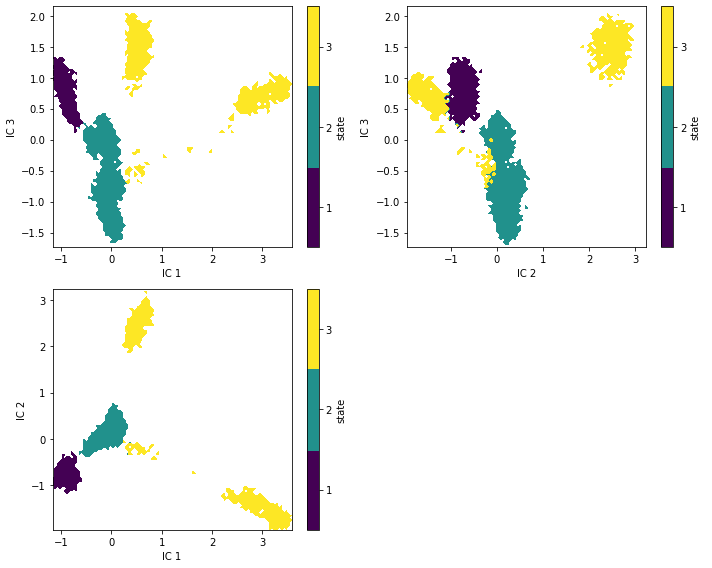

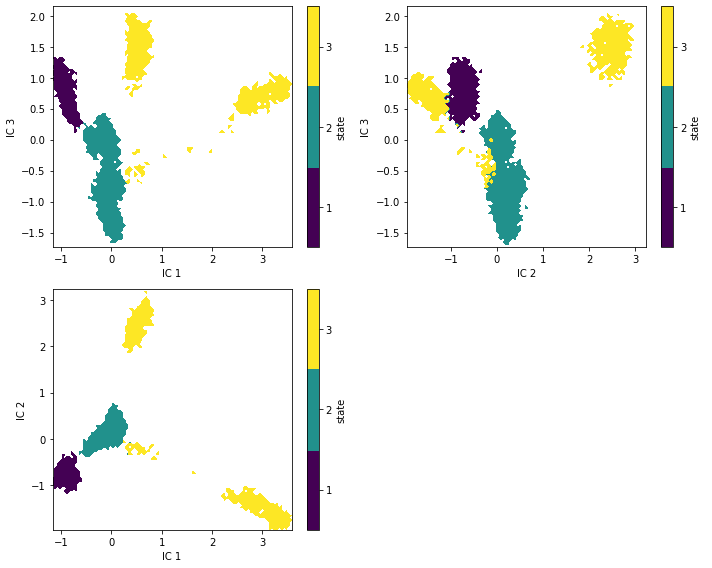

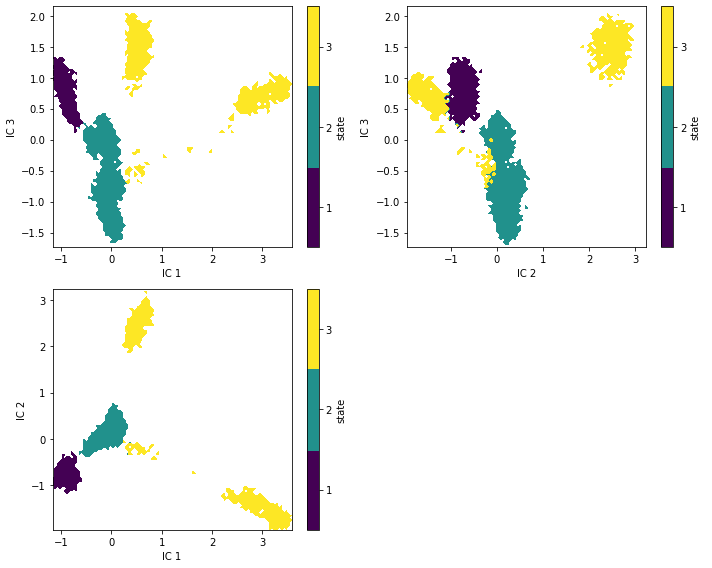

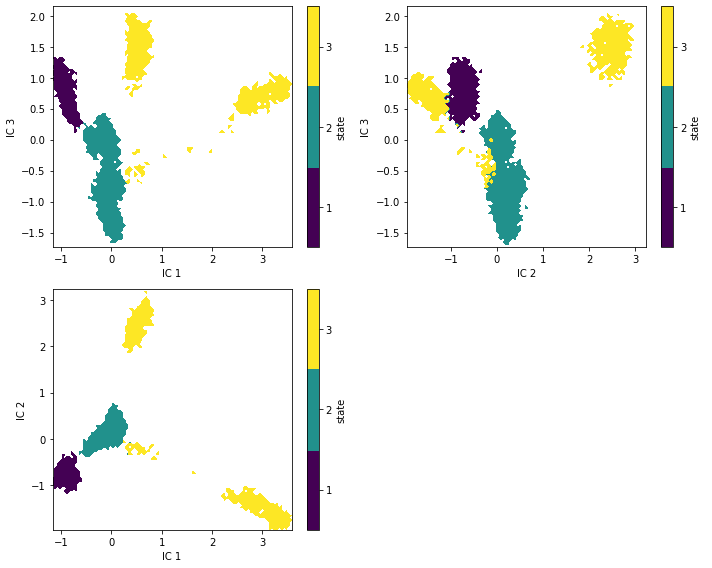

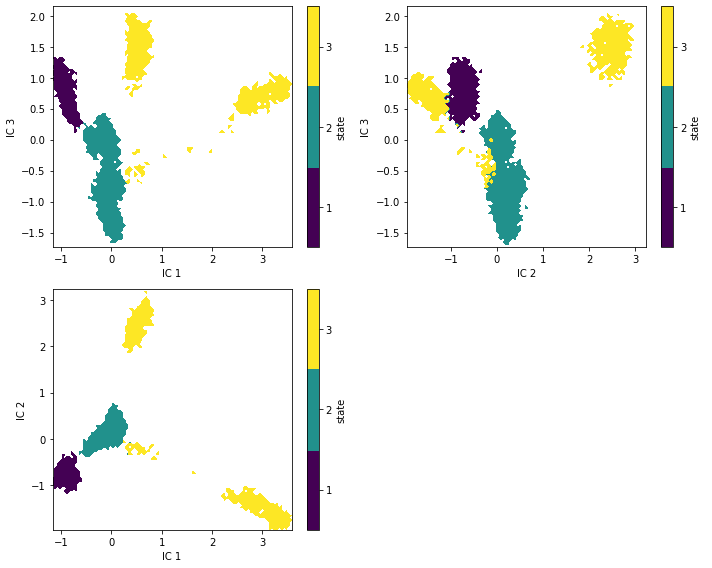

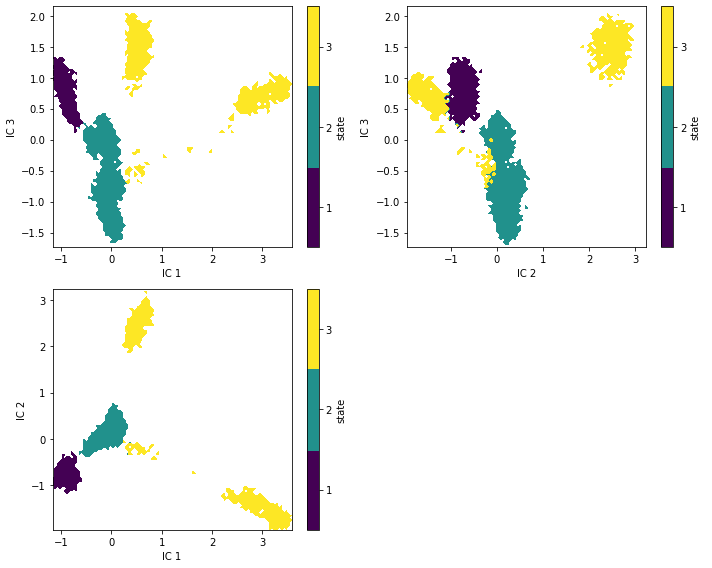

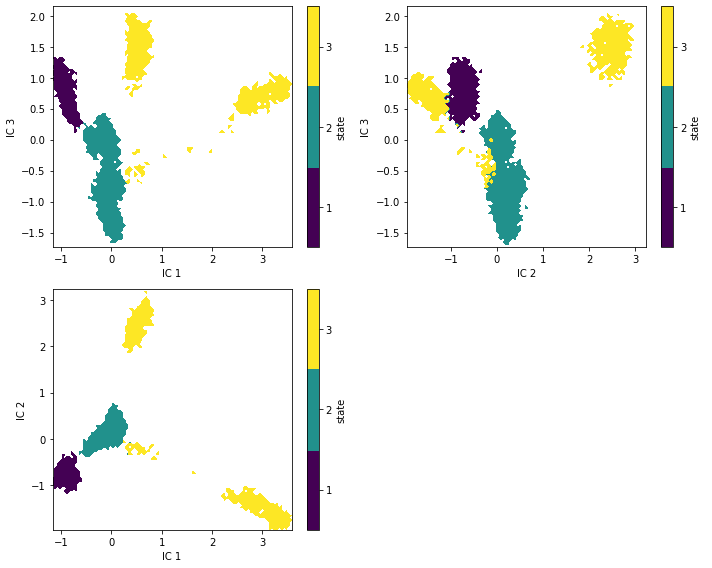

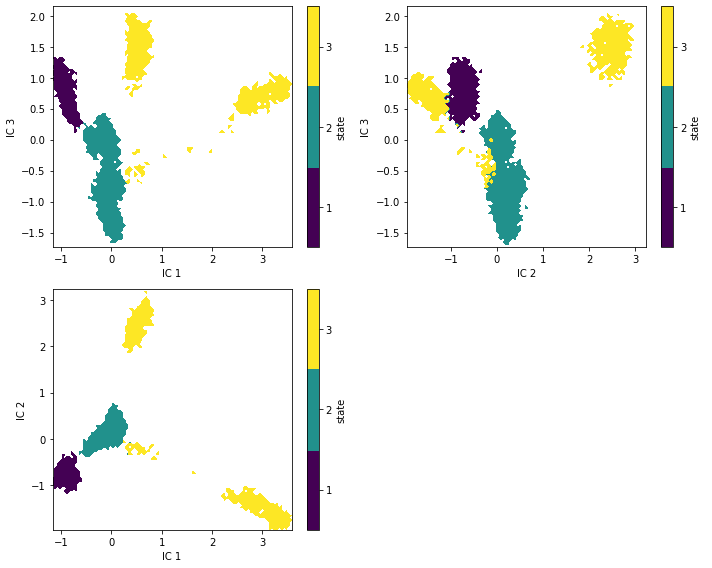

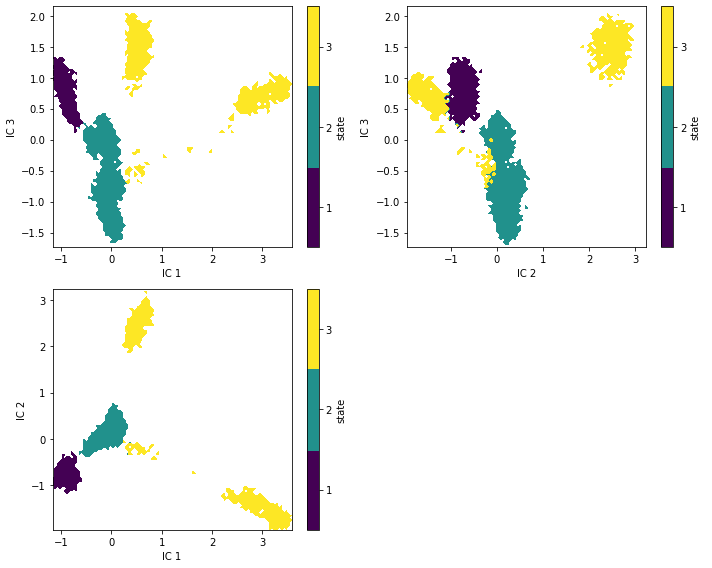

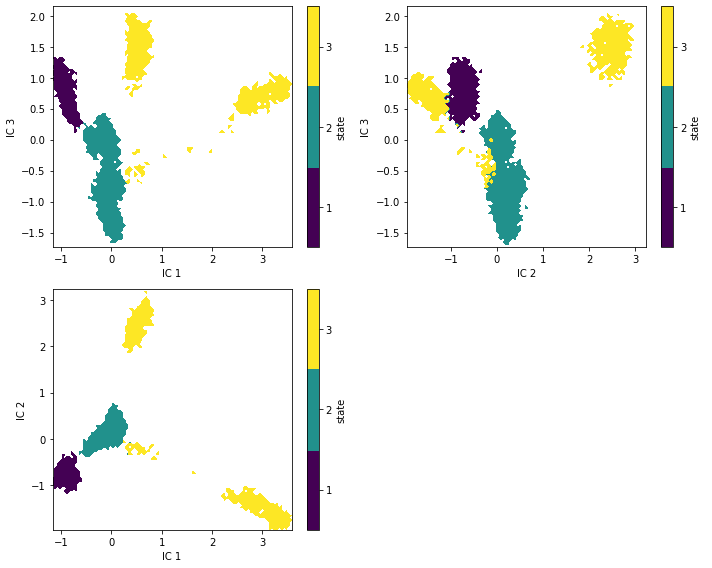

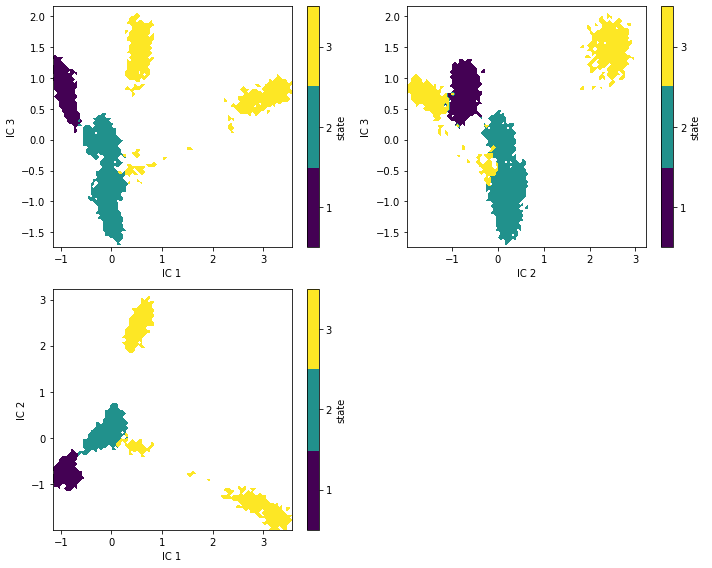

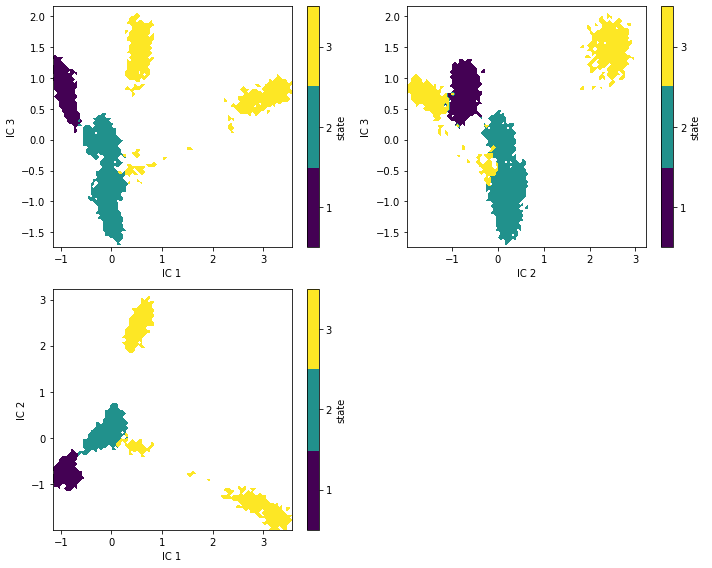

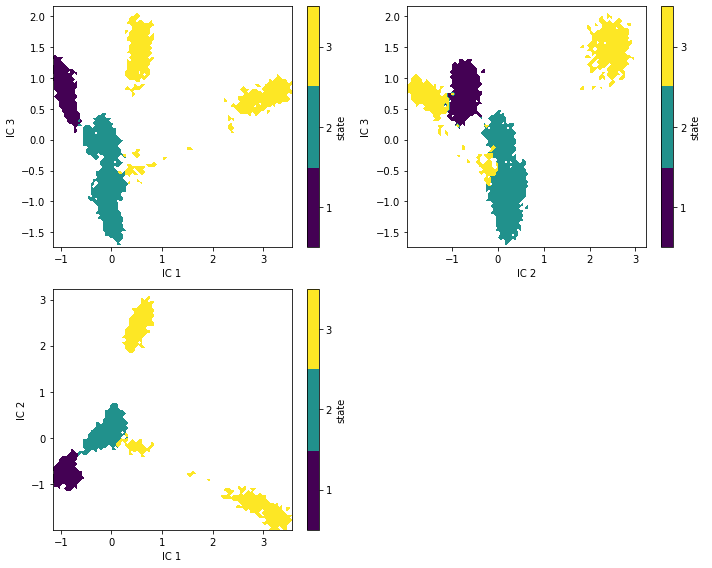

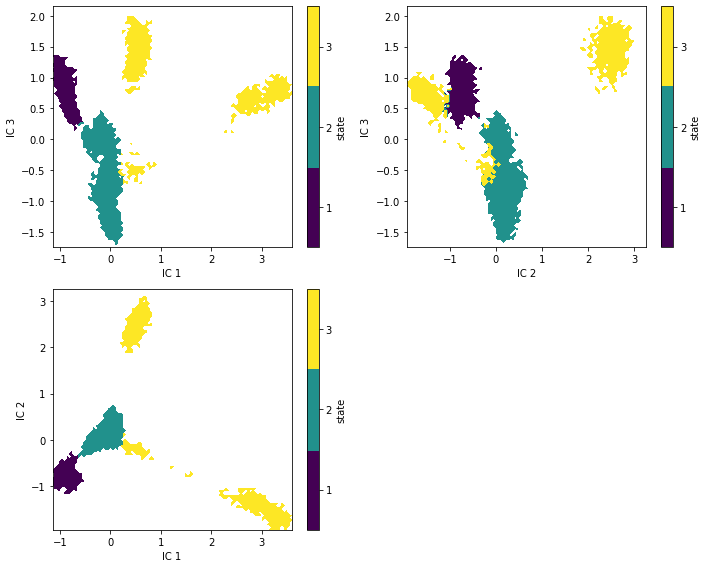

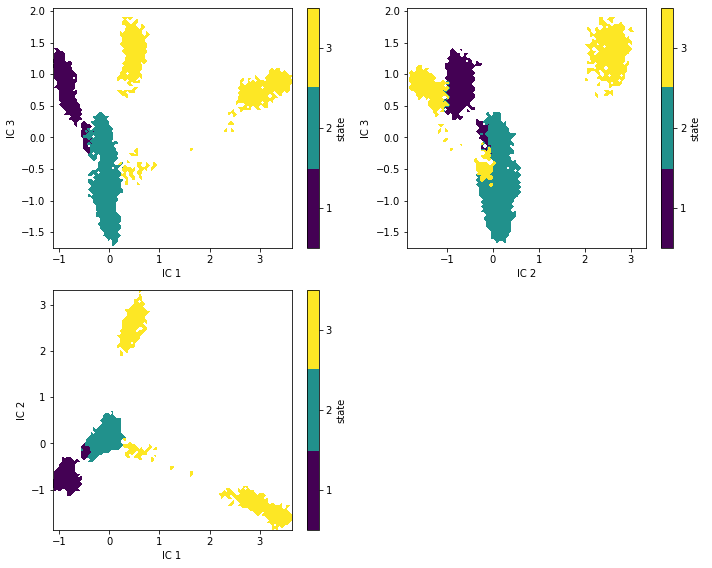

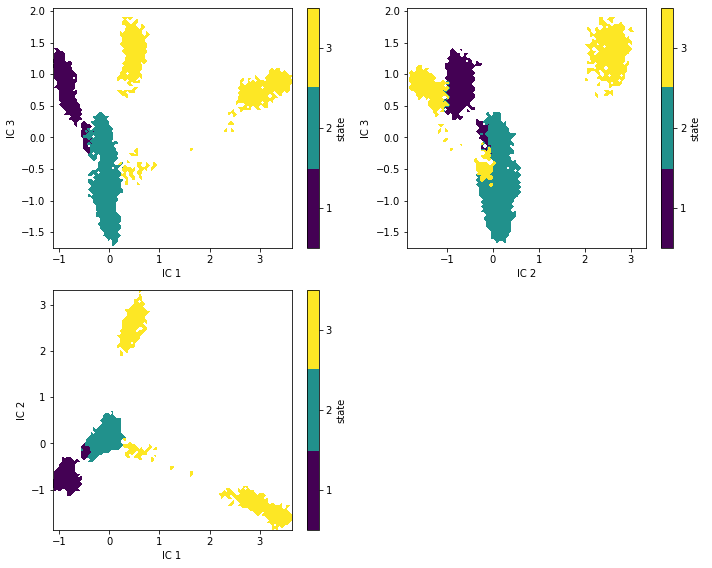

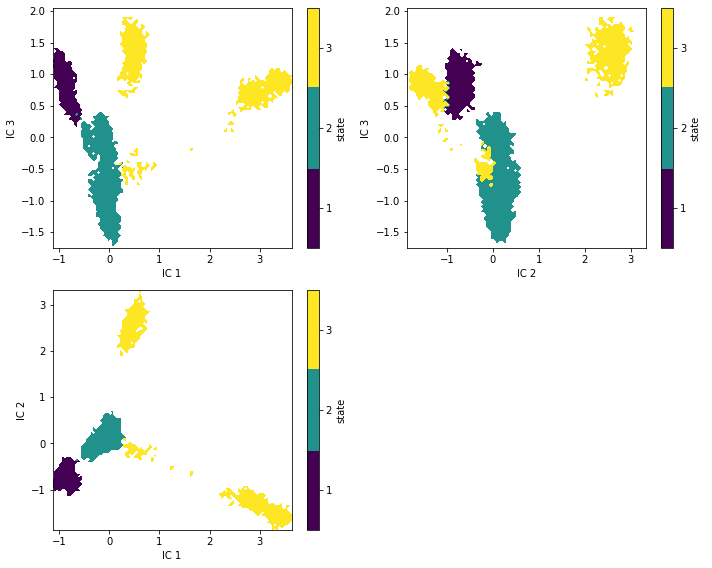

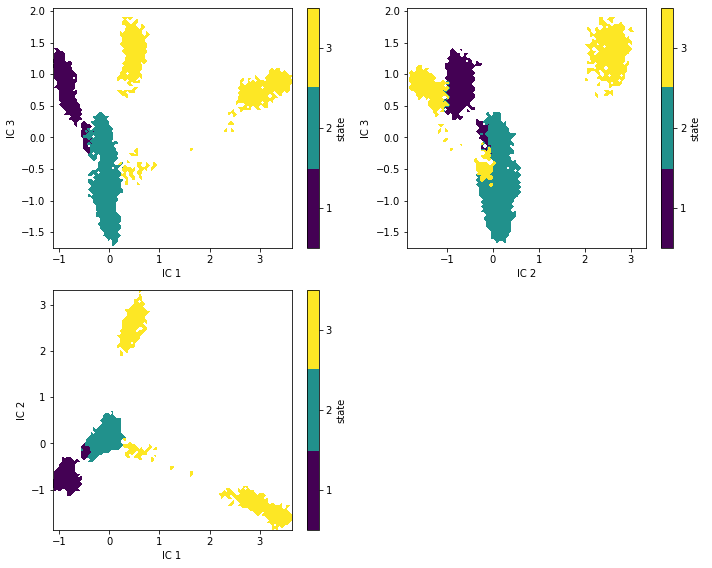

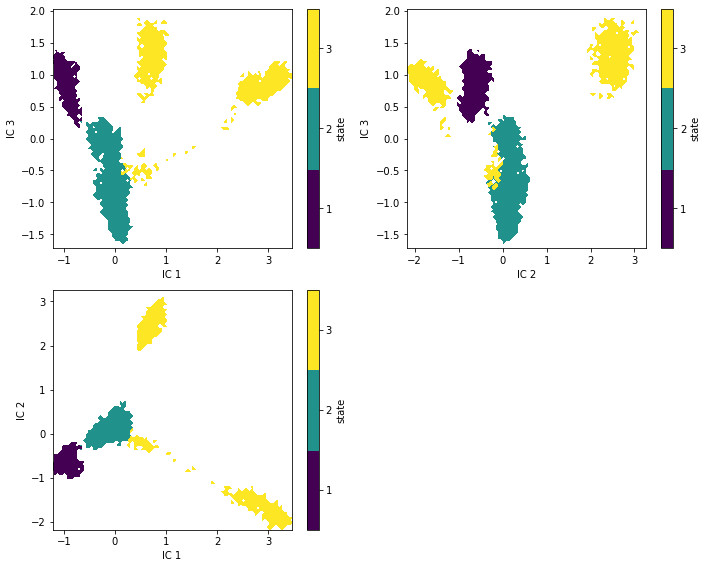

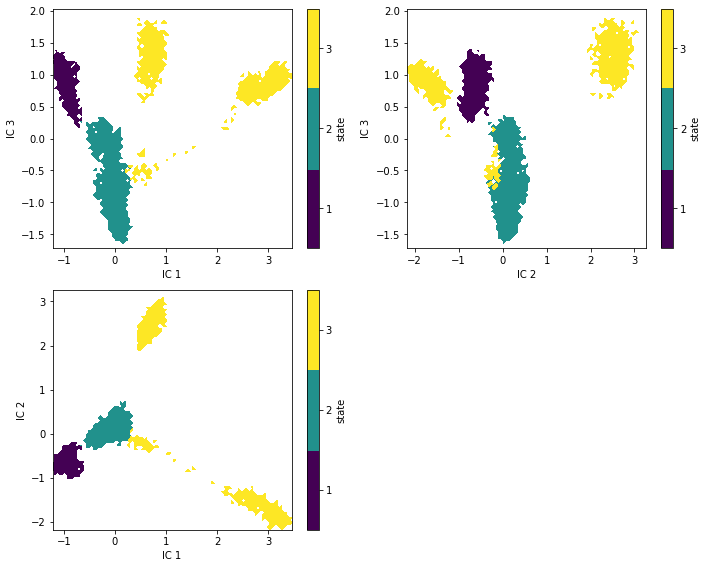

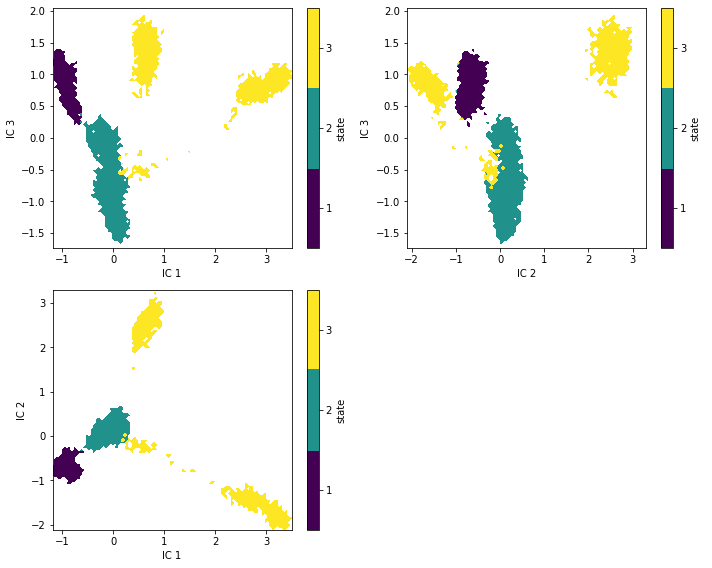

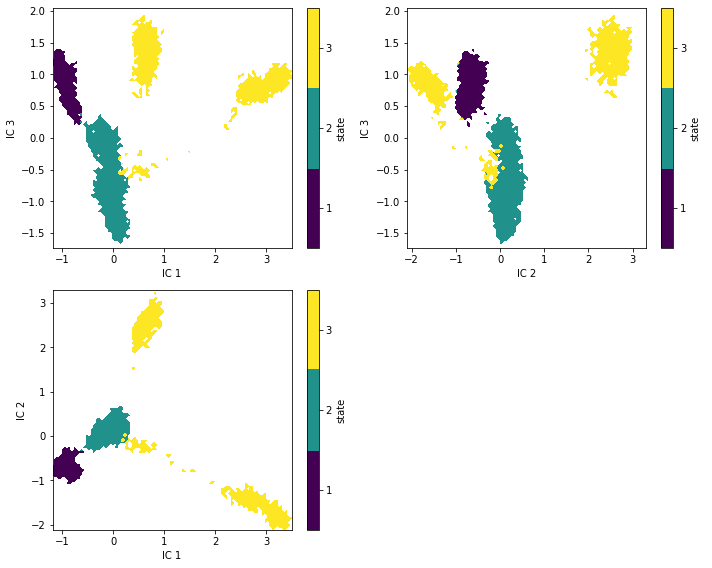

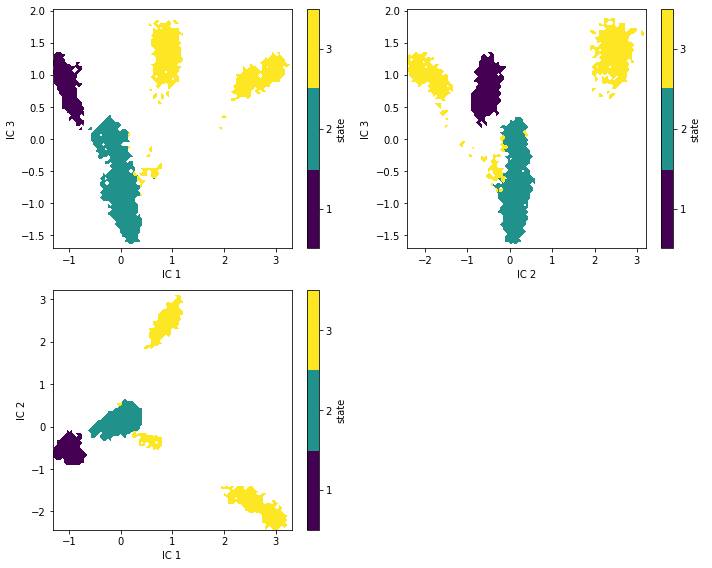

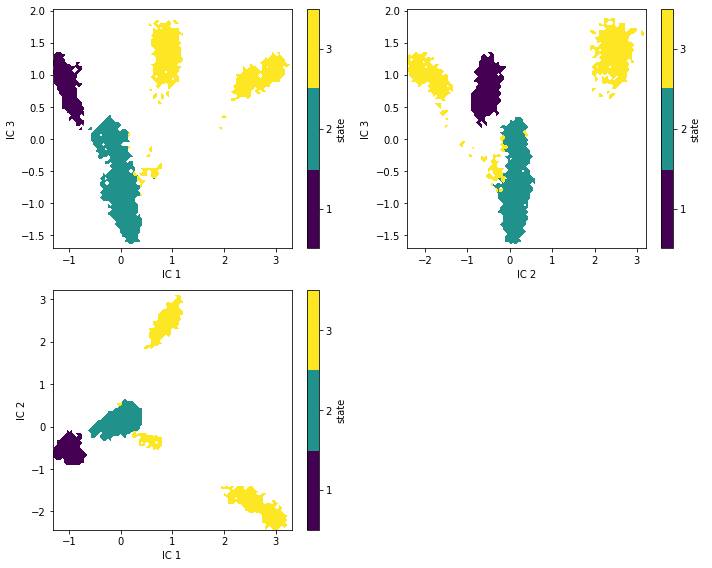

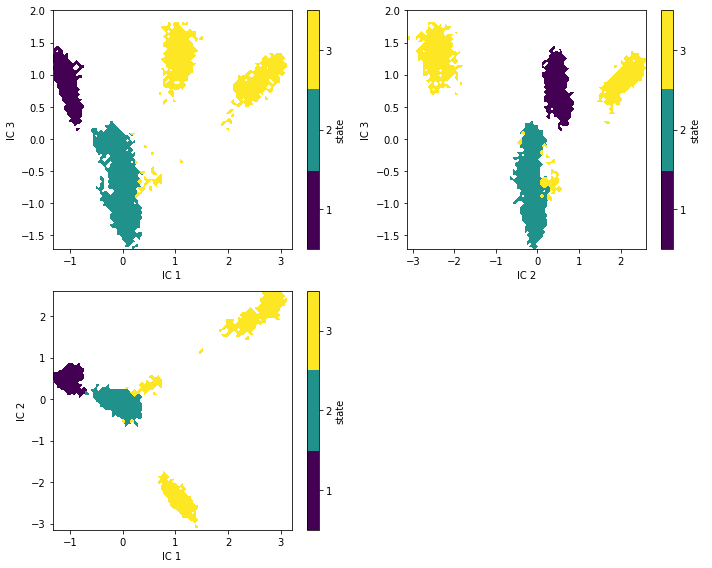

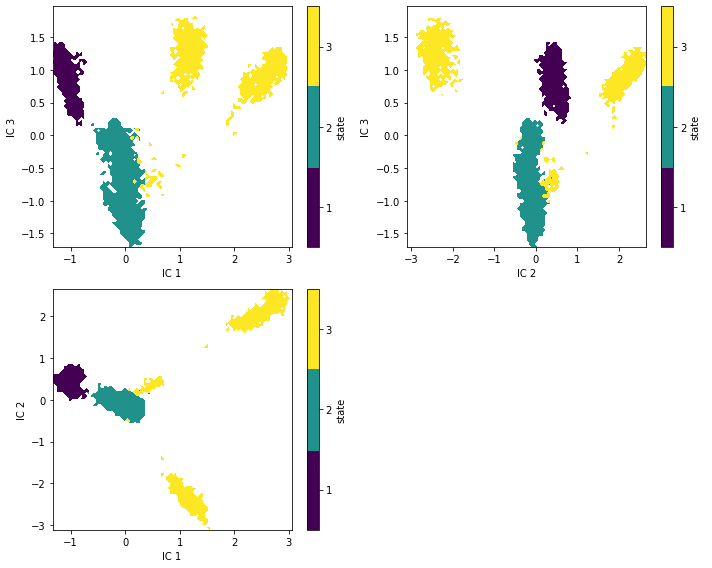

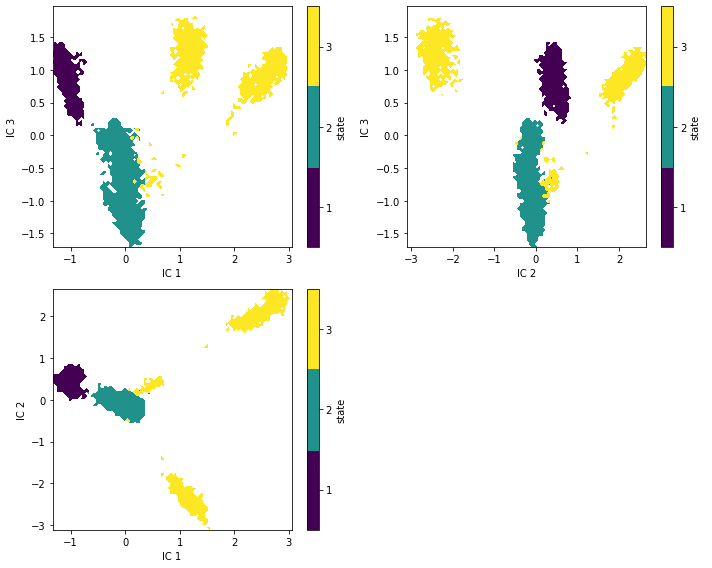

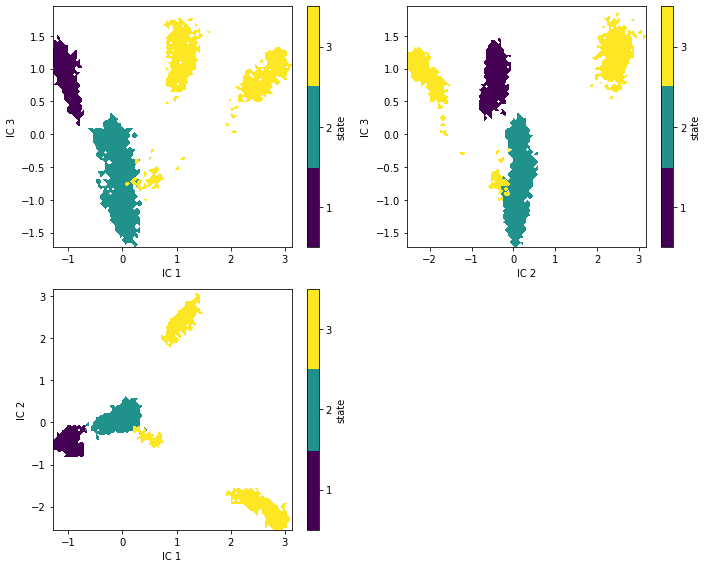

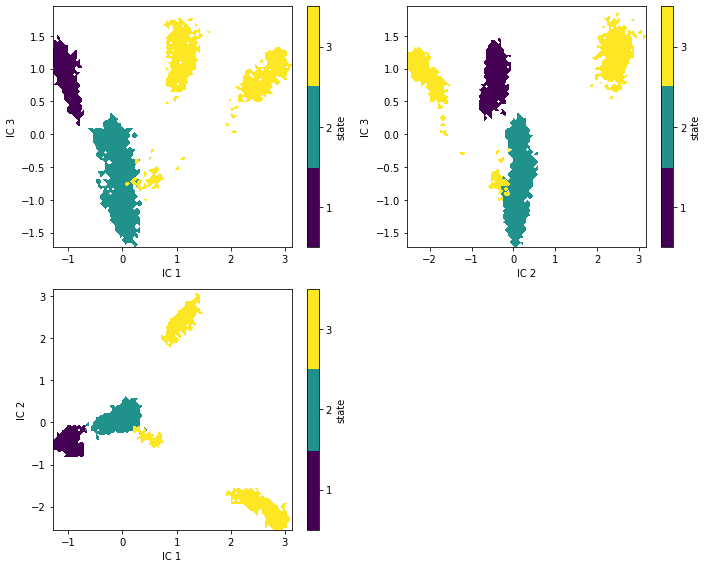

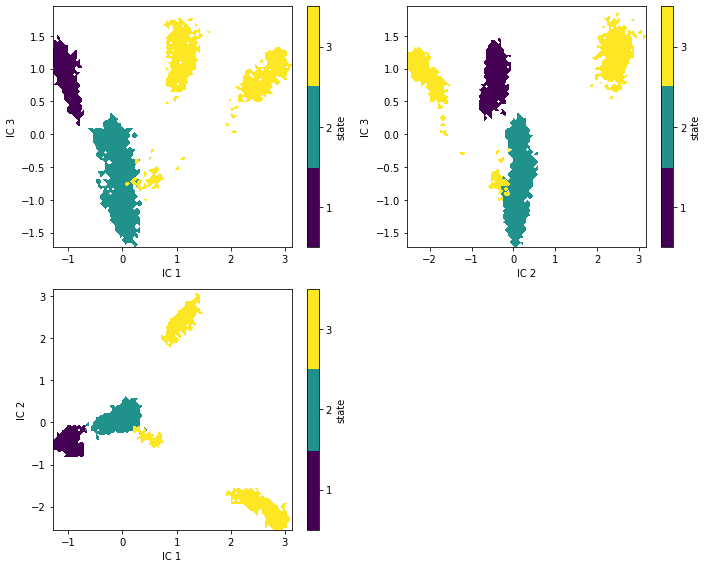

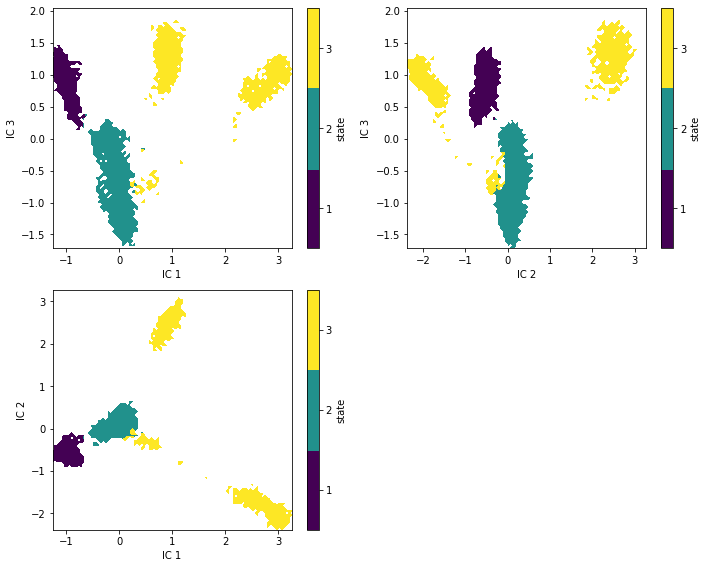

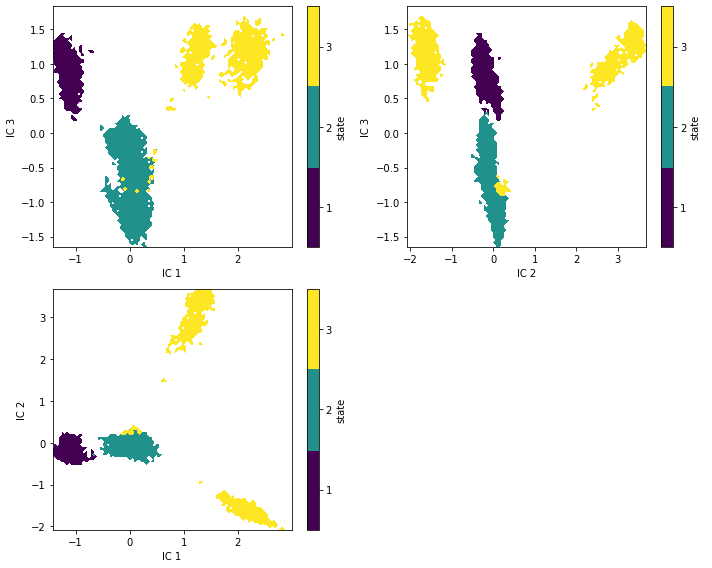

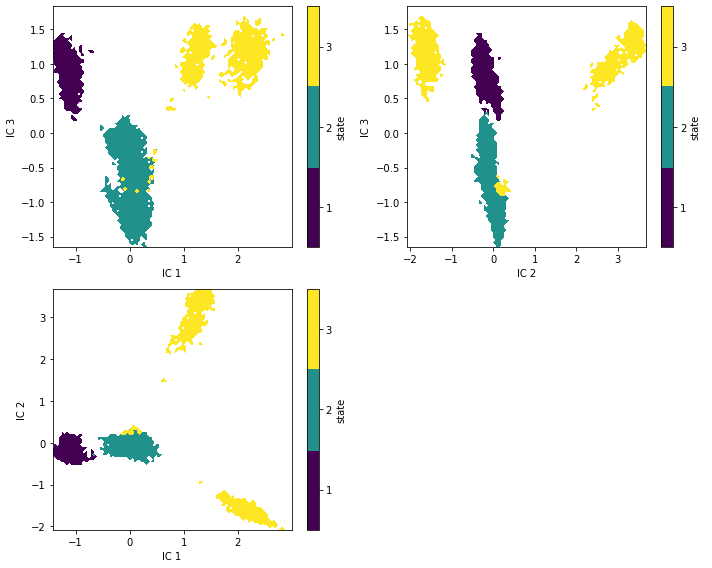

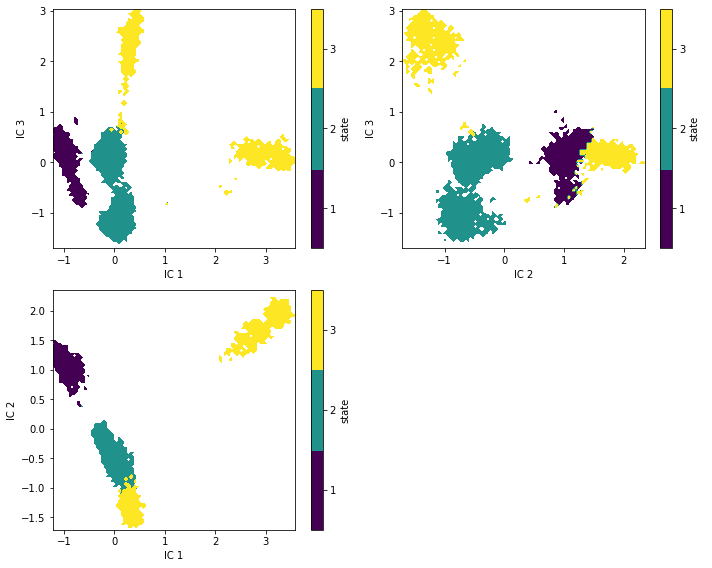

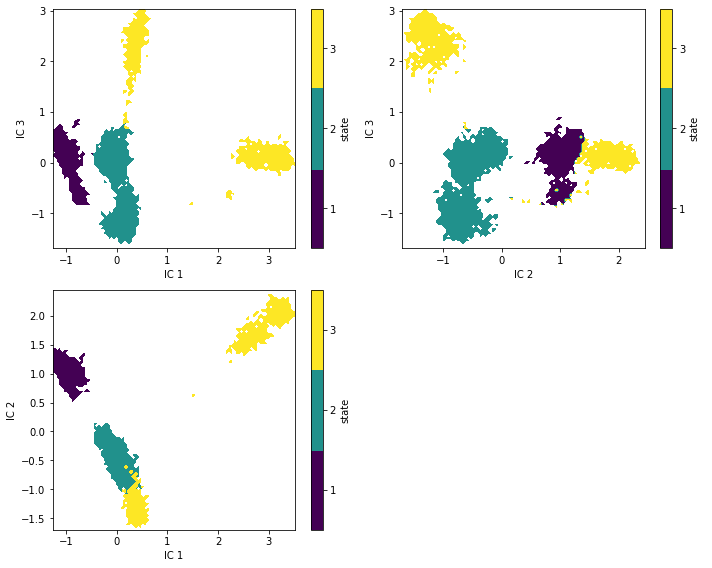

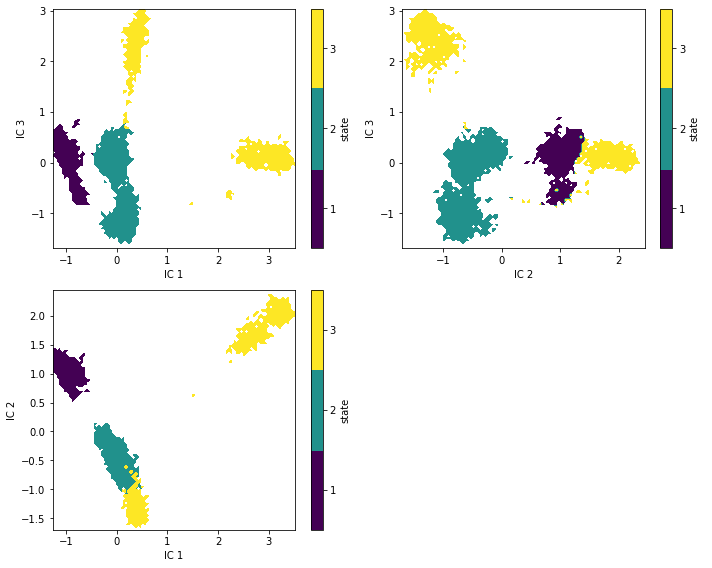

In [10]:
VAMP2(np.arange(0, 0.2, 0.005))

In [12]:
# load modules
%matplotlib inline
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
import pyemma.coordinates
from pyemma.coordinates import source
from pyemma.util.contexts import settings
from pyemma.coordinates import load

def f(x,f,s):
    
    figures_path ='figures_5'
    
    pdb=('mpro.pdb')
    traj=['mpro01.dcd','mpro02.dcd','mpro03.dcd','mpro04.dcd','mpro05.dcd','mpro06.dcd']
    torsions_feat = pyemma.coordinates.featurizer(pdb) 
    selstr=x
    torsions_feat.add_backbone_torsions(selstr, cossin=True, periodic=False)
    torsions_data=pyemma.coordinates.load(traj, features= torsions_feat)
    labels = ['backbone\ntorsions']
    
    score_phi_psi = pyemma.coordinates.vamp(torsions_data[:-1], dim=3).score(
            test_data=torsions_data[-1],
            score_method='VAMP2')
    s.append((score_phi_psi, f))
    
    #time-lagged independent component analysis (TICA)
    tica = pyemma.coordinates.tica(torsions_data, dim=3, lag=50)
    tica_output = tica.get_output()
    tica_concatenated = np.concatenate(tica_output)
    
    ##Clustering
    cluster = pyemma.coordinates.cluster_kmeans(
        tica_concatenated, k=100, max_iter=100, stride=10, fixed_seed=100)
    dtrajs_concatenated = np.concatenate(cluster.dtrajs)
    its = pyemma.msm.its(cluster.dtrajs, lags=[10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 450], nits=10, errors='bayes')

    nstates=3
    msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=50, dt_traj='1 ns', conf=0.95)
    #pyemma.plots.plot_cktest(msm.cktest(nstates));
    msm.pcca(nstates)
    #check the location of our discrete states by plotting them onto the density of our data in the first two TICA dimensions
    #The cluster centers are contained in the cluster object

    #We note that the states are well distributed in the low-dimensional TICA subspace
    def draw_panel(ax, i, j):
        _, _, misc = pyemma.plots.plot_state_map(
            *tica_concatenated[:, [i, j]].T,
            msm.metastable_assignments[dtrajs_concatenated],
            ax=ax)
        ax.set_xlabel('IC {}'.format(i + 1))
        ax.set_ylabel('IC {}'.format(j + 1))
        misc['cbar'].set_ticklabels(range(1, msm.nstates + 1))

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    try:
        draw_panel(axes[0, 0], 0, 2)
        draw_panel(axes[0, 1], 1, 2)
        draw_panel(axes[1, 0], 0, 1)
        axes[1, 1].set_axis_off()
        fig.tight_layout()
        fig.savefig(figures_path+os.path.sep+"states_{}".format(str(f))+".png")
    except:
        pass
    
    

def VAMP2(t):
    
    figures_path ='figures_5'
    
    if not os.path.exists(figures_path):
        os.mkdir(figures_path)
    
    scores=[]
    
    for threshold in t:
        pdb=('mpro.pdb')
        traj=['mpro01.dcd','mpro02.dcd','mpro03.dcd','mpro04.dcd','mpro05.dcd','mpro06.dcd']
        torsions_feat = pyemma.coordinates.featurizer(pdb) 
        selstr="resSeq 44 48 53 62 82 83 84 111 112 118 137 138 139 141 144 159 182 238 239 240 286 287 288 289 291"
        torsions_feat.add_backbone_torsions(selstr, cossin=True, periodic=False)
        torsions_data=pyemma.coordinates.load(traj, features= torsions_feat)
        labels = ['backbone\ntorsions']
        
        #time-lagged independent component analysis (TICA)
        tica = pyemma.coordinates.tica(torsions_data, dim=3, lag=50)
        tica_output = tica.get_output()
        tica_concatenated = np.concatenate(tica_output)
        
        C = tica.feature_TIC_correlation
        df = pd.DataFrame(C[:,:3], columns=['IC1','IC2','IC3'])
        p=[]
        for j in torsions_feat.describe():
            a = re.findall(r'(?<=\s)\d+(?=\))',j) #το έκανα αυτό γιατί παρατήρησα οτι κάποιες φορές οι θέσεις είναι ανακατεμένες
            p.append(int(a[0]))
        df['pos']=p
        DF3 = df[~(df['IC1']<=threshold) | ~(df['IC1']>=-threshold)]
        DF3 = DF3[~(DF3['IC2']<=threshold) | ~(DF3['IC2']>=-threshold)] 
        DF3 = DF3[~(DF3['IC3']<=threshold) | ~(DF3['IC3']>=-threshold)] 
        
        pos_IC1_2_3 = 'resSeq '
        for k in DF3['pos']:
            if str(k) not in pos_IC1_2_3:
                pos_IC1_2_3 += str(k)+' '
        f(pos_IC1_2_3,threshold,scores)
    print(scores)

100%|██████████| 12/12 [00:04<00:00,  2.89it/s]                       
1824it [00:00, 6915.91it/s]                                                                                                            
100%|██████████| 12/12 [00:04<00:00,  2.63it/s]                       
1824it [00:00, 7311.48it/s]                                                                                                            
100%|██████████| 12/12 [00:04<00:00,  2.65it/s]                        
1824it [00:00, 6669.69it/s]                                                                                                            
100%|██████████| 12/12 [00:05<00:00,  2.38it/s]                        
1824it [00:00, 6212.53it/s]                                                                                                            
100%|██████████| 12/12 [00:04<00:00,  2.50it/s]                        
1808it [00:00, 5216.42it/s]                                                                       

[(1.8488008830295044, 0.0), (1.8488008830295044, 0.005), (1.8488008830295044, 0.01), (1.8488008830295044, 0.015), (1.8488008830295044, 0.02), (1.8488008830295044, 0.025), (1.8488008830295044, 0.03), (1.8488008830295044, 0.035), (1.8488008830295044, 0.04), (1.8488008830295044, 0.045), (1.8488008830295044, 0.05), (1.8488008830295044, 0.055), (1.8488008830295044, 0.06), (1.8120896967876798, 0.065), (1.8120896967876798, 0.07), (1.8120896967876798, 0.075), (1.8120896967876798, 0.08), (1.8120896967876798, 0.085), (1.8120896967876798, 0.09), (1.8281340620291489, 0.095), (1.8281340620291489, 0.1), (1.8281340620291489, 0.105), (1.8281340620291489, 0.11), (1.8281340620291489, 0.115), (1.8281340620291489, 0.12), (1.8281340620291489, 0.125), (1.7777666087360284, 0.13), (1.7777666087360284, 0.135), (1.7777666087360284, 0.14), (1.7777666087360284, 0.145), (1.7777666087360284, 0.15), (1.7777666087360284, 0.155), (1.7777666087360284, 0.16), (1.7777666087360284, 0.165), (1.7777666087360284, 0.17), (1.7

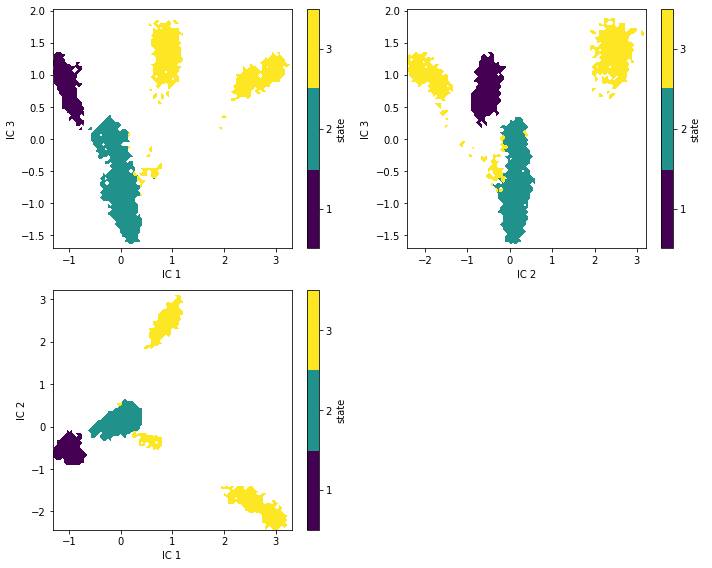

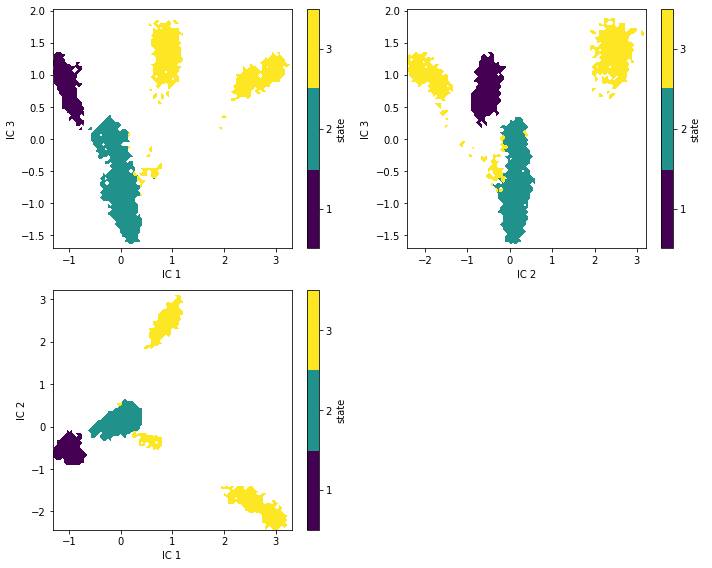

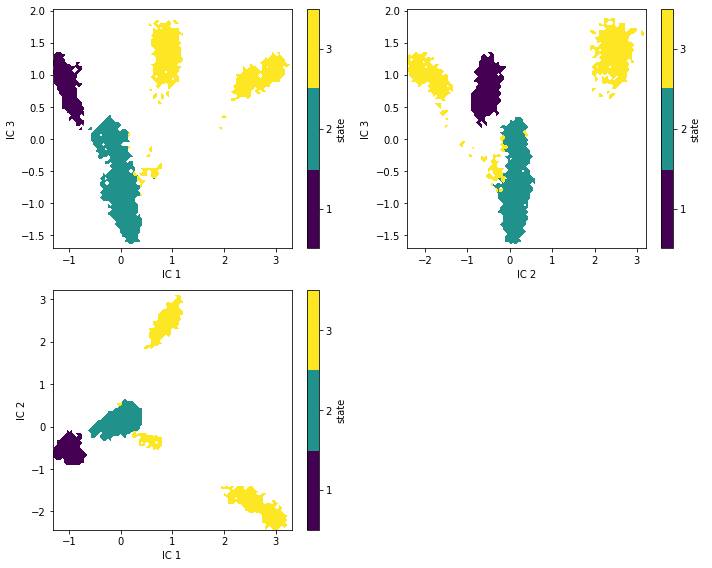

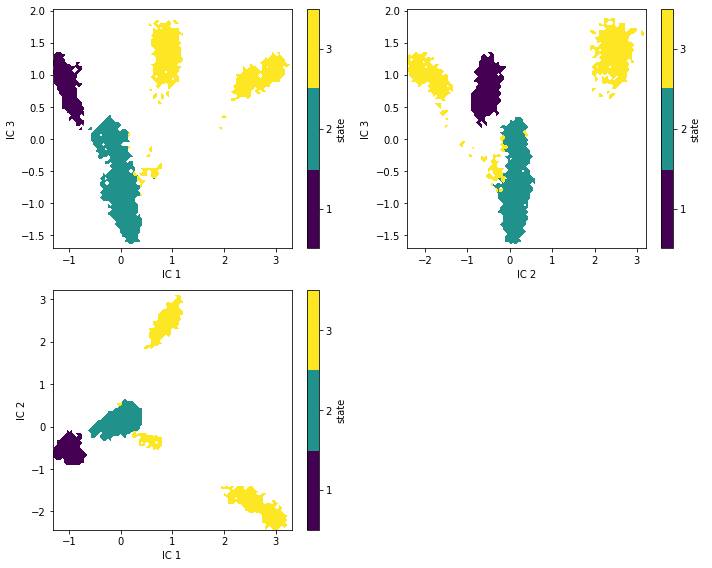

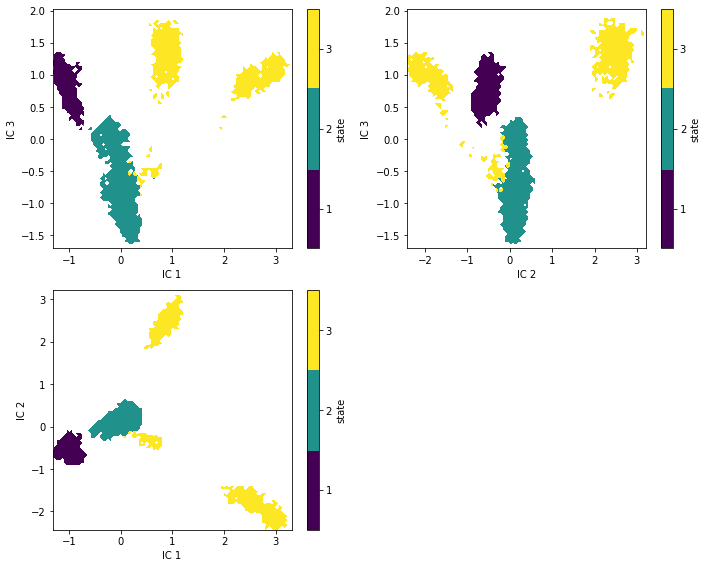

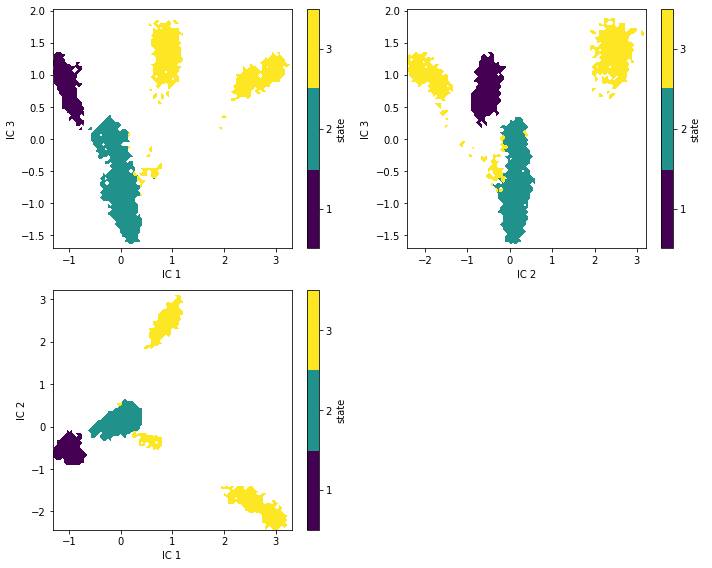

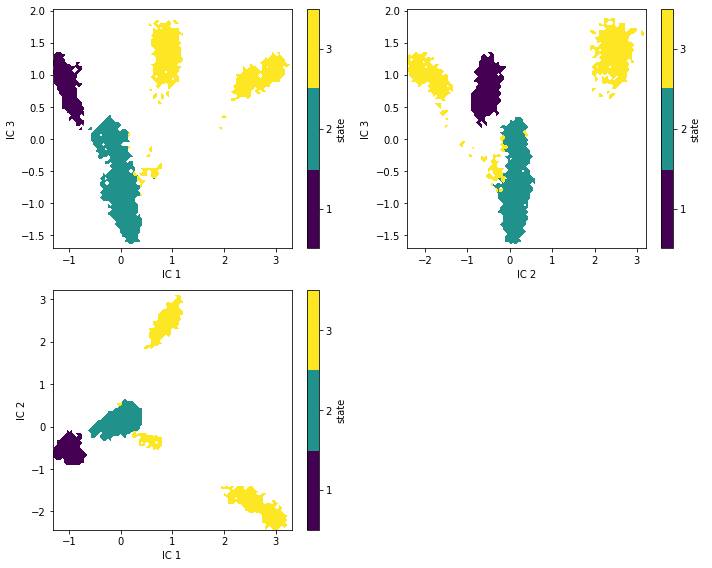

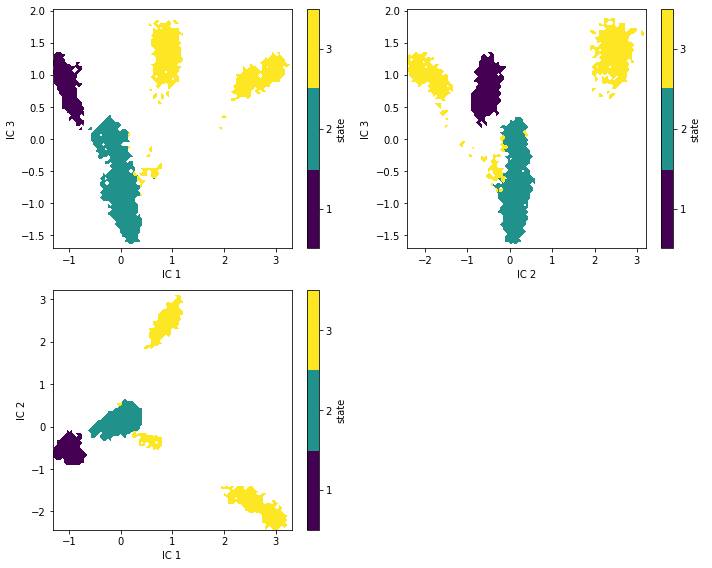

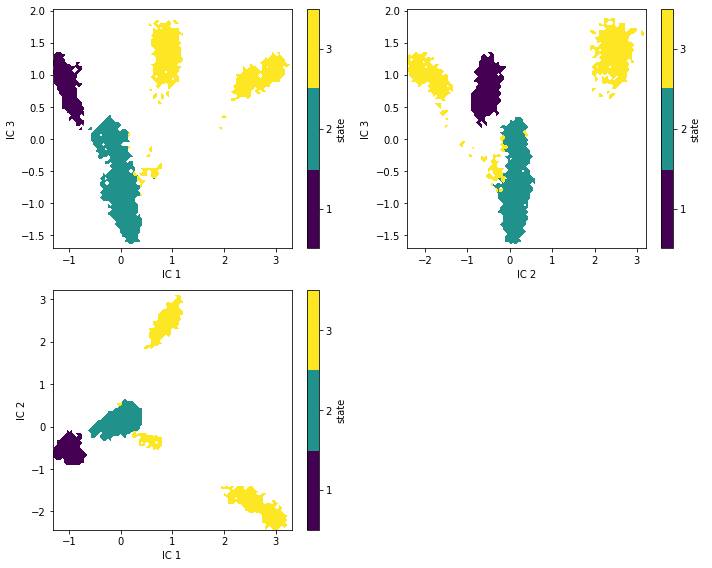

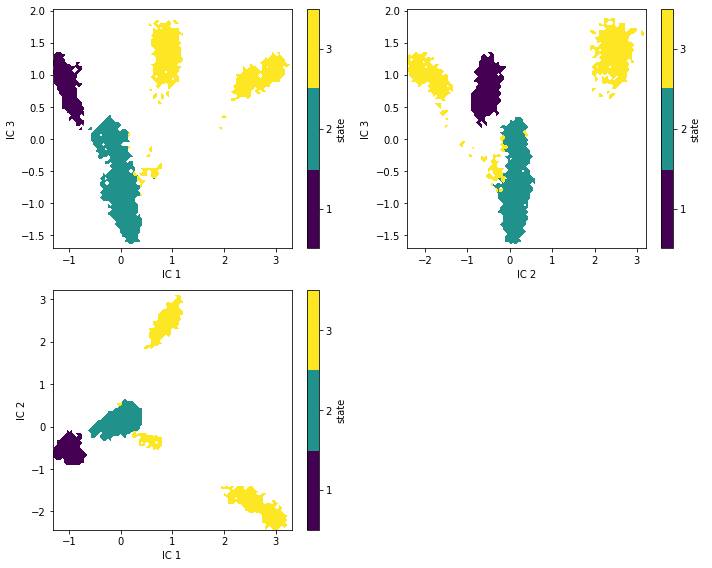

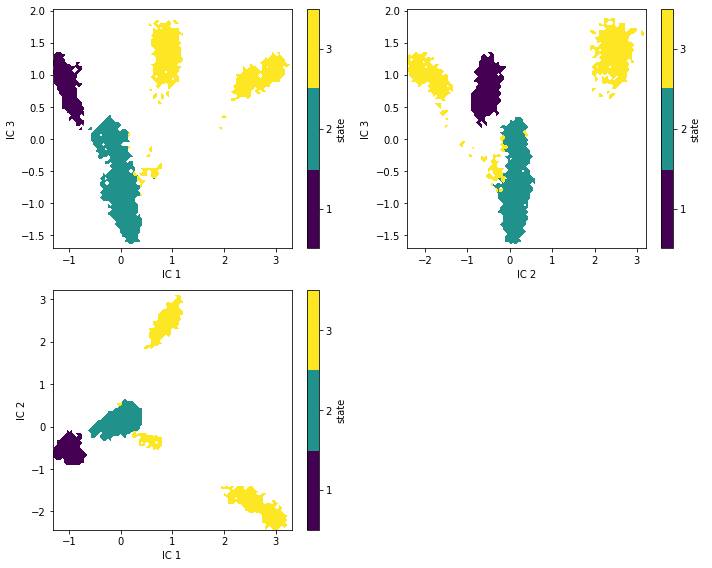

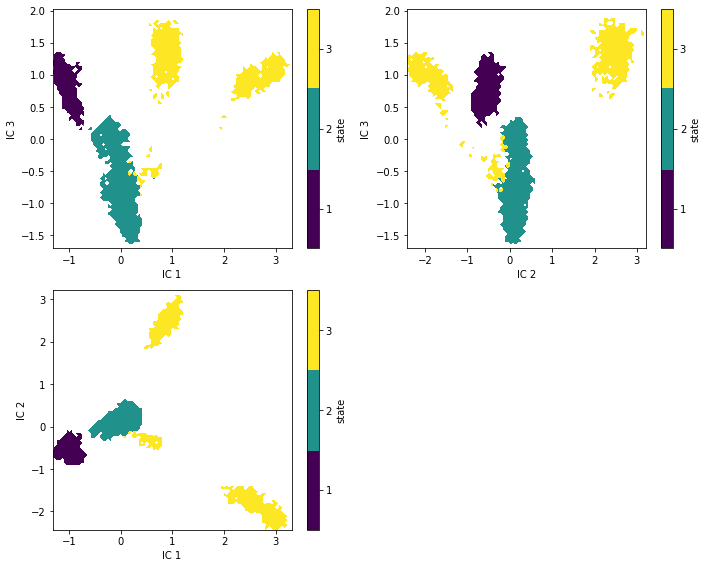

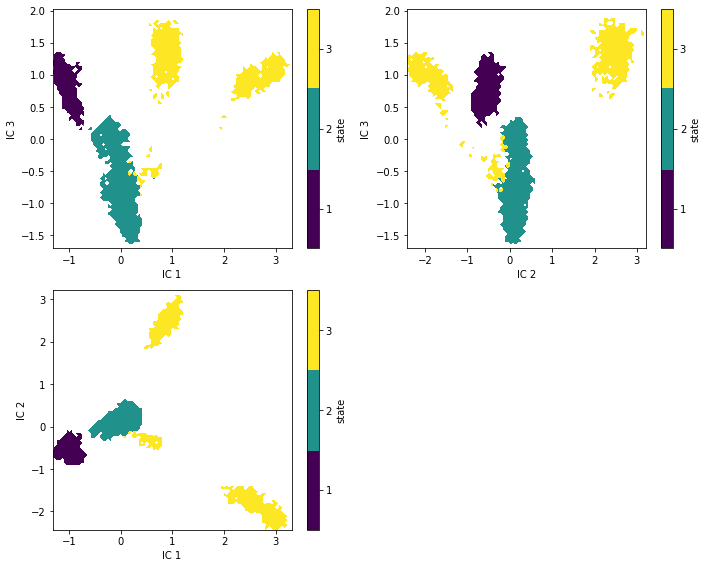

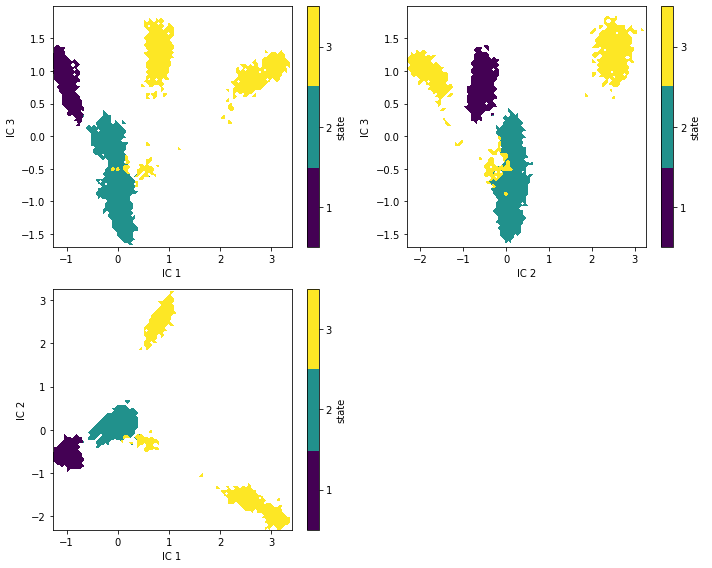

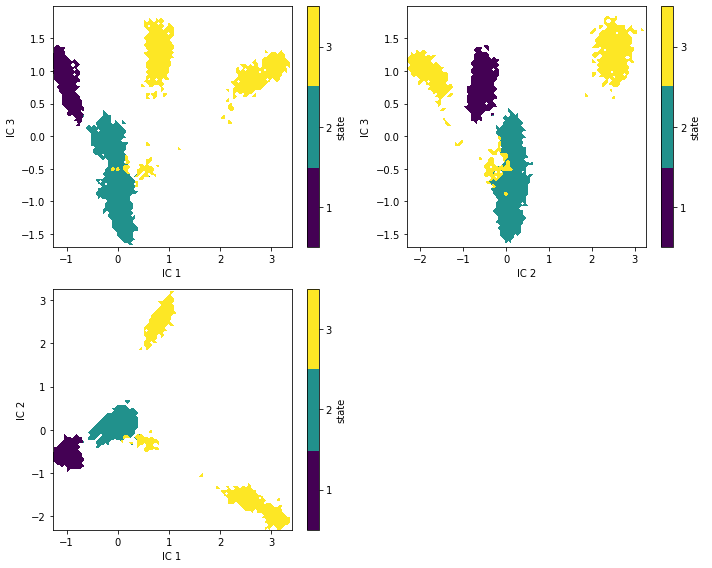

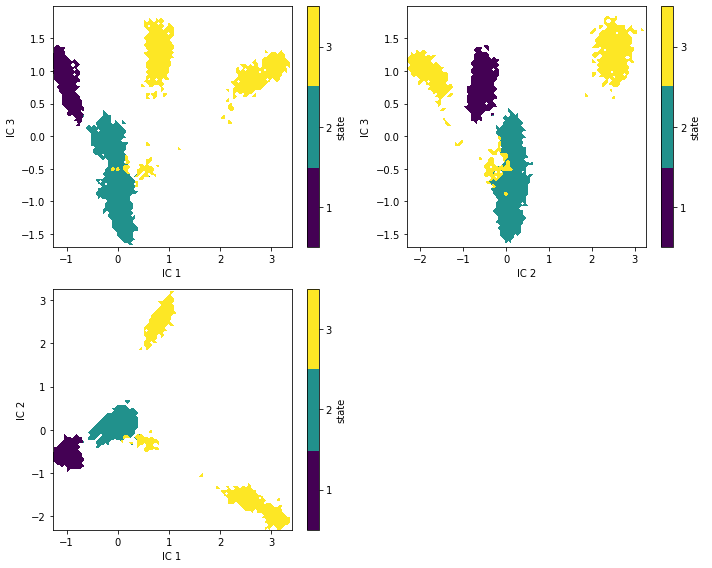

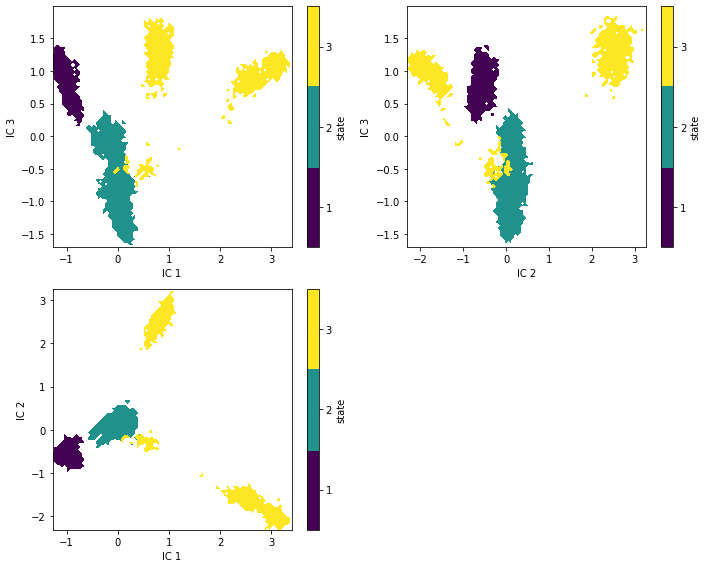

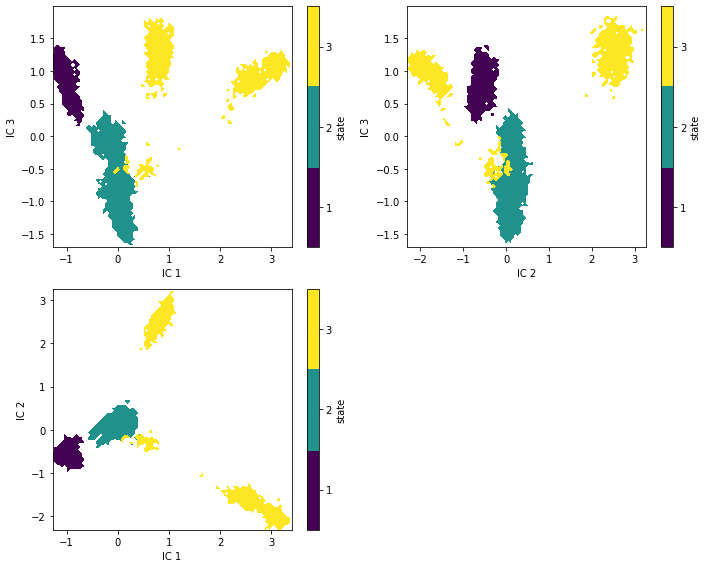

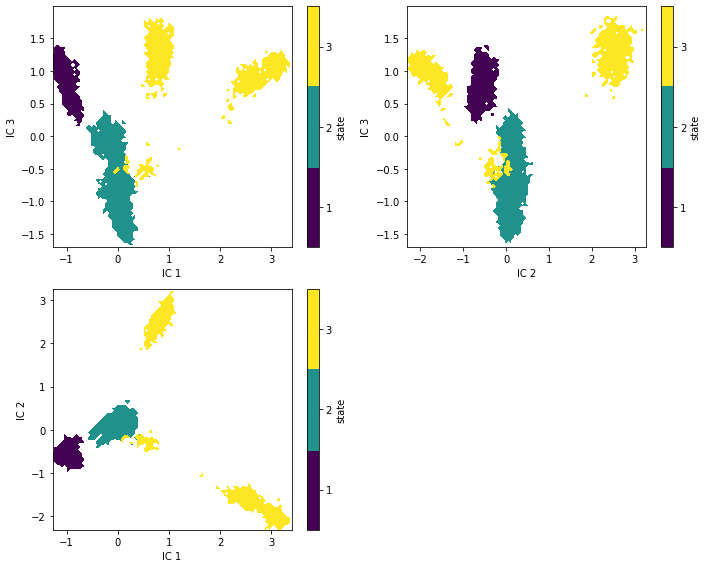

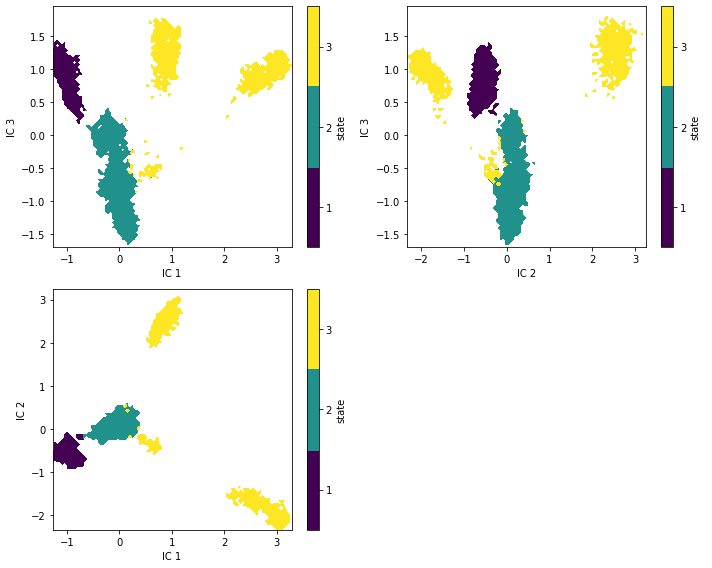

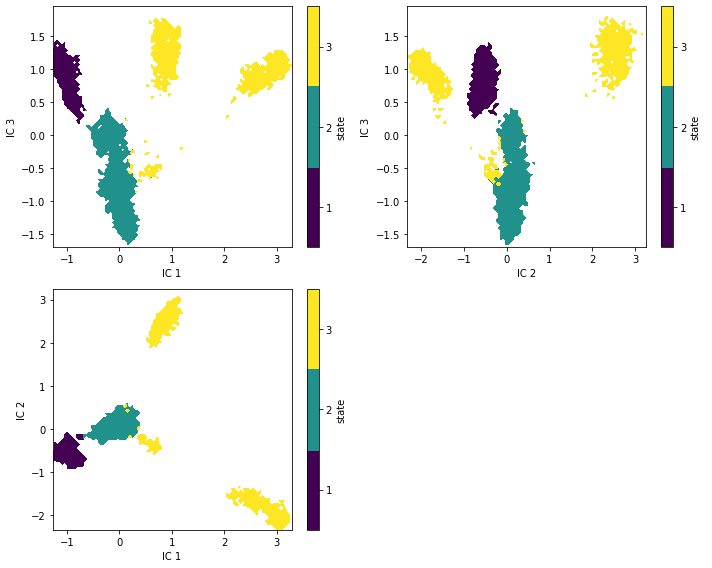

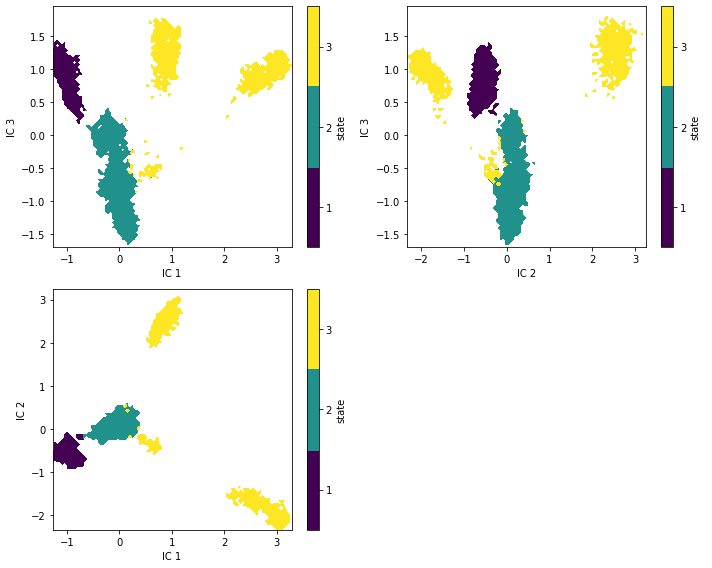

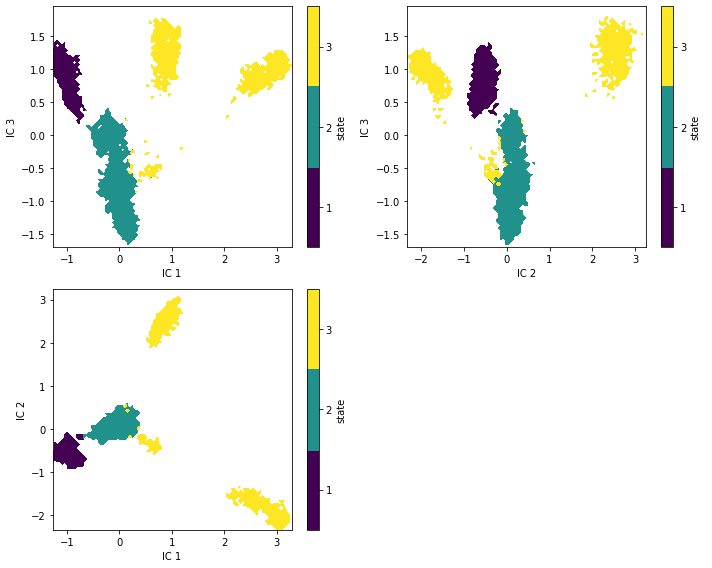

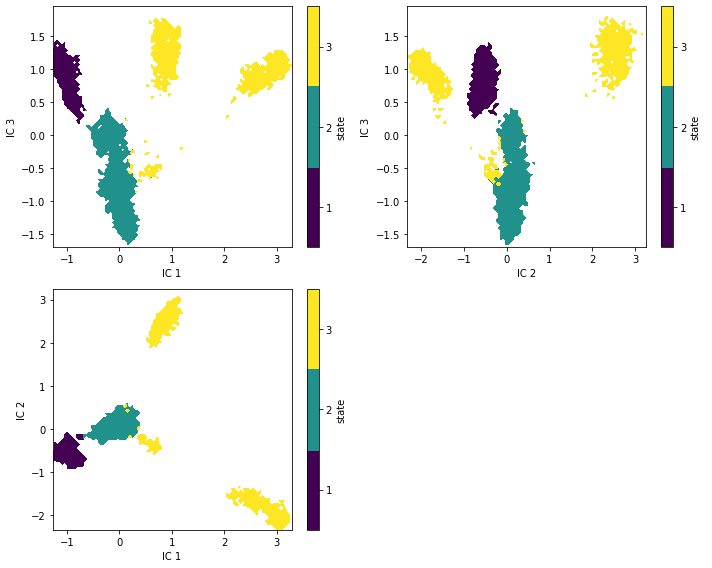

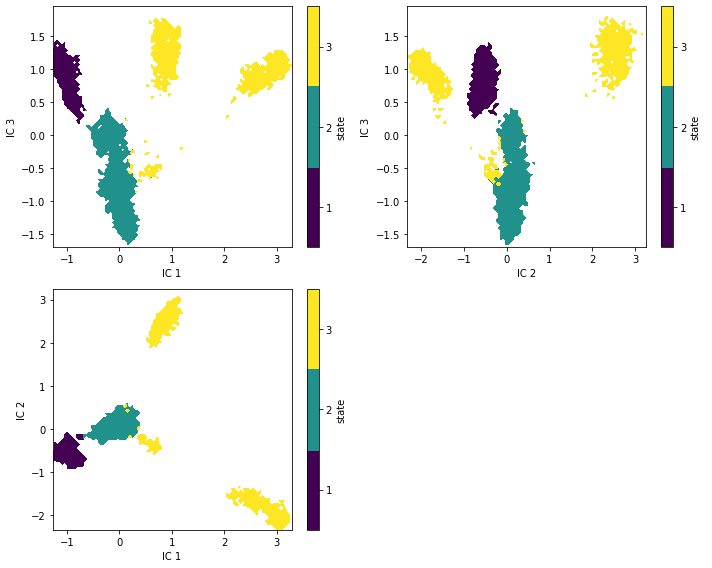

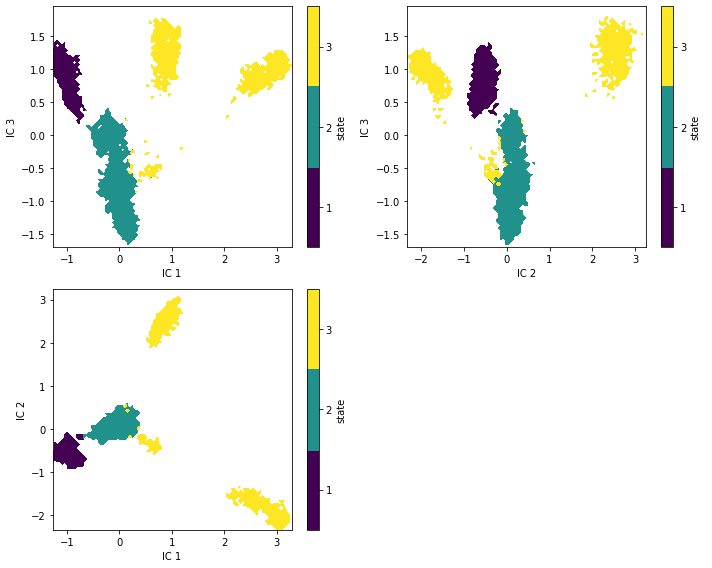

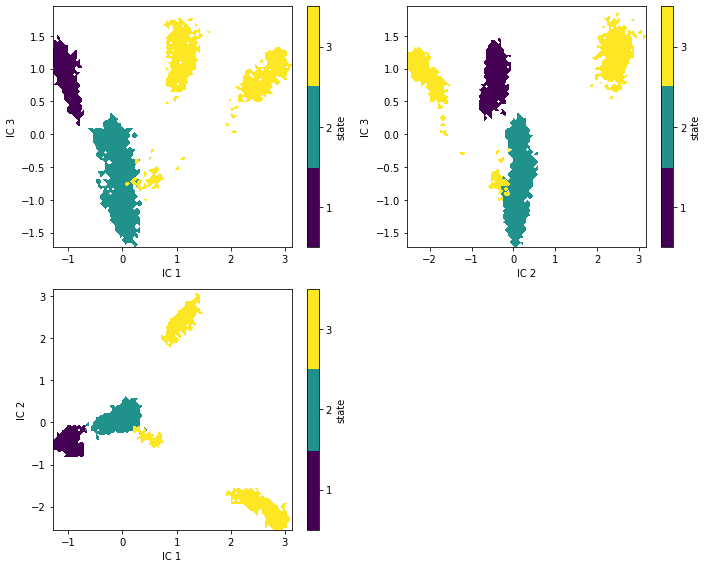

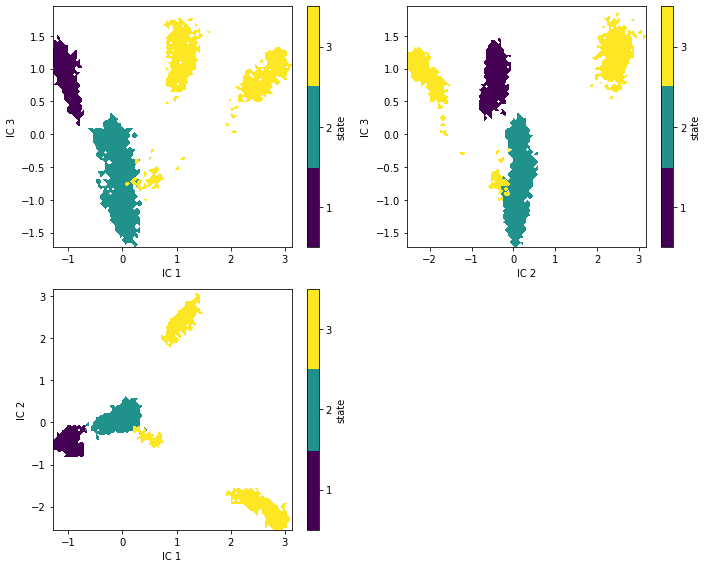

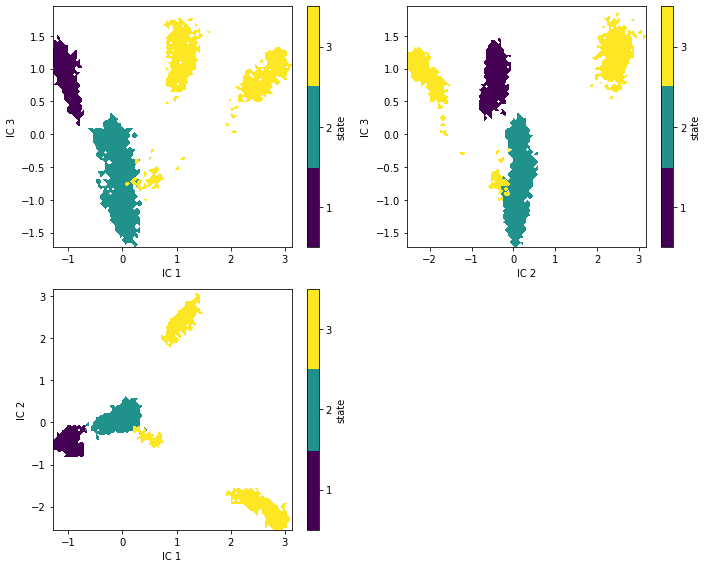

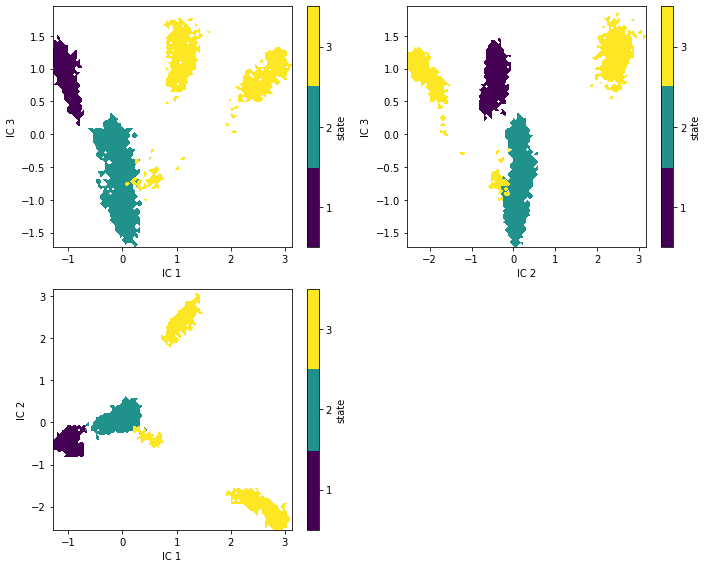

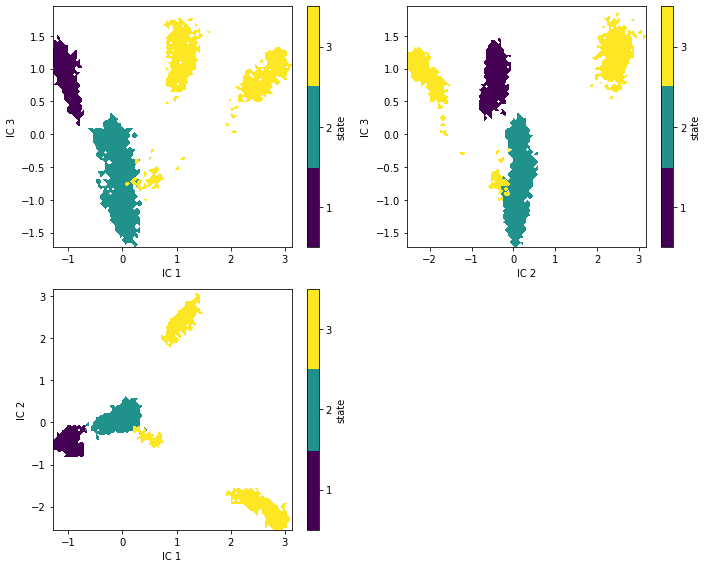

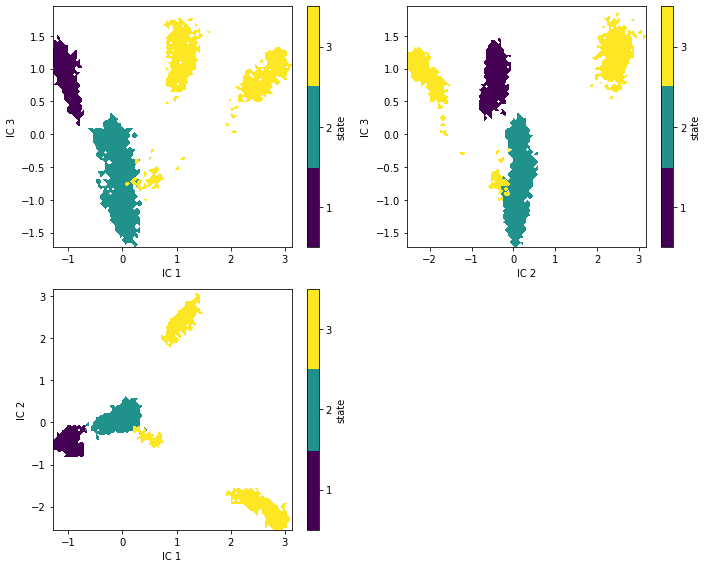

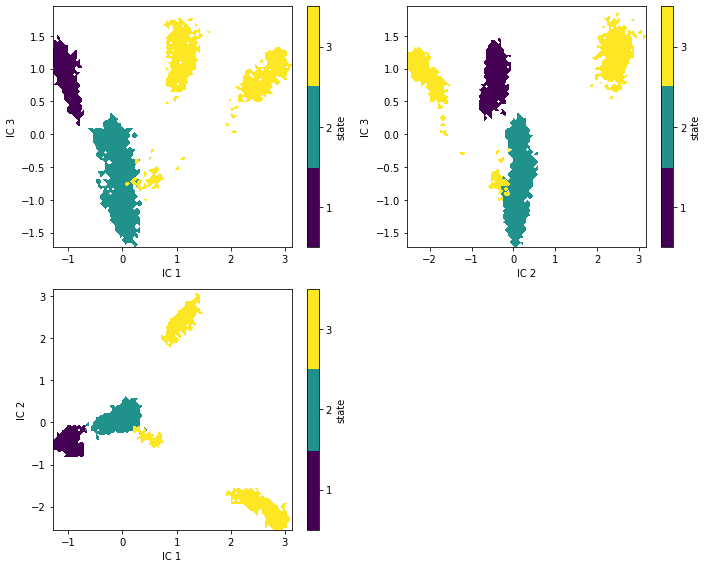

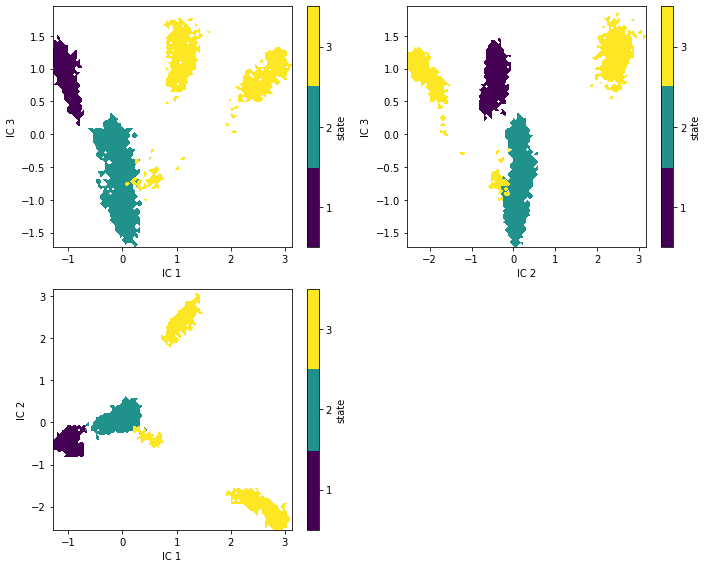

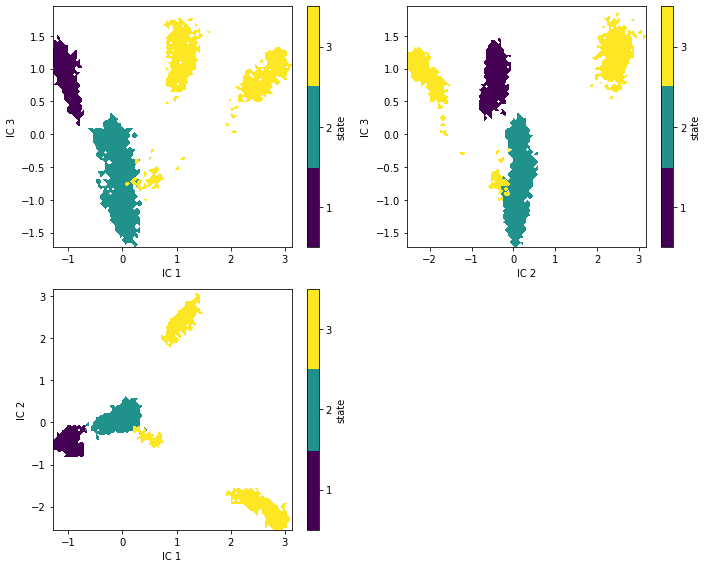

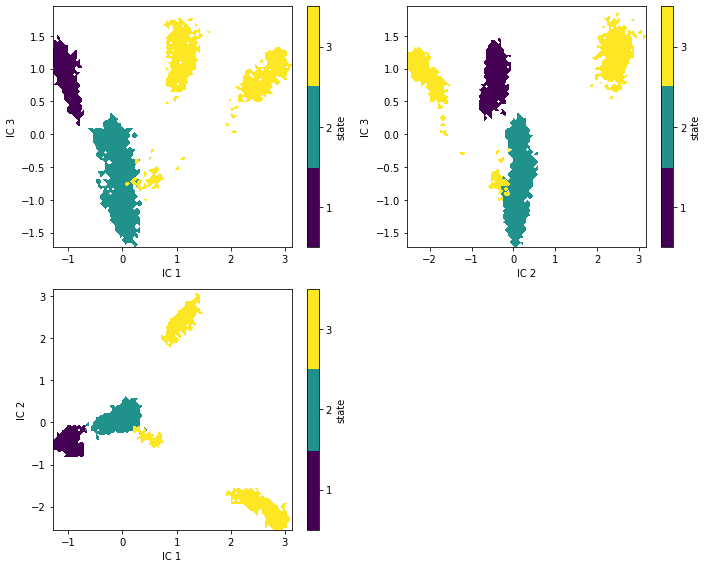

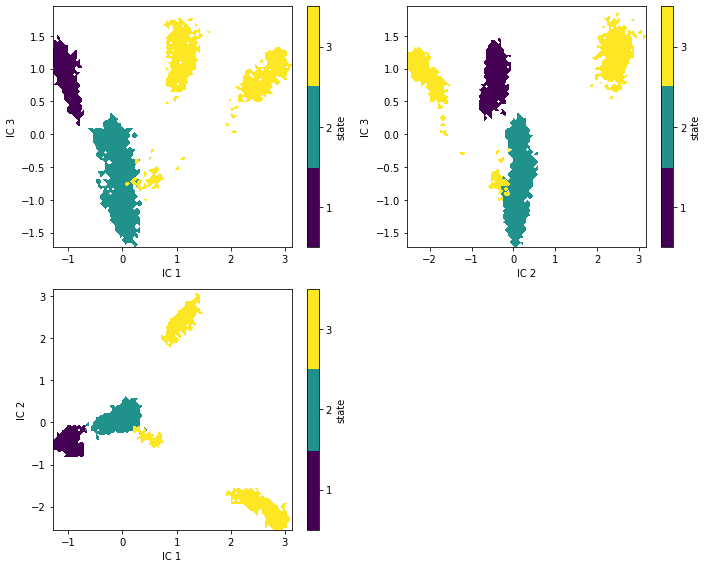

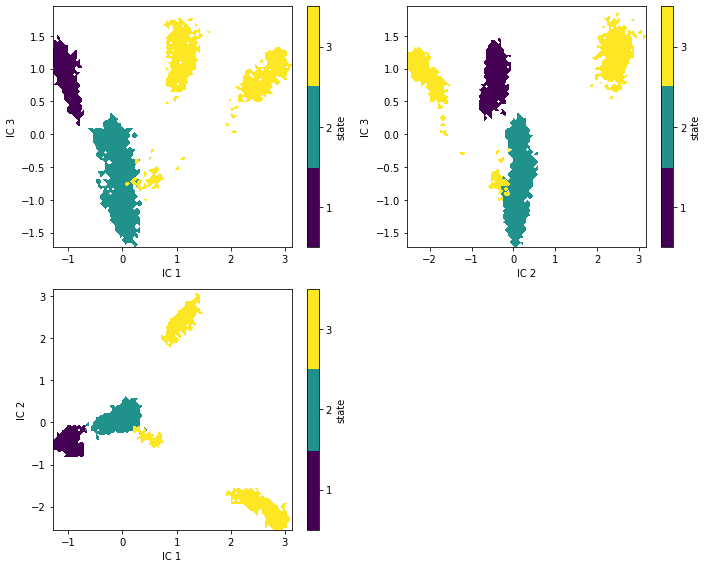

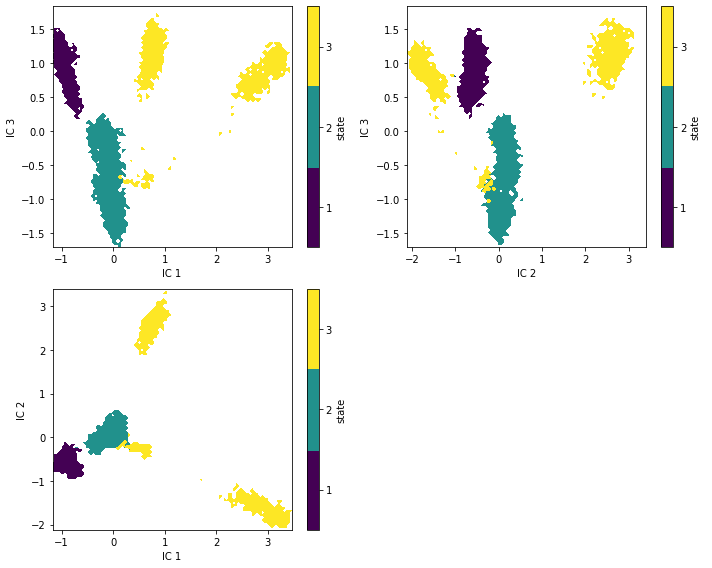

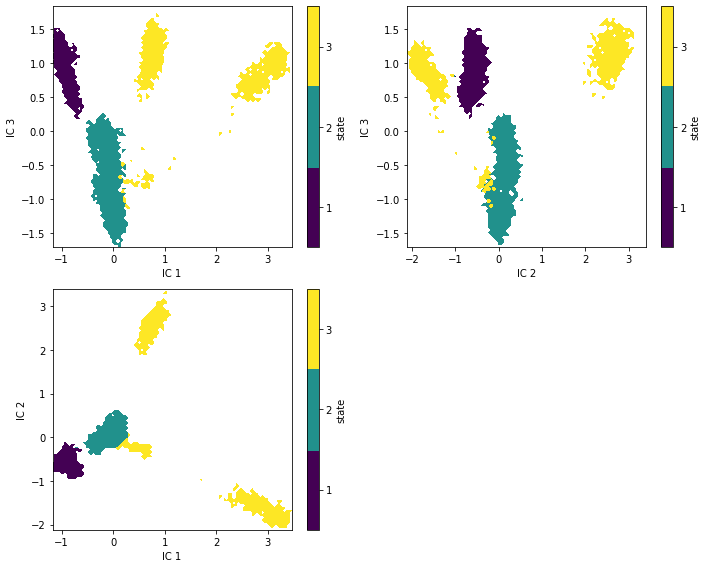

In [13]:
VAMP2(np.arange(0, 0.2, 0.005))